Here we are going to try and predict if person will succeed in all steps of the game. At the beginning, we will only look at pagerank of target (step 0). After first click, we add up informations about cosine similarity of first click, shortest path length and count from first click to target, pagerank of first click. When having at least 2 clicks, we now look at the duration, the pagerank_target, the cosine similarity of last click with regard to target, the shortest path length from last click to target, the shortest path count from last click to target, the maximum pagerank of all clicks so far, how often the back option was used / number of clicks, the difference between cosine similarity of last click - target and source - target.

We will have to have 3 models:
- One for predicting win when only having source article -> this we already have, inherent difficulty !
- One for predicting when we only have first click
- One for predicting win when we have more than one click

We will also test if we get better results by training one model for each number of clicks. This would be highly inefficient since the number of clicks can theoretically go to infinity, but since most games have a smaller number of clicks we could use these models in most cases.

In [87]:
import numpy as np
import pandas as pd

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils.data_processing import *
from utils.graph_processing import *
from models.logistic_regression import LogisticRegression

In [88]:
games = load_preprocessed_games()
games.head()

Loaded 51318 finished paths in df of shape (51318, 7)
Loaded 24875 unfinished paths in df of shape (24875, 8)
After filtering all paths after 2011-02-07 05:02:15
we kept 23245 paths out of 51318 finished paths
There are 24875 unfinished paths
Loaded 4604 articles in df of shape (4604, 1)
Pruning invalid games. Initially we have 48120 games
Pruned invalid games. Now we have 48092 valid games
Removed 101 games that contained non existing links
After removing timeouted games, there are 38696 games left


difficulty_rating  duration  finished            hashIP  num_backward  \
0                NaN       166      True  6a3701d319fc3754             0   
1                3.0        88      True  3824310e536af032             0   
2                NaN       138      True  415612e93584d30e             0   
3                3.0       175      True  015245d773376aab             0   
4                NaN       110      True  5295bca242be81fe             0   

                                                path  path_length  \
0  [14th_century, 15th_century, 16th_century, Pac...            9   
1  [14th_century, Europe, Africa, Atlantic_slave_...            5   
2  [14th_century, Niger, Nigeria, British_Empire,...            8   
3  [14th_century, Italy, Roman_Catholic_Church, H...            7   
4  [14th_century, Europe, North_America, United_S...            6   

         source               target           timestamp type_end  
0  14th_century  African_slave_trade 2011-02-15 03:26:49      NaN  
1  14th_century  African_slave_trade 2012-08-12 06:36:52      NaN  
2  14th_century  African_slave_trade 2012-10-03 21:10:40      NaN  
3  14th_century      John_F._Kennedy 2013-04-23 15:27:08      NaN  
4  14th_century      John_F._Kennedy 2013-07-03 22:26:54      NaN

In [89]:
games = games[games['path_length'] > 1] # remove games of length 1
condition = (games['path_length'] == 2) & (games['finished'] == True)
games = games[~condition] # removes games won in one click

# Predicting using only first click

We have to add up information about pagerank of target, cosine similarity of first click with regards to target, shortest path length and countn from first click to target, pagerank of first click.

In [90]:
games_one = games.copy()
games_one['first_click'] = games_one.apply(lambda row: row['path'][1], axis = 1)
games_one.head()

difficulty_rating  duration  finished            hashIP  num_backward  \
0                NaN       166      True  6a3701d319fc3754             0   
1                3.0        88      True  3824310e536af032             0   
2                NaN       138      True  415612e93584d30e             0   
3                3.0       175      True  015245d773376aab             0   
4                NaN       110      True  5295bca242be81fe             0   

                                                path  path_length  \
0  [14th_century, 15th_century, 16th_century, Pac...            9   
1  [14th_century, Europe, Africa, Atlantic_slave_...            5   
2  [14th_century, Niger, Nigeria, British_Empire,...            8   
3  [14th_century, Italy, Roman_Catholic_Church, H...            7   
4  [14th_century, Europe, North_America, United_S...            6   

         source               target           timestamp type_end  \
0  14th_century  African_slave_trade 2011-02-15 03:26:49      NaN   
1  14th_century  African_slave_trade 2012-08-12 06:36:52      NaN   
2  14th_century  African_slave_trade 2012-10-03 21:10:40      NaN   
3  14th_century      John_F._Kennedy 2013-04-23 15:27:08      NaN   
4  14th_century      John_F._Kennedy 2013-07-03 22:26:54      NaN   

    first_click  
0  15th_century  
1        Europe  
2         Niger  
3         Italy  
4        Europe

In [91]:
games_one.drop(columns = ["difficulty_rating", 'duration', 'hashIP', 'num_backward', 'path_length', 'path','type_end', 'timestamp'], inplace = True)
games_one.head()

finished        source               target   first_click
0      True  14th_century  African_slave_trade  15th_century
1      True  14th_century  African_slave_trade        Europe
2      True  14th_century  African_slave_trade         Niger
3      True  14th_century      John_F._Kennedy         Italy
4      True  14th_century      John_F._Kennedy        Europe

In [92]:
node_stats_df = load_or_compute_node_stats()
games_one = merge_with_node_data(games_one, node_stats_df, columns = ['target', 'first_click'], data = ['pagerank'])
games_one.head()

Loaded 4604 node stats


finished        source               target   first_click  pagerank_target  \
0      True  14th_century  African_slave_trade  15th_century         0.000030   
1      True  14th_century  African_slave_trade        Europe         0.000030   
2      True  14th_century  African_slave_trade         Niger         0.000030   
3      True  14th_century      John_F._Kennedy         Italy         0.000315   
4      True  14th_century      John_F._Kennedy        Europe         0.000315   

   pagerank_first_click  
0              0.001024  
1              0.006698  
2              0.000408  
3              0.003975  
4              0.006698

In [93]:
embeddings_df = load_embeddings()
games_one = compute_cosine_similarity(games_one, embeddings_df, pairs = [['first_click', 'target'], ['source', 'target']])
games_one.head()

Loaded 4604 embeddings in df of shape (4604, 1)


finished        source               target   first_click  pagerank_target  \
0      True  14th_century  African_slave_trade  15th_century         0.000030   
1      True  14th_century  African_slave_trade        Europe         0.000030   
2      True  14th_century  African_slave_trade         Niger         0.000030   
3      True  14th_century      John_F._Kennedy         Italy         0.000315   
4      True  14th_century      John_F._Kennedy        Europe         0.000315   

   pagerank_first_click  cosine_sim_first_click_target  \
0              0.001024                       0.187263   
1              0.006698                       0.146602   
2              0.000408                       0.309651   
3              0.003975                       0.037840   
4              0.006698                      -0.128314   

   cosine_sim_source_target  
0                  0.202444  
1                  0.202444  
2                  0.202444  
3                  0.079502  
4                  0.079502

In [94]:
games_one['cos_diff'] = games_one['cosine_sim_first_click_target'] - games_one['cosine_sim_source_target']

In [11]:
pair_data = load_pair_data()
pair_data.head()

Loaded 4604 articles in df of shape (4604, 1)


shortest_path_length  shortest_path_count  \
source       target                                                    
10th_century 10th_century                     0                    1   
             11th_century                     1                    1   
             12th_century                     2                    5   
             13th_century                     2                    4   
             14th_century                     2                    4   

                           max_sp_node_degree  max_sp_avg_node_degree  \
source       target                                                     
10th_century 10th_century                   0                       0   
             11th_century                  26                      13   
             12th_century                  48                      24   
             13th_century                  79                      35   
             14th_century                  53                      26   

                           avg_sp_avg_node_degree  one_longer_path_count  \
source       target                                                        
10th_century 10th_century                       0                      0   
             11th_century                      13                      2   
             12th_century                      23                    121   
             13th_century                      28                    131   
             14th_century                      22                    113   

                           max_ol_node_degree  max_ol_avg_node_degree  \
source       target                                                     
10th_century 10th_century                   0                       0   
             11th_century                  62                      29   
             12th_century                 180                      93   
             13th_century                 169                      84   
             14th_century                 169                      84   

                           avg_ol_avg_node_degree  two_longer_path_count  \
source       target                                                        
10th_century 10th_century                       0                      0   
             11th_century                      26                      7   
             12th_century                      37                     30   
             13th_century                      39                     30   
             14th_century                      37                     30   

                           max_tl_node_degree  max_tl_avg_node_degree  
source       target                                                    
10th_century 10th_century                   0                       0  
             11th_century                 112                      46  
             12th_century                 169                      70  
             13th_century                 169                      71  
             14th_century                 169                      70

In [95]:
games_one = add_pair_data(games_one, pair_data, pairs =[['first_click', 'target']], names = ["first"], data = ['shortest_path_length', 'shortest_path_count'])
games_one.head()

Dropped 4 games without link statistics


finished        source               target   first_click  pagerank_target  \
0      True  14th_century  African_slave_trade  15th_century         0.000030   
1      True  14th_century  African_slave_trade        Europe         0.000030   
2      True  14th_century  African_slave_trade         Niger         0.000030   
3      True  14th_century      John_F._Kennedy         Italy         0.000315   
4      True  14th_century      John_F._Kennedy        Europe         0.000315   

   pagerank_first_click  cosine_sim_first_click_target  \
0              0.001024                       0.187263   
1              0.006698                       0.146602   
2              0.000408                       0.309651   
3              0.003975                       0.037840   
4              0.006698                      -0.128314   

   cosine_sim_source_target  cos_diff  shortest_path_length_first  \
0                  0.202444 -0.015181                         3.0   
1                  0.202444 -0.055842                         3.0   
2                  0.202444  0.107207                         3.0   
3                  0.079502 -0.041662                         2.0   
4                  0.079502 -0.207816                         2.0   

   shortest_path_count_first  
0                        3.0  
1                        7.0  
2                        4.0  
3                        1.0  
4                        2.0

In [96]:
games_one.columns

Index(['finished', 'source', 'target', 'first_click', 'pagerank_target',
       'pagerank_first_click', 'cosine_sim_first_click_target',
       'cosine_sim_source_target', 'cos_diff', 'shortest_path_length_first',
       'shortest_path_count_first'],
      dtype='object')

In [97]:
games_one.drop(columns = ['source', 'target', 'first_click', 'cosine_sim_source_target'],inplace = True)

In [98]:
features_1 = ['pagerank_target',
       'pagerank_first_click', 'cosine_sim_first_click_target',
       'shortest_path_length_first', 'shortest_path_count_first']

In [99]:
games_one['n'] = 1

In [100]:
model_1 = LogisticRegression(games_one, features_1)
model_1.fit()

Class distribution: finished
False    0.5
True     0.5
Name: proportion, dtype: float64
Total number of samples: 24526
Optimization terminated successfully.
         Current function value: 0.625954
         Iterations 6
Training Set Metrics:
Threshold:   0.4350
F1 Score:    0.6486
Precision:   0.6492
Accuracy:    0.6488
              precision    recall  f1-score   support

       False     0.6675    0.6392    0.6531      2453
        True     0.6539    0.6816    0.6675      2453

    accuracy                         0.6604      4906
   macro avg     0.6607    0.6604    0.6603      4906
weighted avg     0.6607    0.6604    0.6603      4906



In [101]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                19620
Model:                          Logit   Df Residuals:                    19615
Method:                           MLE   Df Model:                            4
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.09694
Time:                        17:45:51   Log-Likelihood:                -12281.
converged:                       True   LL-Null:                       -13600.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3484      0.027     13.023      0.000       0.296       0.401
x2            -0.0660      0.016     -4.123      0.000      -0.097      -0.035
x3             0.0802      0.017      4.750      0.000       0.047       0.113
x4            -0.6796      0.023    -29.767      0.000      -0.724      -0.635
x5             0.1907      0.018     10.634      0.000       0.156       0.226
==============================================================================
"""

In [102]:
X_train, X_test, y_train, y_test = model_1.return_train_test()

In [103]:
print(model_1.threshold)

0.435


# Predicting using more than one click

Now we have to create a function that will automatically build a dataset using the first n number of clicks. n will be at least 2.

In [154]:
def build_dataset(starting_games, n, ind = None):
    cols = []
    for i in range(n): # extracting article 
        cols.append(f"{i+1}_click")
        starting_games[f"{i+1}_click"] = starting_games.apply(lambda row: row['path'][i+1], axis = 1)
    starting_games['duration'] = (n/(starting_games['path_length']-1))* starting_games['duration'] # extracting avg duration

    starting_games['num_back'] = starting_games.apply(lambda a: (a[cols] == '<').sum()/ (n-1), axis = 1) 
    print(starting_games['num_back'].describe())
    print(starting_games['num_back'].unique())

    # removing < sign
    starting_games['2_click'] = starting_games.apply(lambda row: row['2_click'] if (row['2_click'] != '<') else row['source'], axis = 1)
        
    if n > 2:
        for i in range(3, n+1):
            starting_games[f"{i}_click"] = starting_games.apply(
                    lambda row: row[f"{i}_click"] if (row[f"{i}_click"] != '<') else row[f"{i-2}_click"], axis=1)
    
    node_stats_df = load_or_compute_node_stats()
    cols.append('source')
    cols.append('target')
    starting_games = merge_with_node_data(starting_games, node_stats_df, columns = cols, data = ['pagerank'])
    cols.remove('target')
    temp = []
    for i in cols:
        temp.append(f"pagerank_{i}")
    starting_games['max_pagerank'] = starting_games.apply(lambda row: row[temp].max(), axis = 1)
    print(temp)
    
    embeddings_df = load_embeddings()
    starting_games = compute_cosine_similarity(starting_games, embeddings_df, pairs = [['source', 'target'], [f"{n}_click", 'target']])
    starting_games['cos_diff'] = starting_games[f'cosine_sim_{n}_click_target'] - starting_games['cosine_sim_source_target']

    index_before = starting_games.index

    global pair_data
    if 'pair_data' not in globals():
        pair_data = load_pair_data()
    starting_games = add_pair_data(starting_games, pair_data, pairs =[[f'{n}_click', 'target']], names = [f"{n}"], data = ['shortest_path_length', 'shortest_path_count'])

    index_after = starting_games.index

    if ind is not None:
        removed_indices = index_before.difference(index_after)
        ind.difference_update(removed_indices)
    
    for i in range(1, n):
        cols.append(f"pagerank_{i}_click")

    starting_games.rename(columns = {f"pagerank_{n}_click": 'pagerank_n_click', f"cosine_sim_{n}_click_target": 'cosine_sim_n_click_target', f'shortest_path_length_{n}': 'shortest_path_length_n', f'shortest_path_count_{n}': 'shortest_path_count_n'}, inplace = True)

    cols.append("cosine_sim_source_target")
    cols.append("pagerank_source")
    cols.extend(["difficulty_rating", 'hashIP', 'num_backward', 'path_length', 'path','type_end', 'timestamp'])
    cols.append('target')
    starting_games.drop(columns = cols, inplace = True)
    features = starting_games.columns.values.tolist()
    features.remove("finished")
    
    
    return starting_games, features

In [155]:
new_games = games.copy()
new_games = new_games[new_games['path_length'] > 2] 
condition = (new_games['path_length'] == 3) & (new_games['finished'] == True)
new_games = new_games[~condition] # removes games won in two clicks
new_games.head()

difficulty_rating  duration  finished            hashIP  num_backward  \
0                NaN       166      True  6a3701d319fc3754             0   
1                3.0        88      True  3824310e536af032             0   
2                NaN       138      True  415612e93584d30e             0   
3                3.0       175      True  015245d773376aab             0   
4                NaN       110      True  5295bca242be81fe             0   

                                                path  path_length  \
0  [14th_century, 15th_century, 16th_century, Pac...            9   
1  [14th_century, Europe, Africa, Atlantic_slave_...            5   
2  [14th_century, Niger, Nigeria, British_Empire,...            8   
3  [14th_century, Italy, Roman_Catholic_Church, H...            7   
4  [14th_century, Europe, North_America, United_S...            6   

         source               target           timestamp type_end  
0  14th_century  African_slave_trade 2011-02-15 03:26:49      NaN  
1  14th_century  African_slave_trade 2012-08-12 06:36:52      NaN  
2  14th_century  African_slave_trade 2012-10-03 21:10:40      NaN  
3  14th_century      John_F._Kennedy 2013-04-23 15:27:08      NaN  
4  14th_century      John_F._Kennedy 2013-07-03 22:26:54      NaN

In [156]:
dataset, features = build_dataset(new_games, 2)
print(features)
dataset.head()

count    31843.000000
mean         0.048802
std          0.215457
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: num_back, dtype: float64
[0. 1.]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 3 games without link statistics
['duration', 'num_back', 'pagerank_n_click', 'pagerank_target', 'max_pagerank', 'cosine_sim_n_click_target', 'cos_diff', 'shortest_path_length_n', 'shortest_path_count_n']


duration  finished  num_back  pagerank_n_click  pagerank_target  \
0  41.500000      True       0.0          0.001223         0.000030   
1  44.000000      True       0.0          0.003321         0.000030   
2  39.428571      True       0.0          0.000630         0.000030   
3  58.333333      True       0.0          0.002173         0.000315   
4  44.000000      True       0.0          0.002751         0.000315   

   max_pagerank  cosine_sim_n_click_target  cos_diff  shortest_path_length_n  \
0      0.001223                   0.261171  0.058727                     3.0   
1      0.006698                   0.387016  0.184572                     2.0   
2      0.000642                   0.293009  0.090565                     2.0   
3      0.003975                   0.108953  0.029451                     2.0   
4      0.006698                  -0.044935 -0.124437                     2.0   

   shortest_path_count_n  
0                    6.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    2.0

In [157]:
#new_f = features.copy()
#new_f.remove("max_pagerank")
#new_f

In [158]:
dataset['n'] = 2

In [159]:
model_2 = LogisticRegression(dataset, features)
model_2.fit()

Class distribution: finished
False    0.5
True     0.5
Name: proportion, dtype: float64
Total number of samples: 20876
Optimization terminated successfully.
         Current function value: 0.566608
         Iterations 7
Training Set Metrics:
Threshold:   0.5740
F1 Score:    0.7129
Precision:   0.7178
Accuracy:    0.7141
              precision    recall  f1-score   support

       False     0.6925    0.7840    0.7354      2088
        True     0.7511    0.6518    0.6979      2088

    accuracy                         0.7179      4176
   macro avg     0.7218    0.7179    0.7167      4176
weighted avg     0.7218    0.7179    0.7167      4176



In [160]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                16700
Model:                          Logit   Df Residuals:                    16691
Method:                           MLE   Df Model:                            8
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                  0.1826
Time:                        19:12:21   Log-Likelihood:                -9462.4
converged:                       True   LL-Null:                       -11576.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0406      0.042    -25.026      0.000      -1.122      -0.959
x2            -0.0044      0.018     -0.247      0.805      -0.039       0.031
x3            -0.0399      0.024     -1.689      0.091      -0.086       0.006
x4             0.2419      0.028      8.745      0.000       0.188       0.296
x5            -0.0145      0.023     -0.621      0.534      -0.060       0.031
x6            -0.0346      0.037     -0.947      0.344      -0.106       0.037
x7             0.1775      0.035      5.021      0.000       0.108       0.247
x8            -0.9340      0.028    -33.326      0.000      -0.989      -0.879
x9             0.1832      0.020      9.244      0.000       0.144       0.222
==============================================================================
"""

Even though max pagerank and cosine difference seem irrelevant, removing them makes the model perform a bit worse.

In [161]:
all_f = features.copy()
all_f.append('finished')
all_f.append("n")
all_f

['duration',
 'num_back',
 'pagerank_n_click',
 'pagerank_target',
 'max_pagerank',
 'cosine_sim_n_click_target',
 'cos_diff',
 'shortest_path_length_n',
 'shortest_path_count_n',
 'finished',
 'n']

We can see the probability of guessing is now bigger. Let's check with different ns.

In [162]:
def create_from_dataset(datagames, whole_dataset, minn, maxx, filter = True, balanced = False):
    if whole_dataset == None:
        whole_dataset = pd.DataFrame(columns=['duration','num_back','pagerank_n_click','pagerank_target', 'max_pagerank', 'cosine_sim_n_click_target','cos_diff','shortest_path_length_n', 'shortest_path_count_n','finished','n'])
    valid_indices = set(datagames.index)
    final = []
    for n in range (minn, maxx+1):
        print(f"Adding for click {n}...")
        #print(f"Prediction based on first {n} clicks: ")
        n_games = datagames.copy()
        if filter == True:
            n_games = n_games[n_games['path_length'] > n]
            condition = (n_games['path_length'] == (n+1)) & (n_games['finished'] == True)
            n_games = n_games[~condition] # removes games won in n clicks exactly
    
        #print("Number of games before building dataset: ", n_games.shape)
        
        dataset, features = build_dataset(n_games, n, valid_indices if balanced else None)
        dataset['n'] = n
        features.append("n")
        final.append(dataset)
        
    
        #model_n = LogisticRegression(dataset, features)
        #model_n.fit()
        
        print("----------------------------------------------------")
        print()
    if balanced:
        for i in final:
            whole_dataset = pd.concat([whole_dataset, i.loc[list(valid_indices)]], ignore_index=True)
    else:
        for i in final:
            whole_dataset = pd.concat([whole_dataset, i], ignore_index=True)
    whole_dataset['n'] = whole_dataset['n'].astype('float64')
    whole_dataset['finished'] = whole_dataset['finished'].astype('int')
    return whole_dataset
    

In [163]:
whole_dataset = create_from_dataset(games, None, 2, 10)

Adding for click 2...
count    31843.000000
mean         0.048802
std          0.215457
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: num_back, dtype: float64
[0. 1.]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 3 games without link statistics
----------------------------------------------------

Adding for click 3...
count    26308.000000
mean         0.051638
std          0.152163
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.500000
Name: num_back, dtype: float64
[0.  0.5]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 5 games without link statistics
----------------------------------------------------

Adding for click 4...
count    19474.000000
mean      

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2113283413.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  whole_dataset = pd.concat([whole_dataset, i], ignore_index=True)


In [164]:
print(whole_dataset.shape)
whole_dataset.head()

(122987, 11)


duration  num_back  pagerank_n_click  pagerank_target  max_pagerank  \
0  41.500000       0.0          0.001223         0.000030      0.001223   
1  44.000000       0.0          0.003321         0.000030      0.006698   
2  39.428571       0.0          0.000630         0.000030      0.000642   
3  58.333333       0.0          0.002173         0.000315      0.003975   
4  44.000000       0.0          0.002751         0.000315      0.006698   

   cosine_sim_n_click_target  cos_diff  shortest_path_length_n  \
0                   0.261171  0.058727                     3.0   
1                   0.387016  0.184572                     2.0   
2                   0.293009  0.090565                     2.0   
3                   0.108953  0.029451                     2.0   
4                  -0.044935 -0.124437                     2.0   

   shortest_path_count_n  finished    n  
0                    6.0         1  2.0  
1                    1.0         1  2.0  
2                    1.0         1  2.0  
3                    1.0         1  2.0  
4                    2.0         1  2.0

In [165]:
features

['duration',
 'num_back',
 'pagerank_n_click',
 'pagerank_target',
 'max_pagerank',
 'cosine_sim_n_click_target',
 'cos_diff',
 'shortest_path_length_n',
 'shortest_path_count_n']

In [166]:
#whole_dataset['n'] = whole_dataset['n'].astype('float64')
#whole_dataset['finished'] = whole_dataset['finished'].astype('int')
print(whole_dataset.dtypes)
whole_dataset.head()

duration                     float64
num_back                     float64
pagerank_n_click             float64
pagerank_target              float64
max_pagerank                 float64
cosine_sim_n_click_target    float32
cos_diff                     float32
shortest_path_length_n       float64
shortest_path_count_n        float64
finished                       int32
n                            float64
dtype: object


duration  num_back  pagerank_n_click  pagerank_target  max_pagerank  \
0  41.500000       0.0          0.001223         0.000030      0.001223   
1  44.000000       0.0          0.003321         0.000030      0.006698   
2  39.428571       0.0          0.000630         0.000030      0.000642   
3  58.333333       0.0          0.002173         0.000315      0.003975   
4  44.000000       0.0          0.002751         0.000315      0.006698   

   cosine_sim_n_click_target  cos_diff  shortest_path_length_n  \
0                   0.261171  0.058727                     3.0   
1                   0.387016  0.184572                     2.0   
2                   0.293009  0.090565                     2.0   
3                   0.108953  0.029451                     2.0   
4                  -0.044935 -0.124437                     2.0   

   shortest_path_count_n  finished    n  
0                    6.0         1  2.0  
1                    1.0         1  2.0  
2                    1.0         1  2.0  
3                    1.0         1  2.0  
4                    2.0         1  2.0

In [167]:
whole_dataset['num_back'].value_counts()

num_back
0.000000    95251
0.333333     5032
0.500000     4637
0.250000     3857
0.200000     2558
0.166667     1791
1.000000     1554
0.142857     1248
0.400000     1226
0.285714      973
0.125000      898
0.428571      683
0.375000      662
0.111111      658
0.666667      531
0.222222      476
0.444444      408
0.600000      280
0.571429      157
0.555556      107
Name: count, dtype: int64

In [168]:
model = LogisticRegression(whole_dataset, features)
model.fit()

Class distribution: finished
1    0.5
0    0.5
Name: proportion, dtype: float64
Total number of samples: 88694
Optimization terminated successfully.
         Current function value: 0.559975
         Iterations 6
Training Set Metrics:
Threshold:   0.5840
F1 Score:    0.7132
Precision:   0.7169
Accuracy:    0.7141
              precision    recall  f1-score   support

           0     0.6937    0.7724    0.7309      8870
           1     0.7432    0.6589    0.6985      8869

    accuracy                         0.7157     17739
   macro avg     0.7185    0.7157    0.7147     17739
weighted avg     0.7185    0.7157    0.7147     17739



In [169]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                70955
Model:                          Logit   Df Residuals:                    70946
Method:                           MLE   Df Model:                            8
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                  0.1921
Time:                        19:16:15   Log-Likelihood:                -39733.
converged:                       True   LL-Null:                       -49182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5287      0.016    -34.040      0.000      -0.559      -0.498
x2             0.0220      0.008      2.590      0.010       0.005       0.039
x3            -0.0685      0.010     -6.987      0.000      -0.088      -0.049
x4             0.1972      0.013     15.586      0.000       0.172       0.222
x5            -0.0700      0.010     -7.093      0.000      -0.089      -0.051
x6            -0.1024      0.021     -4.893      0.000      -0.143      -0.061
x7             0.1621      0.020      7.914      0.000       0.122       0.202
x8            -1.1538      0.014    -84.074      0.000      -1.181      -1.127
x9             0.2173      0.010     22.351      0.000       0.198       0.236
==============================================================================
"""

In [170]:
X_train, X_test, y_train, y_test = model.return_train_test()

In [171]:
model.threshold

0.584

In [172]:
print(y_test.value_counts())
print(model.n_test.value_counts())

finished
0    8870
1    8869
Name: count, dtype: int64
n
2.0     4419
3.0     3795
4.0     2823
5.0     2019
6.0     1516
7.0     1114
8.0      829
9.0      676
10.0     548
Name: count, dtype: int64


In [173]:
y_pred = model.predict(X_test)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)
n_test_series = pd.Series(model.n_test).reset_index(drop=True)
y_test_series = pd.Series(y_test).reset_index(drop=True)

df = pd.concat([y_pred_series, n_test_series, y_test_series], axis=1)

df.columns = ['y_pred', 'n_test', 'y_test']

df.head()

y_pred  n_test  y_test
0    True     4.0       0
1    True     6.0       1
2    True     3.0       1
3    True     2.0       0
4    True     3.0       1

In [174]:
df.groupby("n_test").apply(lambda group: (group['y_test']==1).sum() / len(group))

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\319750403.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("n_test").apply(lambda group: (group['y_test']==1).sum() / len(group))


n_test
2.0     0.539489
3.0     0.546245
4.0     0.510096
5.0     0.491332
6.0     0.437335
7.0     0.455117
8.0     0.422195
9.0     0.399408
10.0    0.346715
dtype: float64

In [175]:
df.groupby("n_test").apply(lambda group: (group['y_pred'] == group['y_test']).sum() / len(group))

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2584456274.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("n_test").apply(lambda group: (group['y_pred'] == group['y_test']).sum() / len(group))


n_test
2.0     0.692012
3.0     0.732016
4.0     0.710237
5.0     0.724616
6.0     0.726913
7.0     0.711849
8.0     0.717732
9.0     0.730769
10.0    0.742701
dtype: float64

In [176]:
df.groupby("y_pred").apply(lambda group: (group['y_pred'] == group['y_test']).sum() / len(group))

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\1171718768.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("y_pred").apply(lambda group: (group['y_pred'] == group['y_test']).sum() / len(group))


y_pred
False    0.693702
True     0.743228
dtype: float64

In [177]:
print(model.unused['n'].value_counts())
model.unused.groupby('n')['finished'].value_counts()

n
2.0     9434
3.0     7650
4.0     5517
5.0     3830
6.0     2765
7.0     1911
8.0     1342
9.0     1045
10.0     799
Name: count, dtype: int64


n     finished
2.0   1           9434
3.0   1           7650
4.0   1           5517
5.0   1           3830
6.0   1           2765
7.0   1           1911
8.0   1           1342
9.0   1           1045
10.0  1            799
Name: count, dtype: int64

In [178]:
for i in range(2, 11):
    df_i = model.unused.copy()[model.unused['n'] == i]
    y_pred = model.predict_proba(df_i.drop(columns = ['finished', 'n']))
    print(f"For number of clicks {i}, accuracy is {(y_pred > 0.544).sum() / len(y_pred)}")

For number of clicks 2, accuracy is 0.7017171931312275
For number of clicks 3, accuracy is 0.7509803921568627
For number of clicks 4, accuracy is 0.751857893782853
For number of clicks 5, accuracy is 0.7342036553524804
For number of clicks 6, accuracy is 0.6990958408679928
For number of clicks 7, accuracy is 0.6577708006279435
For number of clicks 8, accuracy is 0.6035767511177347
For number of clicks 9, accuracy is 0.5377990430622009
For number of clicks 10, accuracy is 0.5181476846057572


## Analysing long games (at least 10 clicks)

We will choose 600 games, 300 finished and 300 unfinished that have long paths, randomly chosen, and see how the prediction changes over time as the game is played.

In [241]:
n_min = 10

In [242]:
def create_dataset_and_samples(n_min, start_dataset, num_samples, max_path_length = None):
    dataset = start_dataset.copy()
    if max_path_length is not None:
        true_games = dataset[(dataset['path_length'] > (n_min+1)) & (dataset['finished'] == True) & (dataset['path_length'] <= max_path_length)]
        false_games = dataset[(dataset['path_length'] > (n_min+1)) & (dataset['finished'] == False) & (dataset['path_length'] <= max_path_length)]
        
    else:
        true_games = dataset[(dataset['path_length'] > (n_min+1)) & (dataset['finished'] == True)]
        false_games = dataset[(dataset['path_length'] > (n_min+1)) & (dataset['finished'] == False)]

    sampled_true_games = true_games.sample(n=num_samples, random_state=7)
    sampled_false_games = false_games.sample(n=num_samples, random_state=7)
    dataset = dataset.drop(sampled_true_games.index)
    dataset = dataset.drop(sampled_false_games.index)
    new_dataset = create_from_dataset(dataset, None, 2, n_min)
    sampled_true_games_m = create_from_dataset(sampled_true_games, None, 2, n_min, balanced = True)
    sampled_false_games_m = create_from_dataset(sampled_false_games, None, 2, n_min, balanced = True)
    return new_dataset, sampled_true_games_m, sampled_false_games_m


In [273]:
def predict_and_print(true_games, false_games, num_samples, threshold, model, graphs = False):
    y_pred_true = model.predict_proba(true_games.drop(columns = ['finished', 'n']))
    y_pred_false = model.predict_proba(false_games.drop(columns = ['finished', 'n']))
    
    y_pred_true_reshaped = y_pred_true.reshape((n_min-1), num_samples - ((num_samples*(n_min-1)-len(y_pred_true))//(n_min-1))).T
    y_pred_false_reshaped = y_pred_false.reshape((n_min-1), num_samples - ((num_samples*(n_min-1)-len(y_pred_false))//(n_min-1))).T

    true_games_stats = (y_pred_true_reshaped > threshold).astype(int)
    false_games_stats = (y_pred_false_reshaped > threshold).astype(int)
    real_true = true_games['finished'].values.reshape((n_min-1), num_samples - ((num_samples*(n_min-1)-len(y_pred_true))//(n_min-1))).T
    real_false = false_games['finished'].values.reshape((n_min-1), num_samples - ((num_samples*(n_min-1)-len(y_pred_false))//(n_min-1))).T
    
    matches_true = (true_games_stats == real_true)
    matches_false = (false_games_stats == real_false)
    
    accuracies_true = matches_true.mean(axis=0)
    accuracies_false = matches_false.mean(axis=0)
    
    print("Accuracies for clicks in finished games:")
    for idx, acc in enumerate(accuracies_true):
        print(f"Accuracy at index {idx}: {acc:.4f}")
    
    print("Accuracies for clicks in unfinished games:")
    for idx, acc in enumerate(accuracies_false):
        print(f"Accuracy at index {idx}: {acc:.4f}")

    if graphs == True:
        labels=['2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']
        print("Won")
        for row in y_pred_true_reshaped:
            plt.plot(row, alpha=0.5)
            plt.ylim(0, 1)
            print(int(true_games['n'].max()-1), type(int(true_games['n'].max()-1)))
            plt.xticks(ticks=np.arange(int(true_games['n'].max()-1)), labels=labels[:int(true_games['n'].max()-1)])
            plt.show()
        print("Lost")
        for row in y_pred_false_reshaped:
            plt.plot(row, alpha=0.5)
            plt.ylim(0, 1)
            print(int(false_games['n'].max()-1), type(int(false_games['n'].max()-1)))
            plt.xticks(ticks=np.arange(int(false_games['n'].max()-1)), labels=labels[:int(false_games['n'].max()-1)])
            plt.show()

In [244]:
data, true_games, false_games = create_dataset_and_samples(n_min, games, 500)

Adding for click 2...
count    30843.000000
mean         0.047239
std          0.212154
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: num_back, dtype: float64
[0. 1.]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 2 games without link statistics
----------------------------------------------------

Adding for click 3...
count    25308.000000
mean         0.049708
std          0.149612
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.500000
Name: num_back, dtype: float64
[0.  0.5]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 3 games without link statistics
----------------------------------------------------

Adding for click 4...
count    18474.000000
mean      

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2113283413.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  whole_dataset = pd.concat([whole_dataset, i], ignore_index=True)


['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
----------------------------------------------------

Adding for click 3...
count    500.000000
mean       0.122000
std        0.214961
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: num_back, dtype: float64
[0.  0.5]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 1 games without link statistics
----------------------------------------------------

Adding for click 4...
count    500.000000
mean       0.142667
std        0.206986
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        0.666667
Name: num_back, dtype: float64
[0.         0.33333333 0.66666667]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_4_click', 'pagerank_source']

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2113283413.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  whole_dataset = pd.concat([whole_dataset, i.loc[list(valid_indices)]], ignore_index=True)


count    500.000000
mean       0.076000
std        0.265264
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: num_back, dtype: float64
[0. 1.]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 1 games without link statistics
----------------------------------------------------

Adding for click 3...
count    500.000000
mean       0.079000
std        0.182553
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: num_back, dtype: float64
[0.  0.5]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 1 games without link statistics
----------------------------------------------------

Adding for click 4...
count    500.000000
mean       0.097333
std        0.173615
min        0.000000
25%   

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2113283413.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  whole_dataset = pd.concat([whole_dataset, i.loc[list(valid_indices)]], ignore_index=True)


In [245]:
data.head()

duration  num_back  pagerank_n_click  pagerank_target  max_pagerank  \
0  41.500000       0.0          0.001223         0.000030      0.001223   
1  44.000000       0.0          0.003321         0.000030      0.006698   
2  39.428571       0.0          0.000630         0.000030      0.000642   
3  58.333333       0.0          0.002173         0.000315      0.003975   
4  44.000000       0.0          0.002751         0.000315      0.006698   

   cosine_sim_n_click_target  cos_diff  shortest_path_length_n  \
0                   0.261171  0.058727                     3.0   
1                   0.387016  0.184572                     2.0   
2                   0.293009  0.090565                     2.0   
3                   0.108953  0.029451                     2.0   
4                  -0.044935 -0.124437                     2.0   

   shortest_path_count_n  finished    n  
0                    6.0         1  2.0  
1                    1.0         1  2.0  
2                    1.0         1  2.0  
3                    1.0         1  2.0  
4                    2.0         1  2.0

In [250]:
model = LogisticRegression(data, features)
model.fit(train_size = 0.9)

Class distribution: finished
1    0.5
0    0.5
Name: proportion, dtype: float64
Total number of samples: 79712
Optimization terminated successfully.
         Current function value: 0.553179
         Iterations 6
Training Set Metrics:
Threshold:   0.5820
F1 Score:    0.7202
Precision:   0.7228
Accuracy:    0.7208
              precision    recall  f1-score   support

           0     0.7004    0.7672    0.7323      3986
           1     0.7427    0.6719    0.7055      3986

    accuracy                         0.7195      7972
   macro avg     0.7215    0.7195    0.7189      7972
weighted avg     0.7215    0.7195    0.7189      7972



In [251]:
model.threshold

0.582

In [252]:
print(true_games.shape, false_games.shape)

(4491, 11) (4491, 11)


In [254]:
predict_and_print(true_games, false_games, 500, 0.4, model)

Accuracies for clicks in finished games:
Accuracy at index 0: 0.4749
Accuracy at index 1: 0.4790
Accuracy at index 2: 0.5190
Accuracy at index 3: 0.5070
Accuracy at index 4: 0.5150
Accuracy at index 5: 0.5030
Accuracy at index 6: 0.5391
Accuracy at index 7: 0.5952
Accuracy at index 8: 0.6393
Accuracies for clicks in unfinished games:
Accuracy at index 0: 0.7275
Accuracy at index 1: 0.7114
Accuracy at index 2: 0.6854
Accuracy at index 3: 0.7094
Accuracy at index 4: 0.6914
Accuracy at index 5: 0.7214
Accuracy at index 6: 0.7234
Accuracy at index 7: 0.7595
Accuracy at index 8: 0.7335


Let's try for games of length between 9 and 11 (first 8 clicks).

In [255]:
n_min = 8

In [256]:
data, true_games, false_games = create_dataset_and_samples(n_min, games, 500, 11)

Adding for click 2...
count    30843.000000
mean         0.047855
std          0.213463
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: num_back, dtype: float64
[0. 1.]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 3 games without link statistics
----------------------------------------------------

Adding for click 3...
count    25308.000000
mean         0.050360
std          0.150481
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.500000
Name: num_back, dtype: float64
[0.  0.5]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
Dropped 5 games without link statistics
----------------------------------------------------

Adding for click 4...
count    18474.000000
mean      

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2113283413.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  whole_dataset = pd.concat([whole_dataset, i], ignore_index=True)


count    500.000000
mean       0.096000
std        0.294886
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: num_back, dtype: float64
[0. 1.]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
----------------------------------------------------

Adding for click 3...
count    500.000000
mean       0.101000
std        0.200947
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: num_back, dtype: float64
[0.  0.5]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
----------------------------------------------------

Adding for click 4...
count    500.000000
mean       0.116000
std        0.195387
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        0.666667
Name: 

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2113283413.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  whole_dataset = pd.concat([whole_dataset, i.loc[list(valid_indices)]], ignore_index=True)


count    500.000000
mean       0.060000
std        0.237725
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: num_back, dtype: float64
[0. 1.]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
----------------------------------------------------

Adding for click 3...
count    500.000000
mean       0.067000
std        0.170497
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: num_back, dtype: float64
[0.  0.5]
Loaded 4604 node stats
['pagerank_1_click', 'pagerank_2_click', 'pagerank_3_click', 'pagerank_source']
Loaded 4604 embeddings in df of shape (4604, 1)
----------------------------------------------------

Adding for click 4...
count    500.000000
mean       0.085333
std        0.172239
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.666667
Name: 

C:\Users\bgabe\AppData\Local\Temp\ipykernel_13716\2113283413.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  whole_dataset = pd.concat([whole_dataset, i.loc[list(valid_indices)]], ignore_index=True)


In [257]:
model = LogisticRegression(data, features)
model.fit(train_size = 0.9)

Class distribution: finished
1    0.5
0    0.5
Name: proportion, dtype: float64
Total number of samples: 74468
Optimization terminated successfully.
         Current function value: 0.557042
         Iterations 6
Training Set Metrics:
Threshold:   0.5790
F1 Score:    0.7194
Precision:   0.7217
Accuracy:    0.7200
              precision    recall  f1-score   support

           0     0.7044    0.7543    0.7285      3724
           1     0.7355    0.6833    0.7084      3723

    accuracy                         0.7188      7447
   macro avg     0.7199    0.7188    0.7185      7447
weighted avg     0.7199    0.7188    0.7185      7447



Accuracies for clicks in finished games:
Accuracy at index 0: 0.3940
Accuracy at index 1: 0.4540
Accuracy at index 2: 0.5000
Accuracy at index 3: 0.5580
Accuracy at index 4: 0.6100
Accuracy at index 5: 0.7440
Accuracy at index 6: 0.8880
Accuracies for clicks in unfinished games:
Accuracy at index 0: 0.7500
Accuracy at index 1: 0.6960
Accuracy at index 2: 0.7120
Accuracy at index 3: 0.7040
Accuracy at index 4: 0.7000
Accuracy at index 5: 0.7220
Accuracy at index 6: 0.7500
7 <class 'int'>


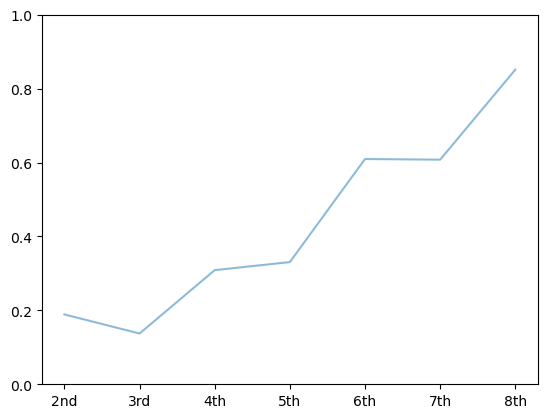

7 <class 'int'>


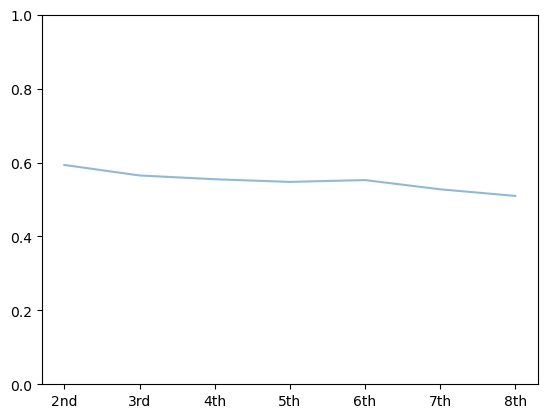

7 <class 'int'>


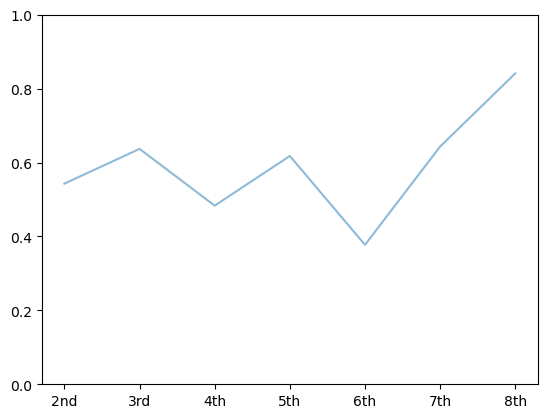

7 <class 'int'>


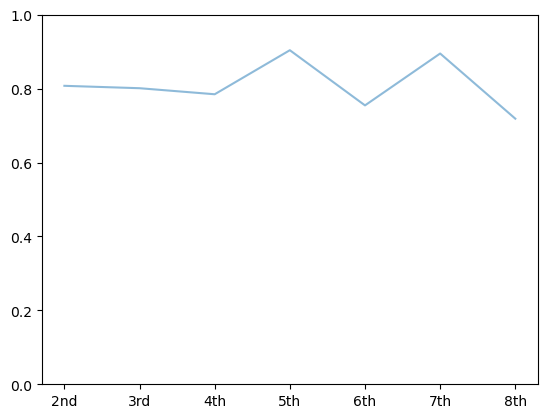

7 <class 'int'>


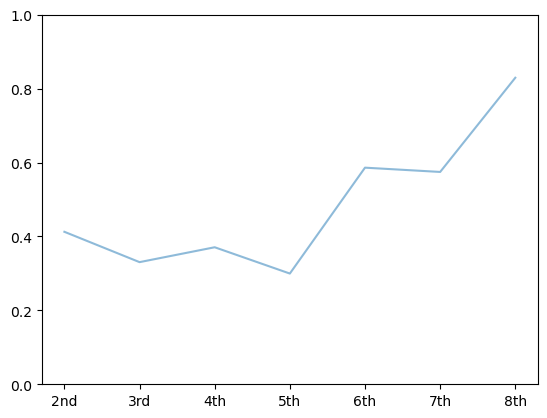

7 <class 'int'>


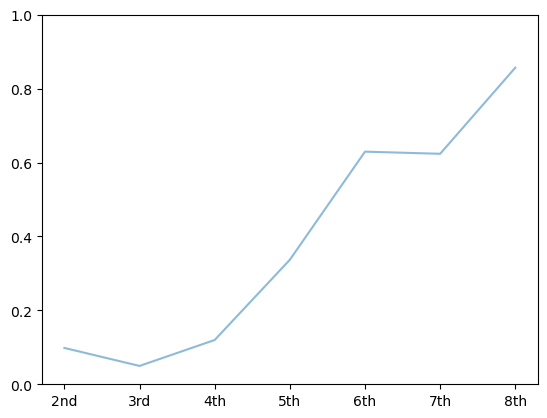

7 <class 'int'>


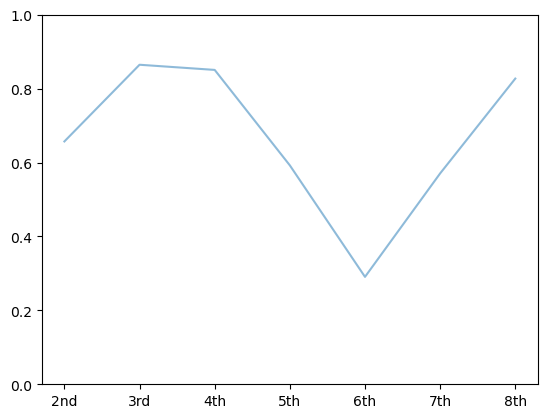

7 <class 'int'>


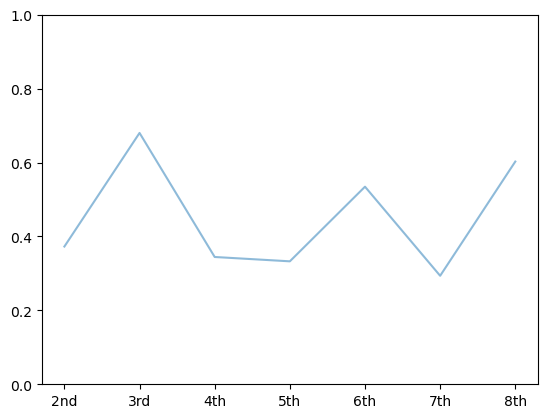

7 <class 'int'>


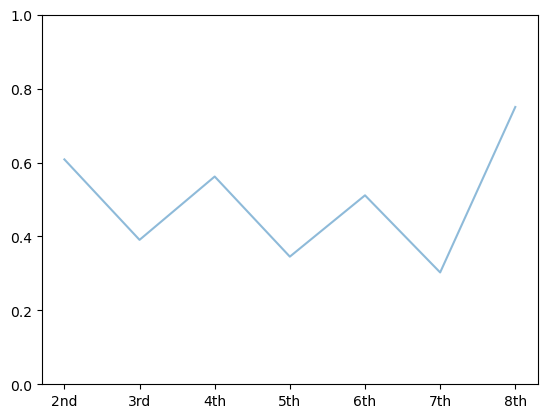

7 <class 'int'>


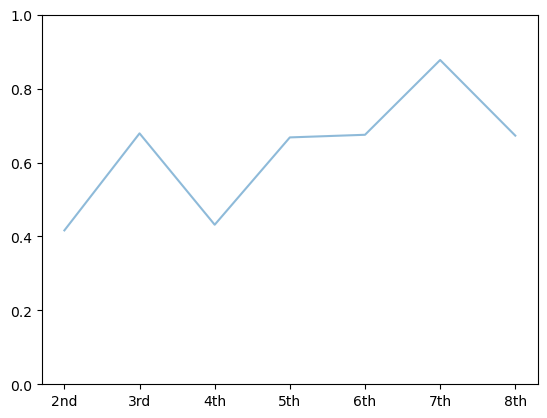

7 <class 'int'>


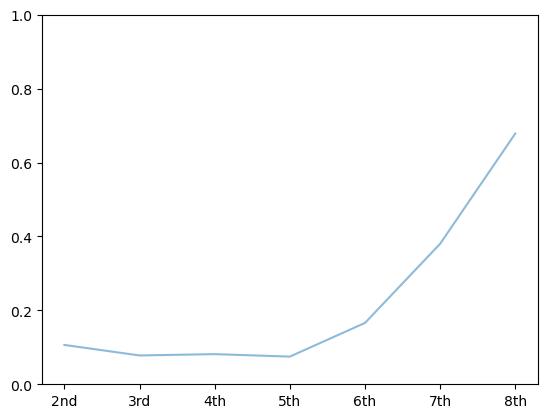

7 <class 'int'>


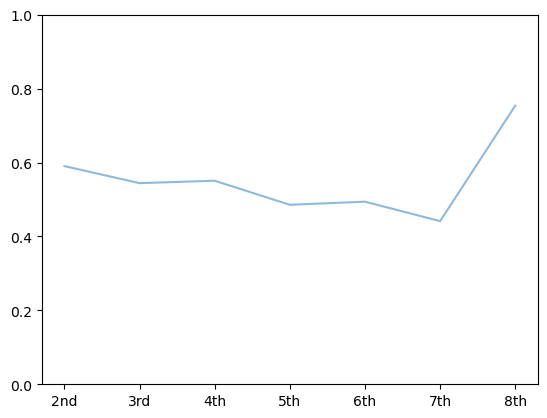

7 <class 'int'>


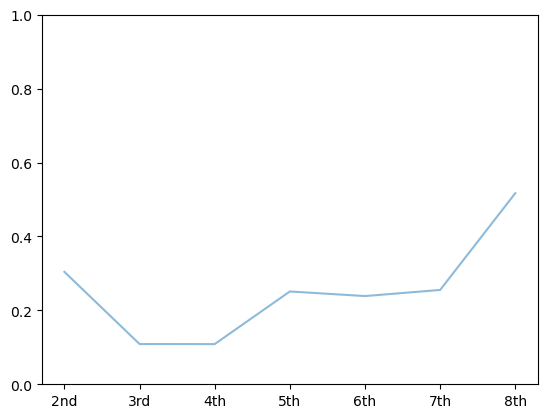

7 <class 'int'>


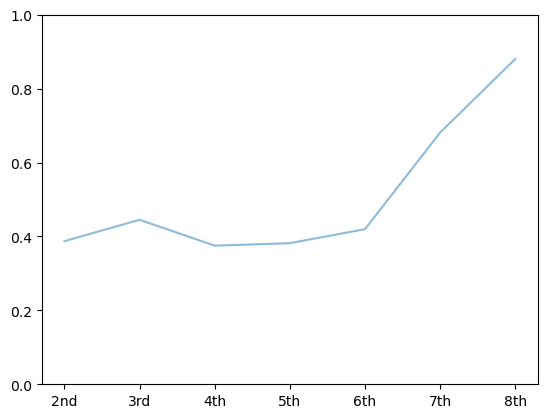

7 <class 'int'>


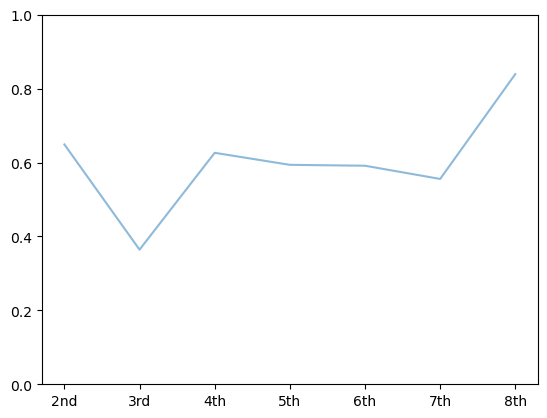

7 <class 'int'>


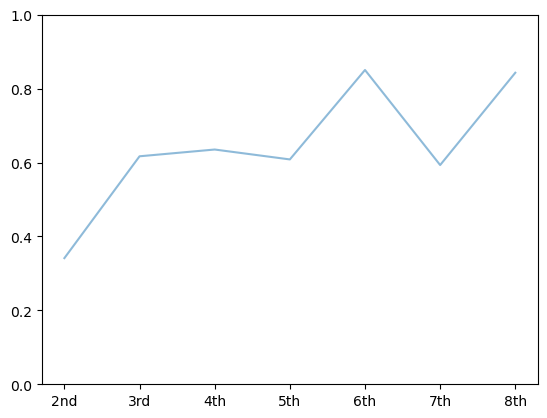

7 <class 'int'>


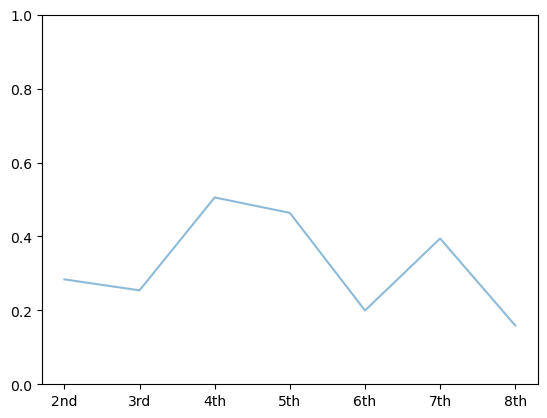

7 <class 'int'>


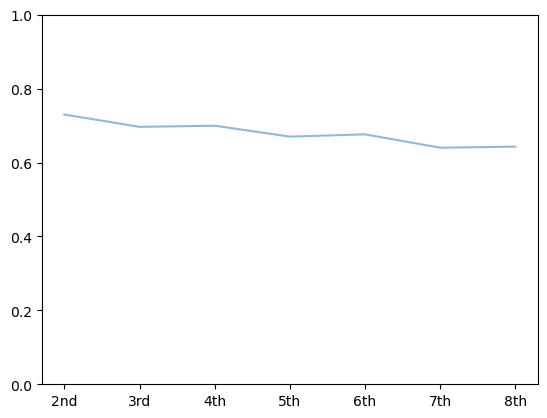

7 <class 'int'>


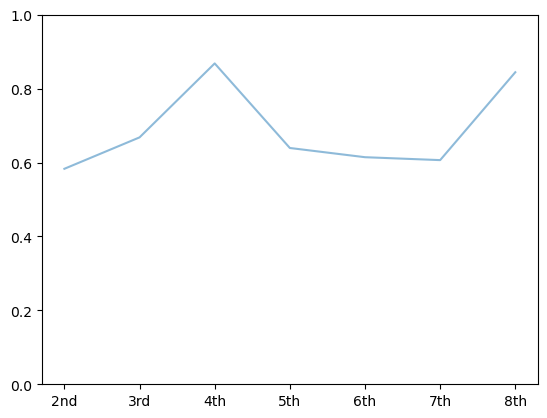

7 <class 'int'>


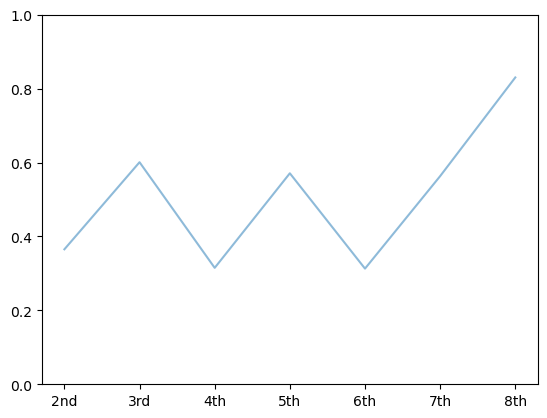

7 <class 'int'>


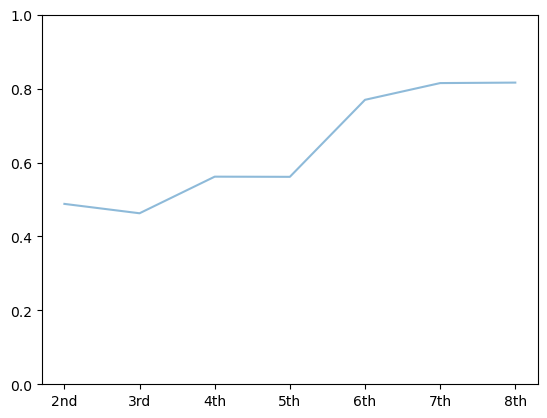

7 <class 'int'>


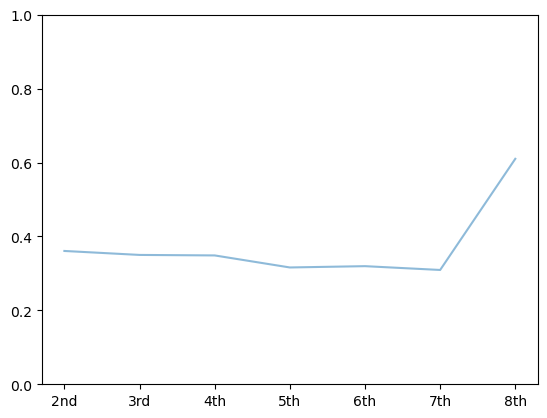

7 <class 'int'>


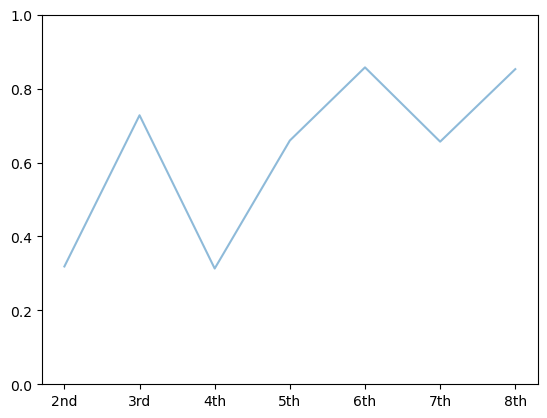

7 <class 'int'>


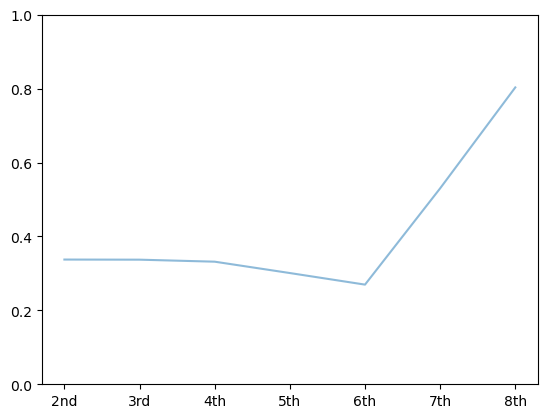

7 <class 'int'>


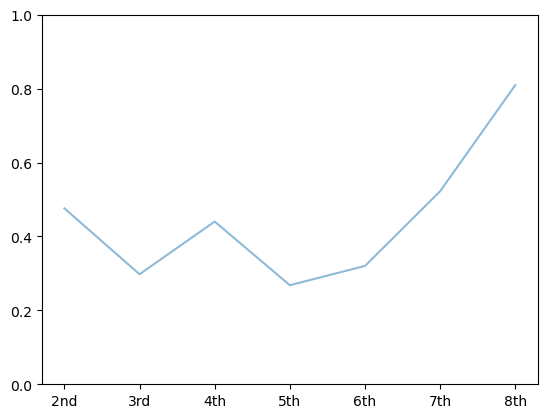

7 <class 'int'>


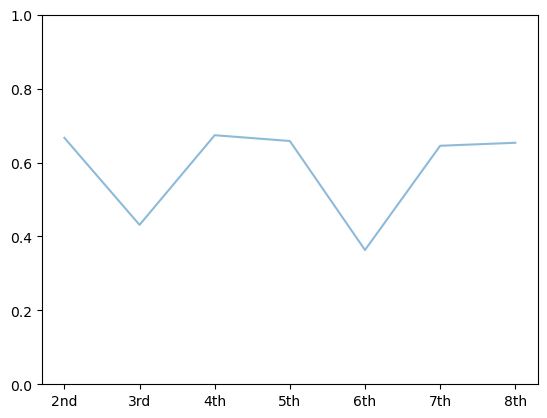

7 <class 'int'>


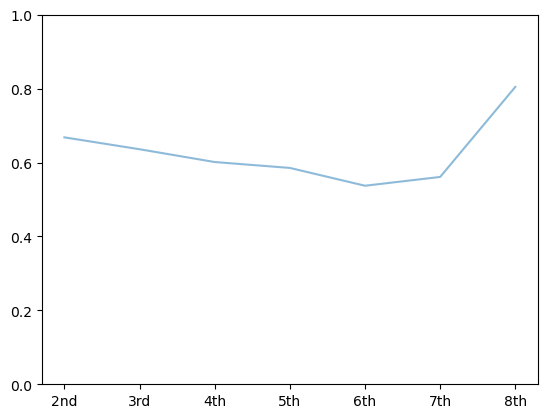

7 <class 'int'>


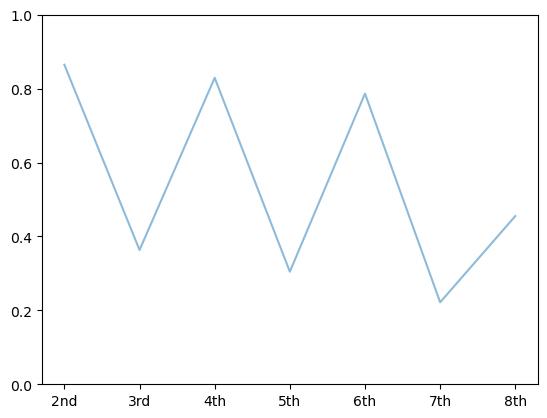

7 <class 'int'>


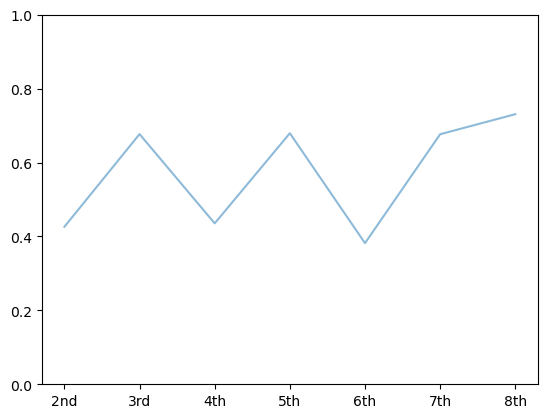

7 <class 'int'>


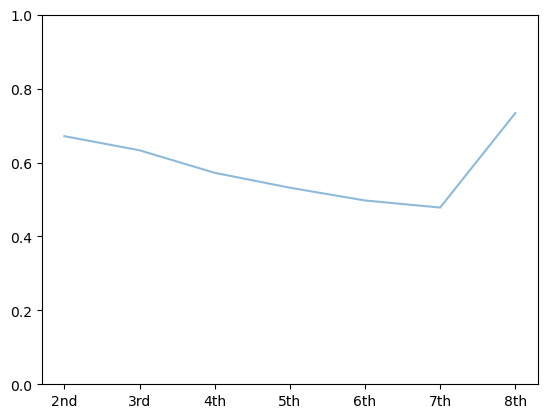

7 <class 'int'>


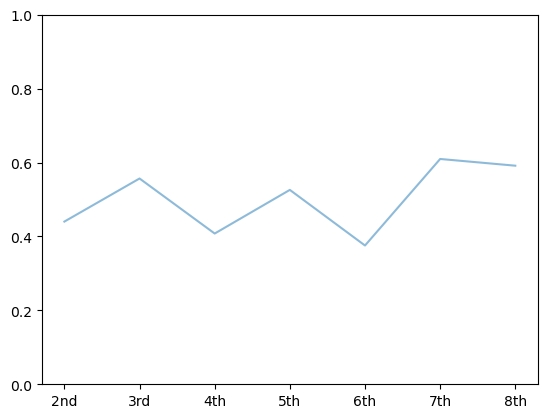

7 <class 'int'>


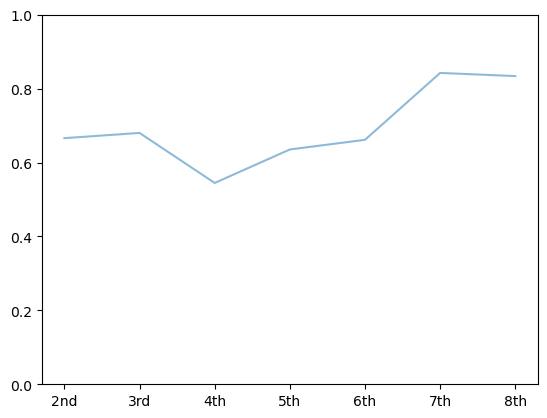

7 <class 'int'>


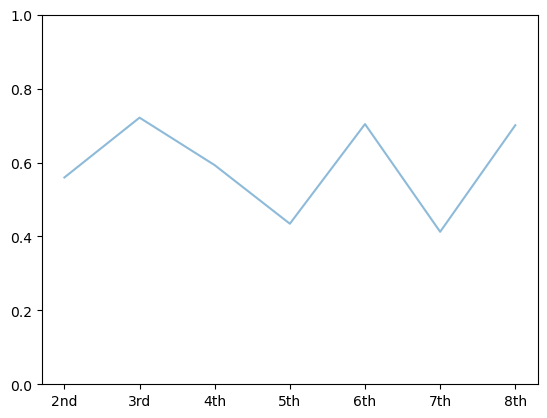

7 <class 'int'>


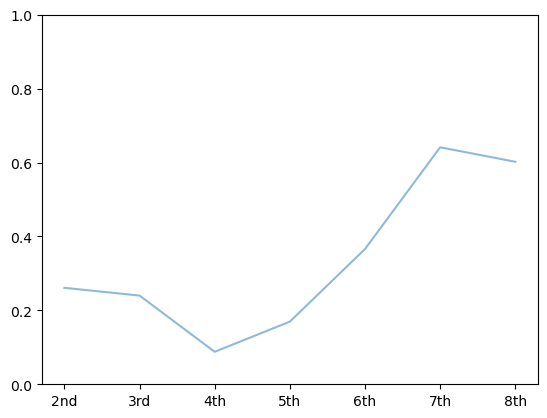

7 <class 'int'>


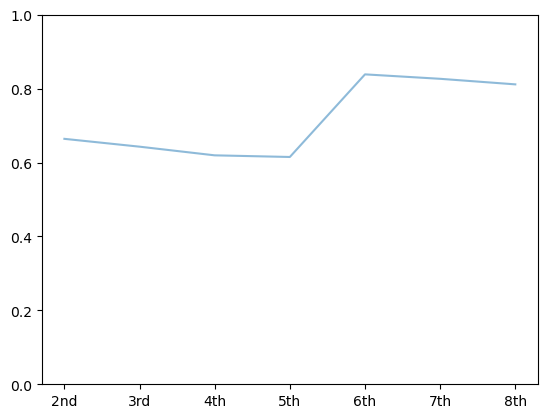

7 <class 'int'>


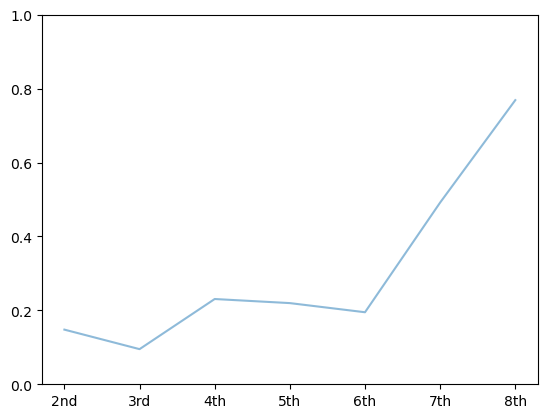

7 <class 'int'>


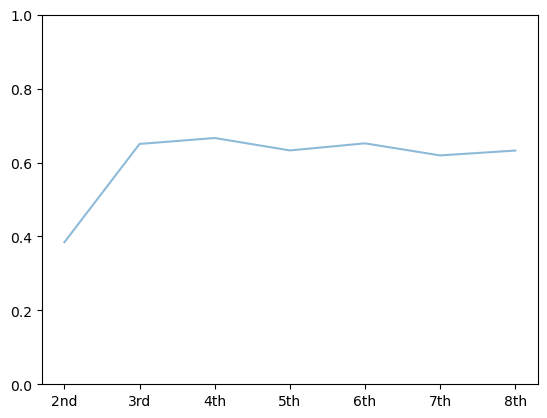

7 <class 'int'>


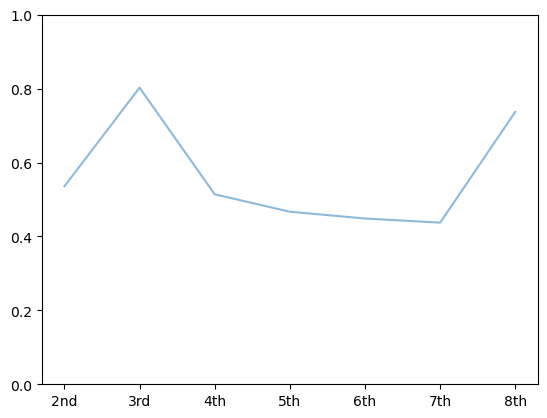

7 <class 'int'>


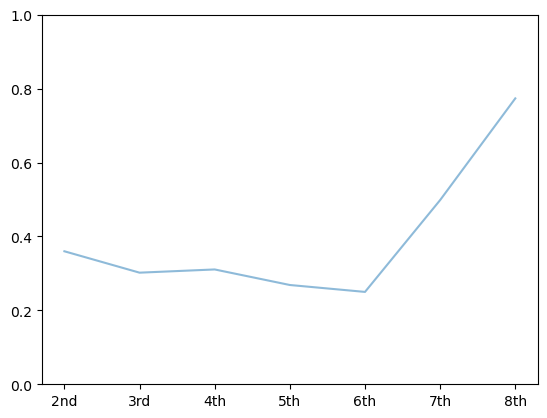

7 <class 'int'>


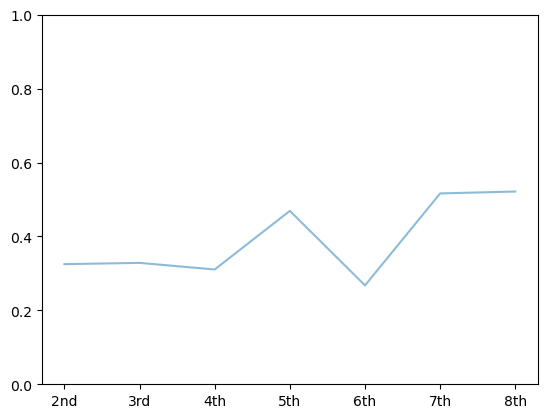

7 <class 'int'>


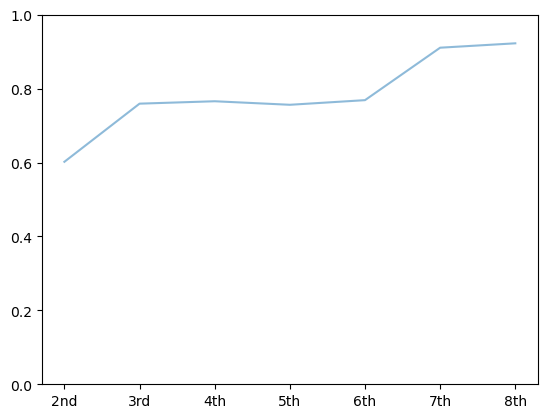

7 <class 'int'>


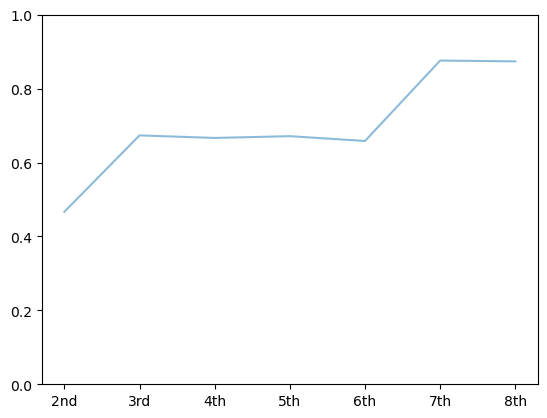

7 <class 'int'>


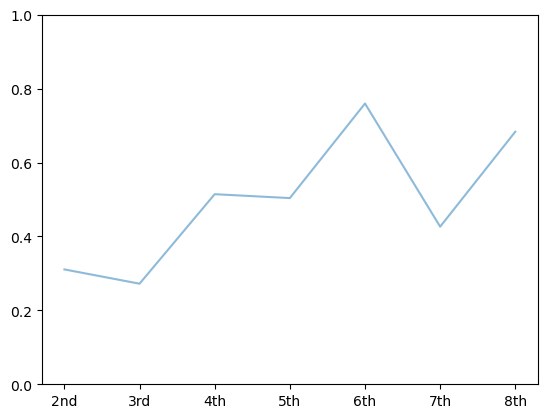

7 <class 'int'>


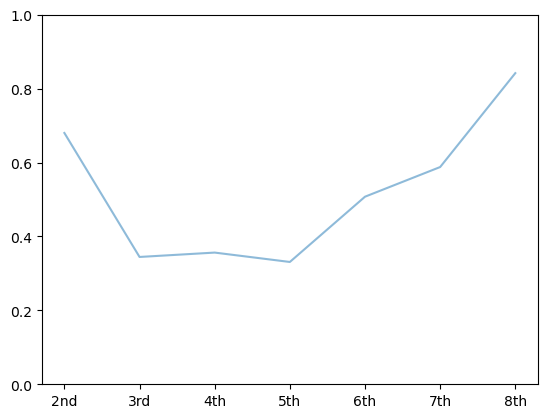

7 <class 'int'>


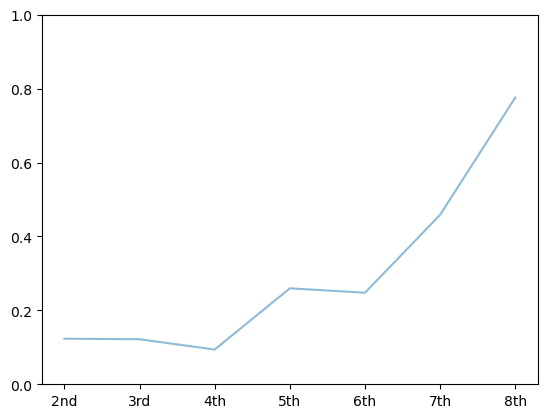

7 <class 'int'>


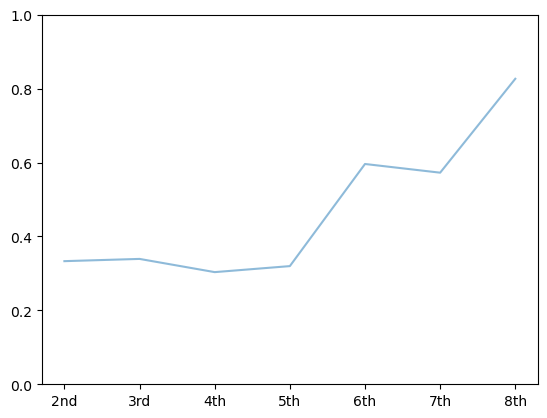

7 <class 'int'>


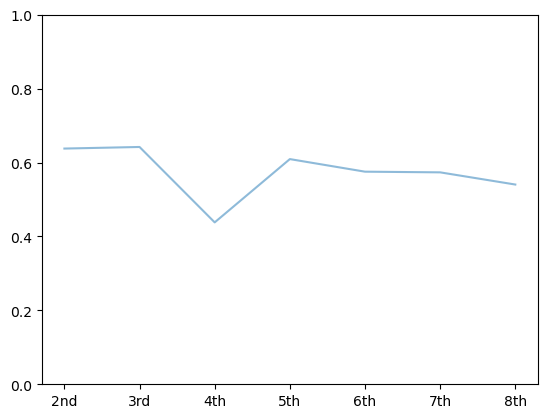

7 <class 'int'>


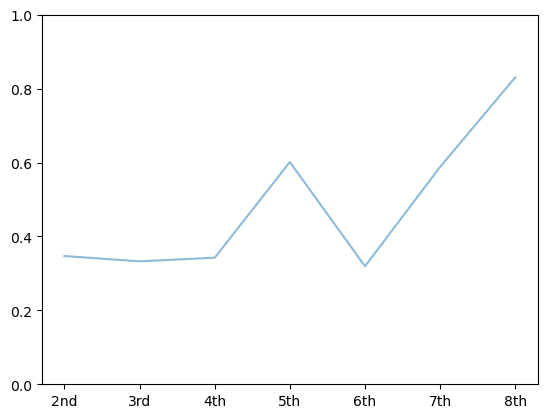

7 <class 'int'>


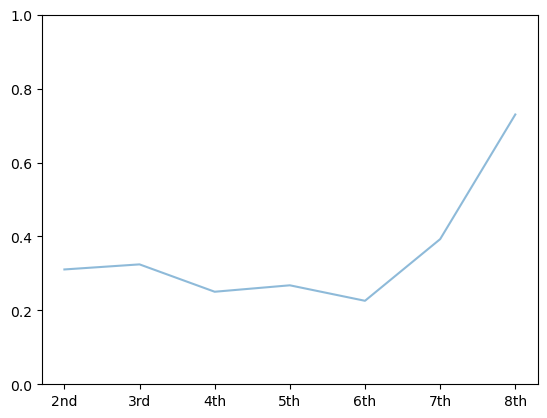

7 <class 'int'>


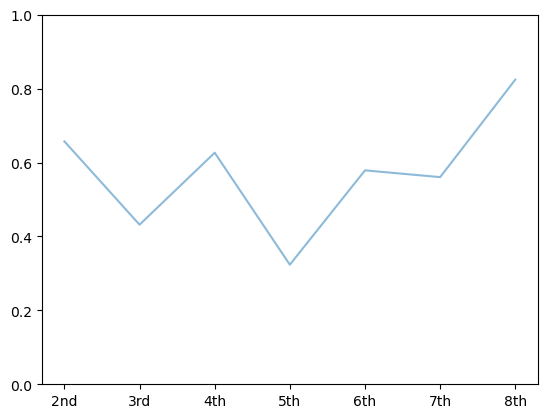

7 <class 'int'>


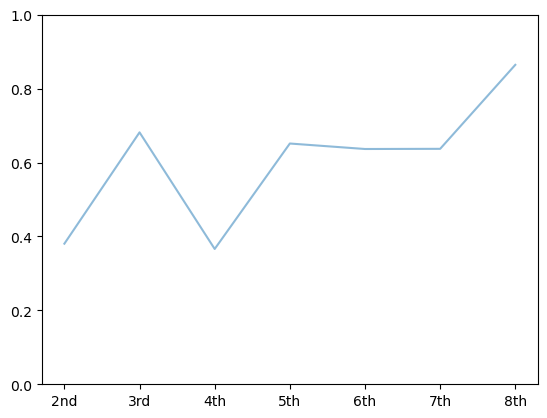

7 <class 'int'>


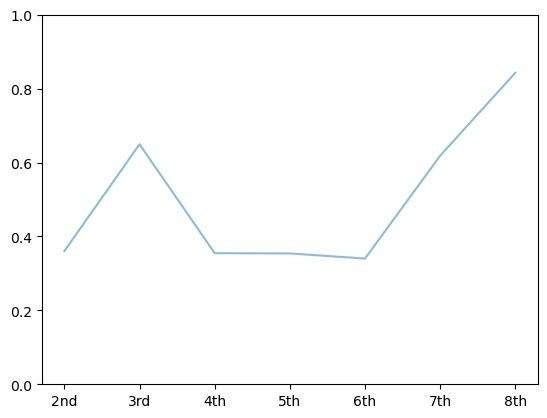

7 <class 'int'>


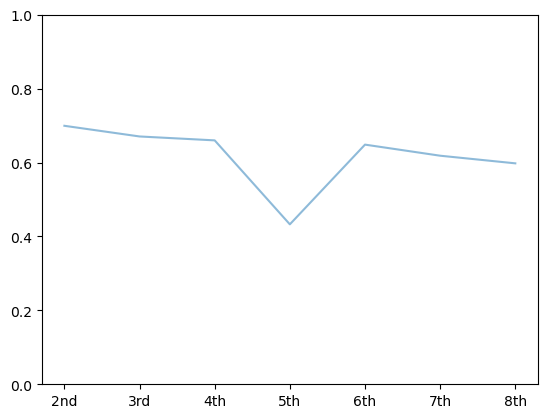

7 <class 'int'>


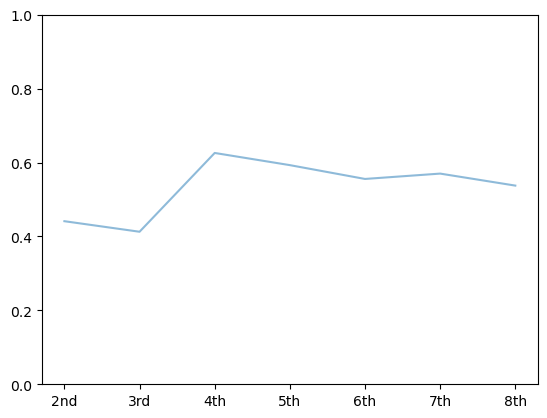

7 <class 'int'>


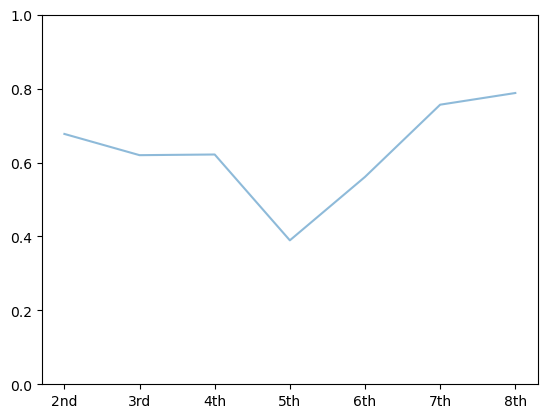

7 <class 'int'>


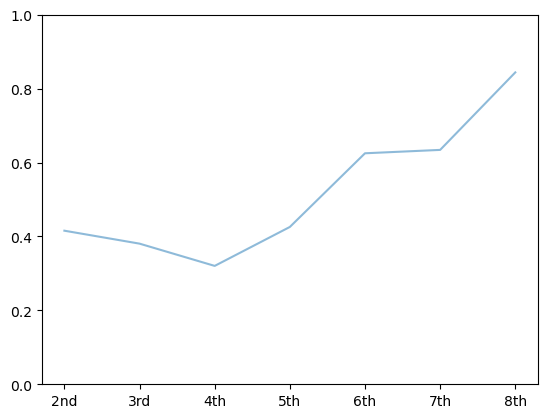

7 <class 'int'>


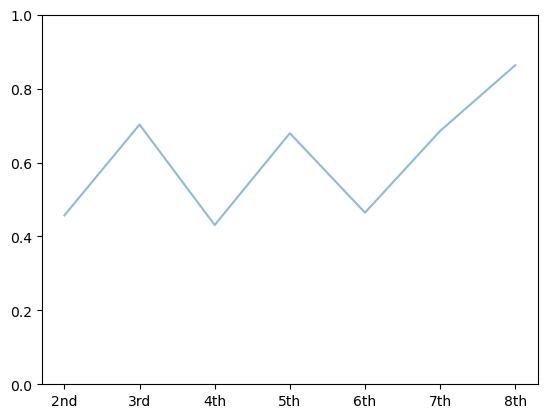

7 <class 'int'>


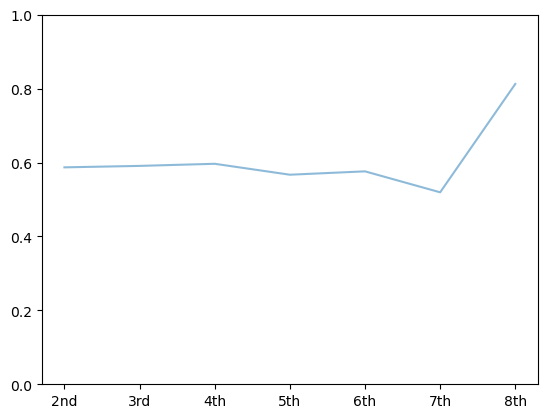

7 <class 'int'>


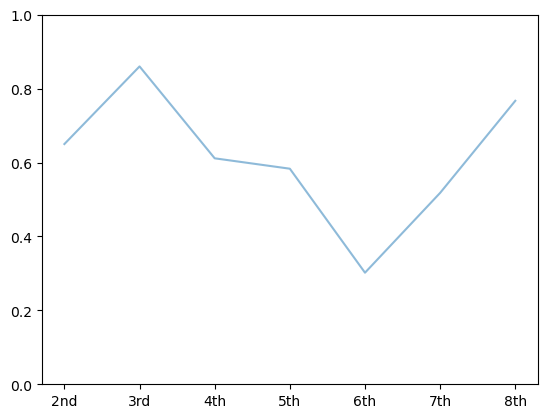

7 <class 'int'>


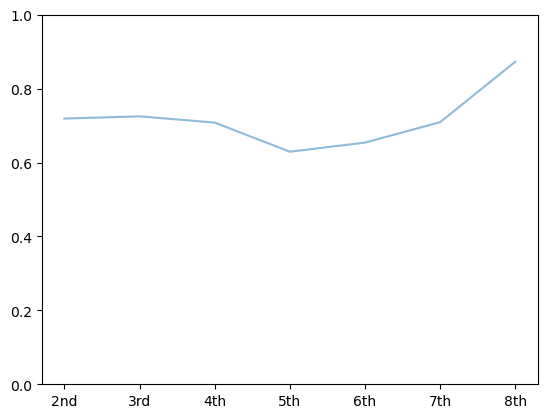

7 <class 'int'>


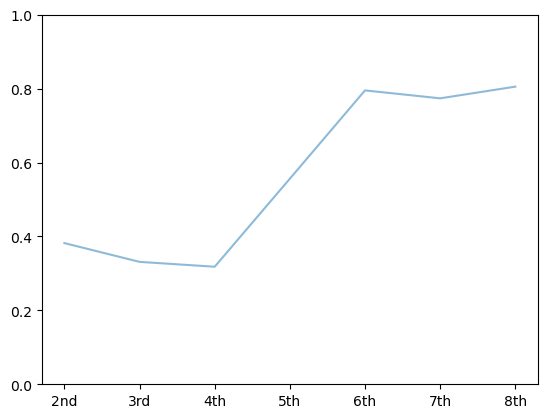

7 <class 'int'>


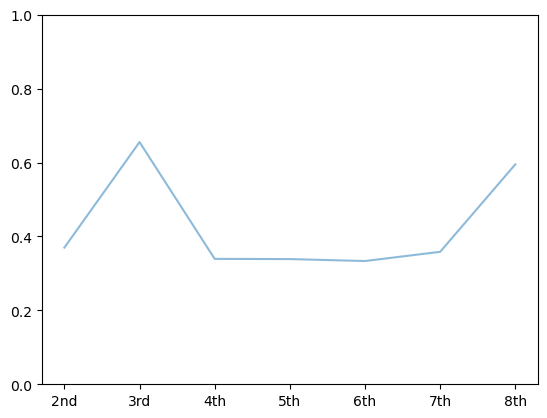

7 <class 'int'>


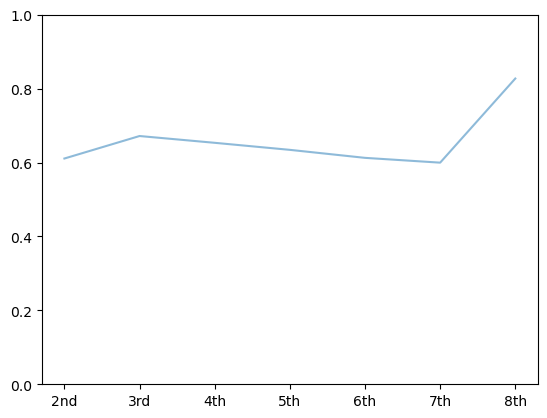

7 <class 'int'>


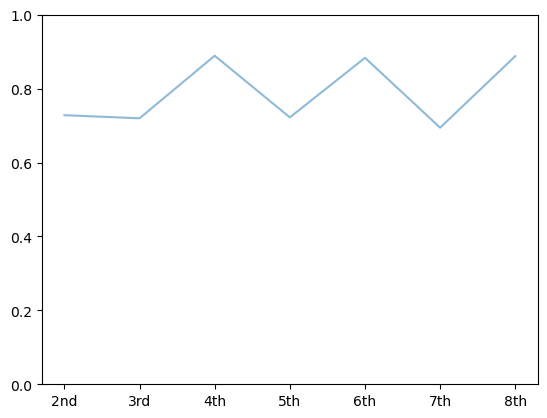

7 <class 'int'>


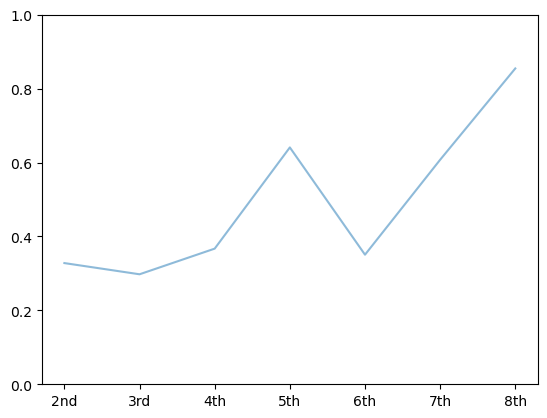

7 <class 'int'>


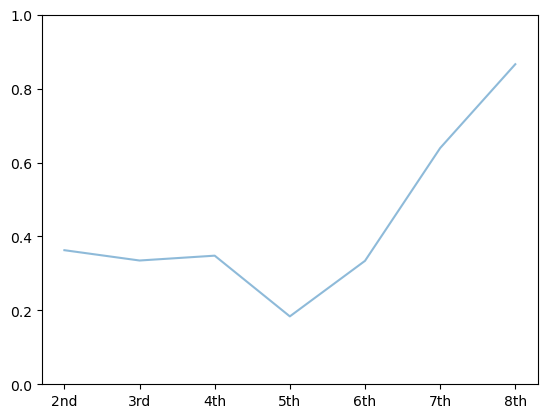

7 <class 'int'>


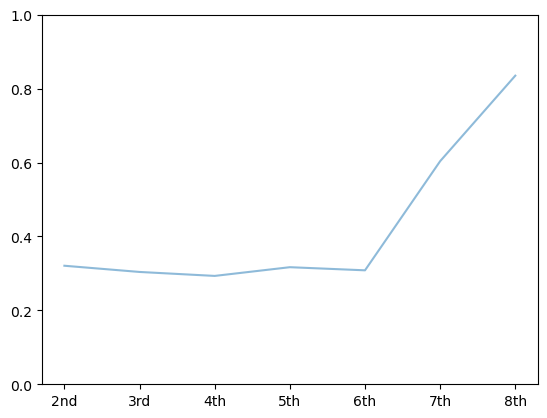

7 <class 'int'>


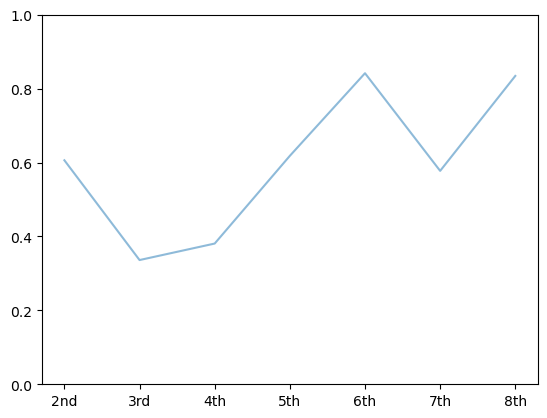

7 <class 'int'>


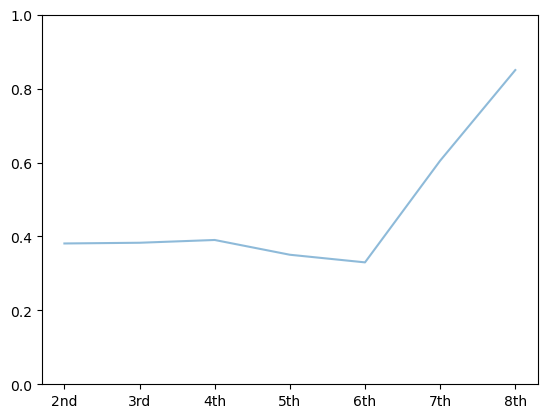

7 <class 'int'>


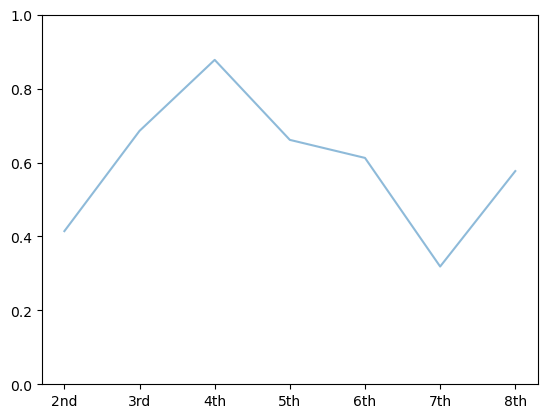

7 <class 'int'>


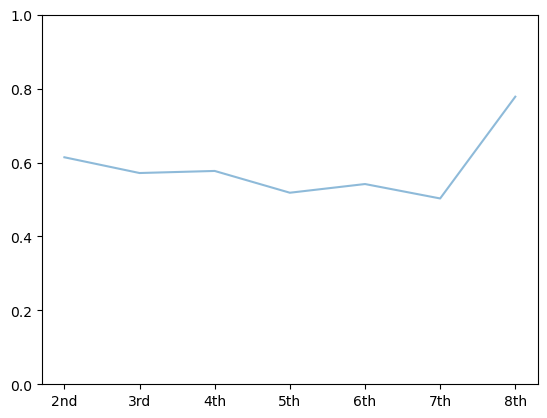

7 <class 'int'>


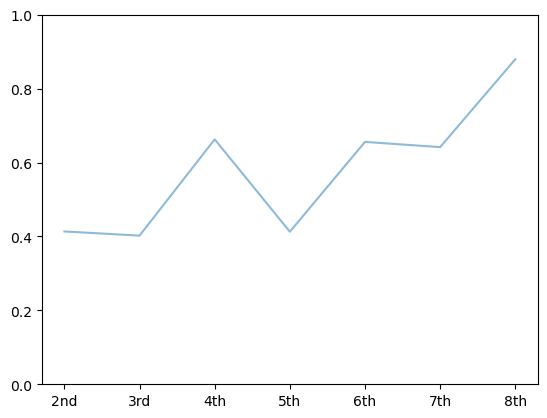

7 <class 'int'>


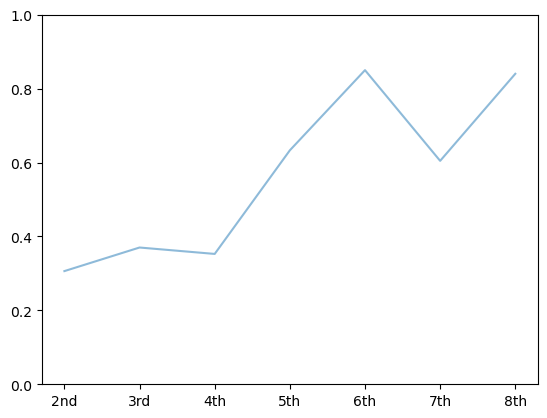

7 <class 'int'>


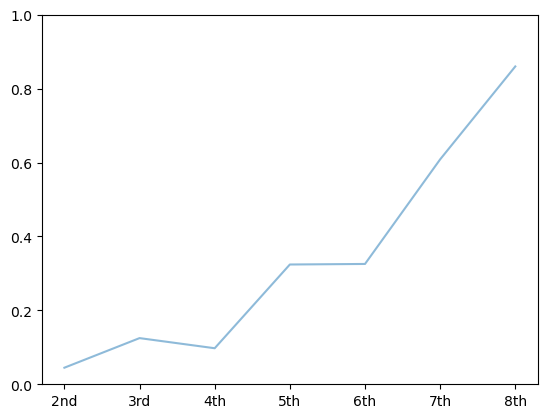

7 <class 'int'>


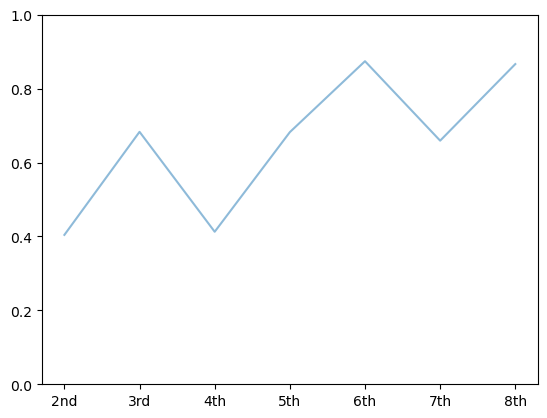

7 <class 'int'>


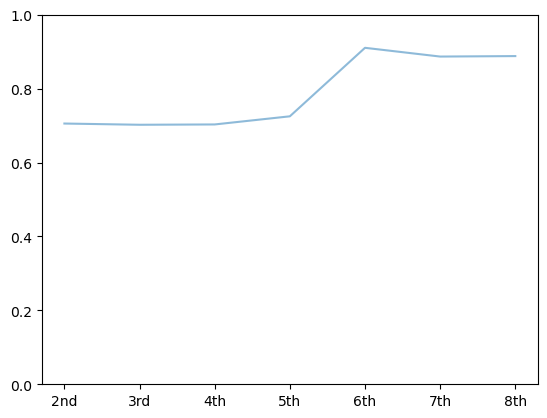

7 <class 'int'>


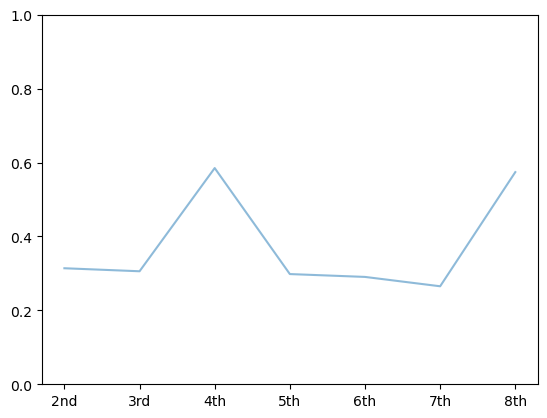

7 <class 'int'>


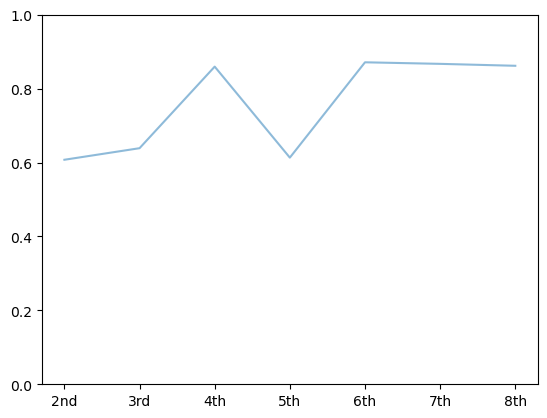

7 <class 'int'>


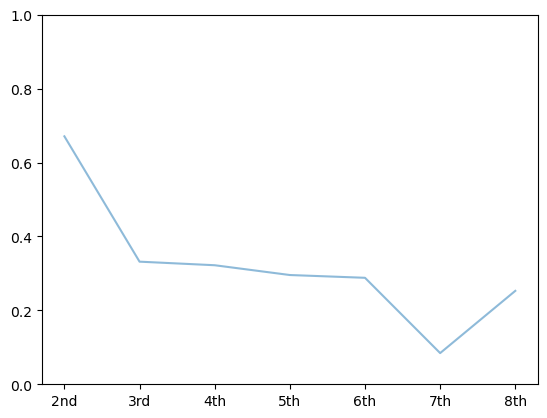

7 <class 'int'>


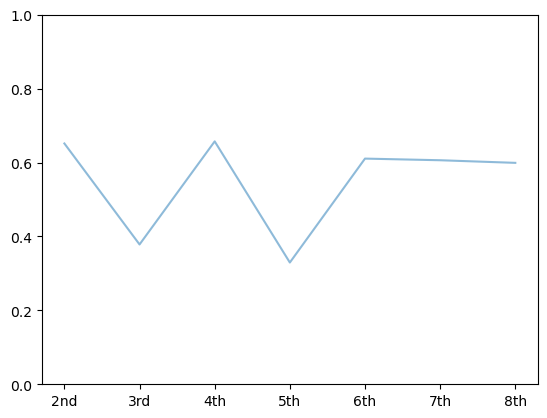

7 <class 'int'>


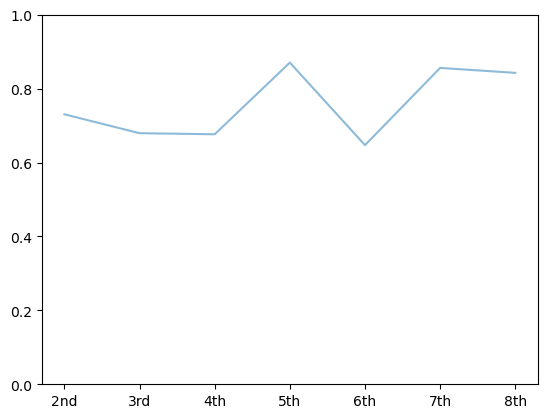

7 <class 'int'>


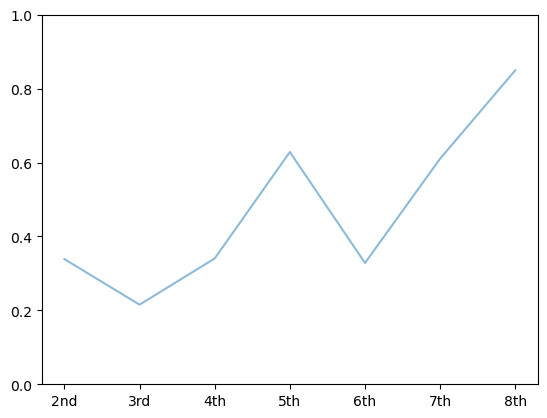

7 <class 'int'>


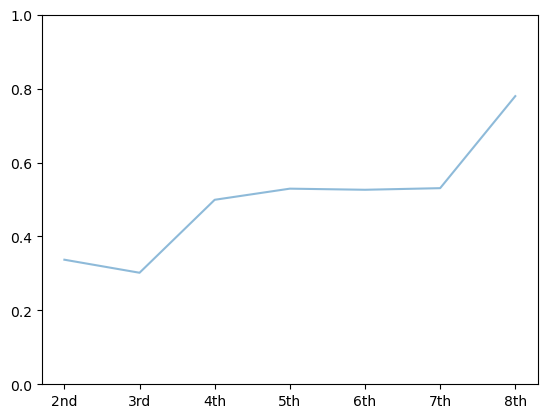

7 <class 'int'>


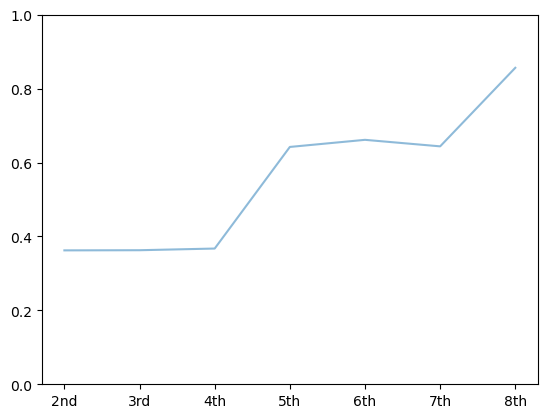

7 <class 'int'>


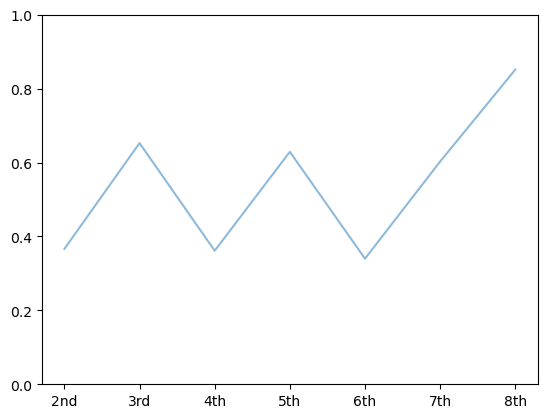

7 <class 'int'>


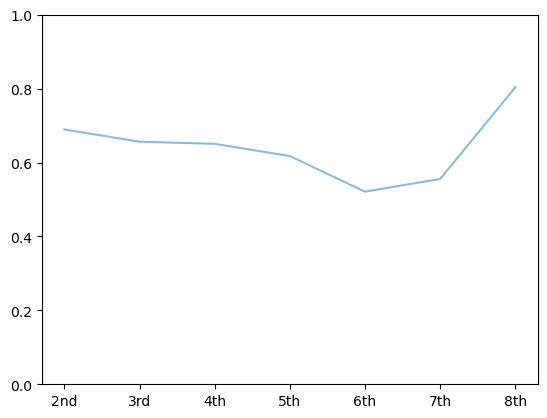

7 <class 'int'>


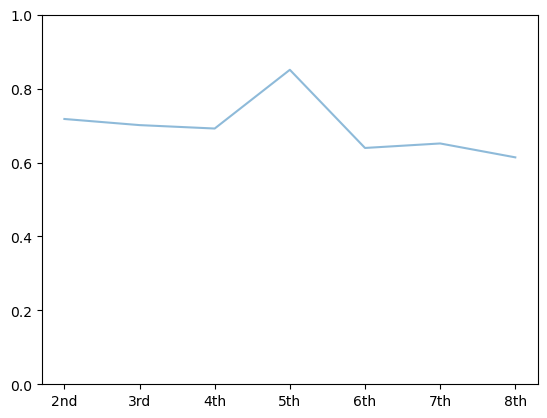

7 <class 'int'>


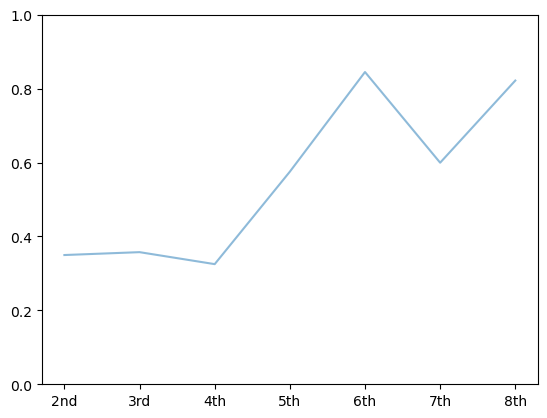

7 <class 'int'>


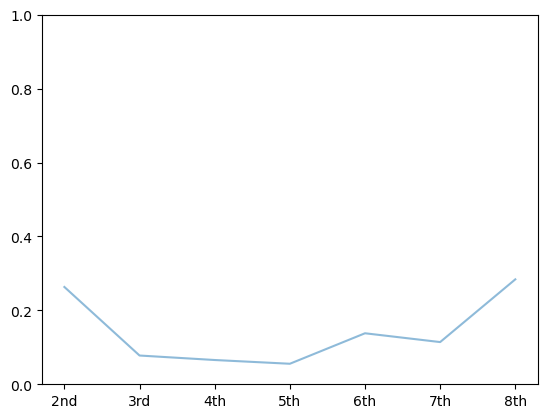

7 <class 'int'>


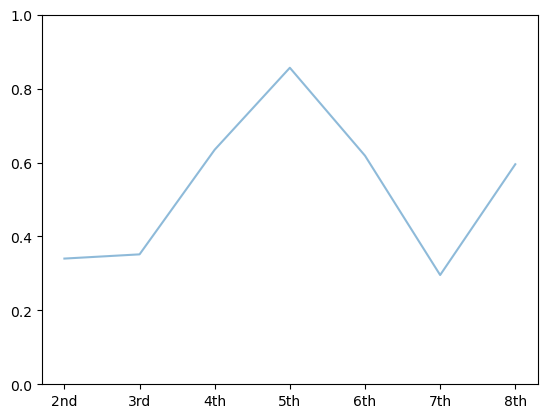

7 <class 'int'>


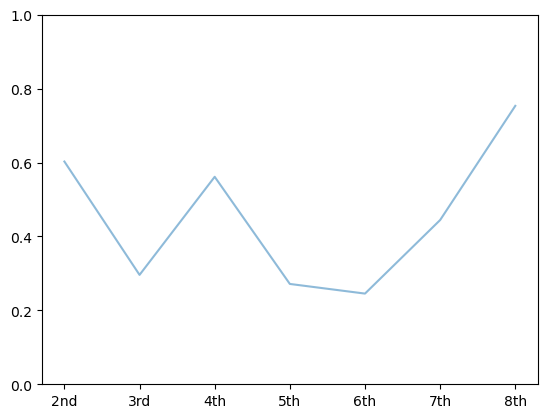

7 <class 'int'>


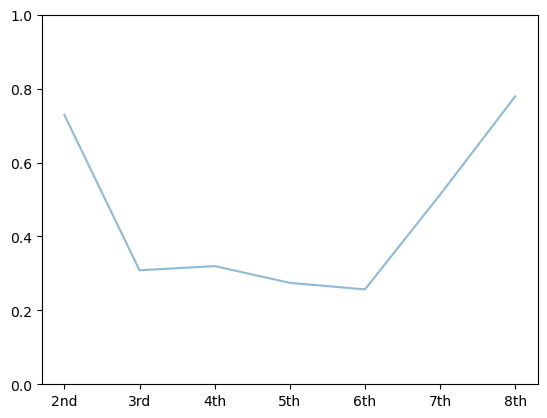

7 <class 'int'>


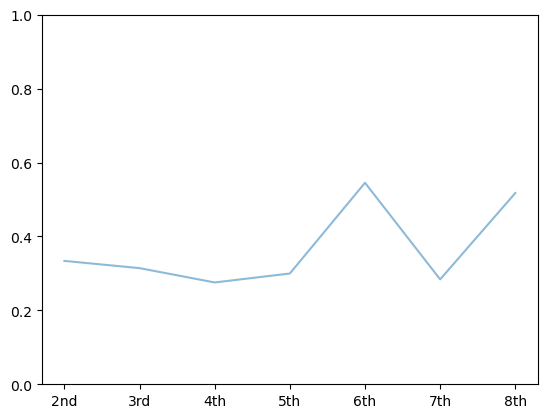

7 <class 'int'>


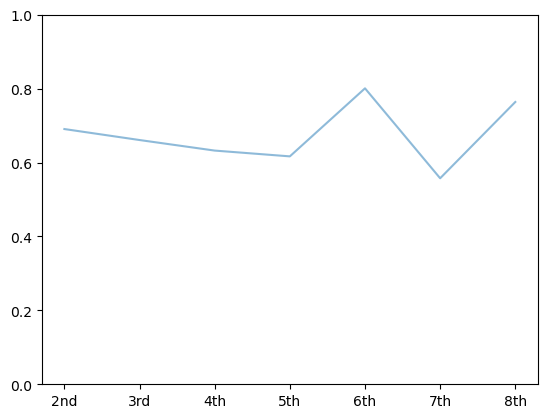

7 <class 'int'>


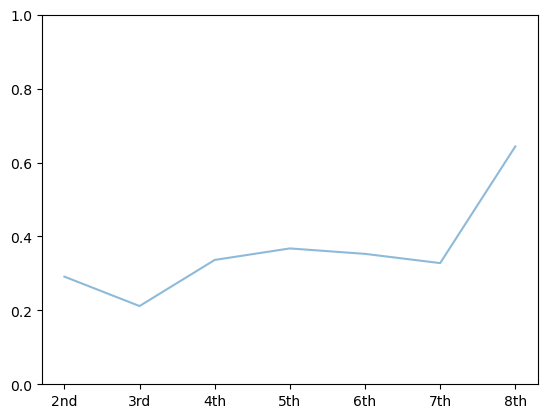

7 <class 'int'>


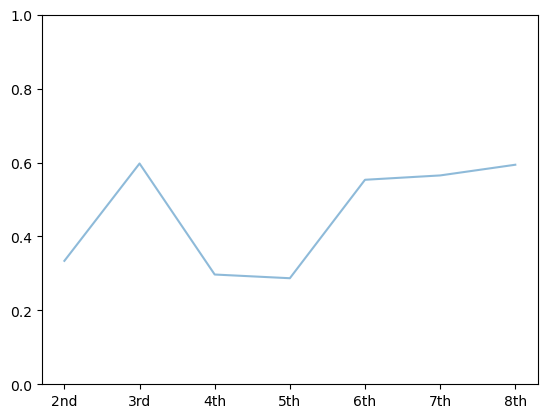

7 <class 'int'>


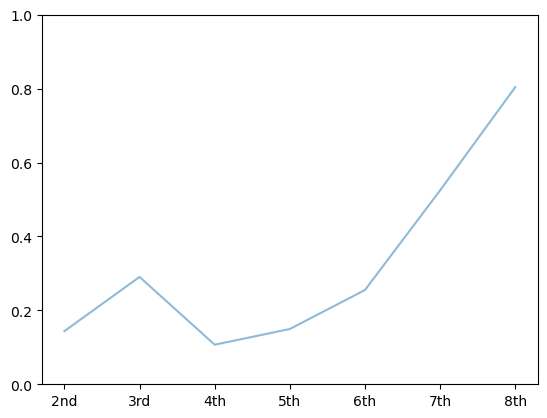

7 <class 'int'>


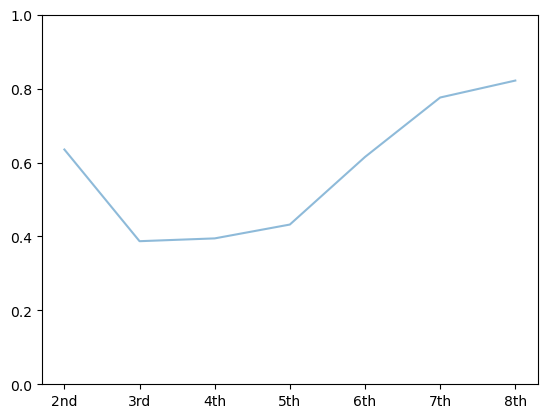

7 <class 'int'>


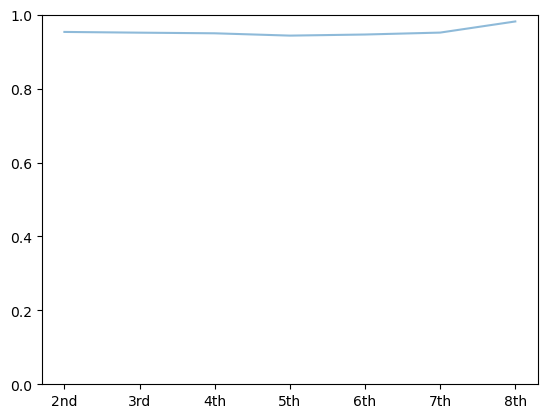

7 <class 'int'>


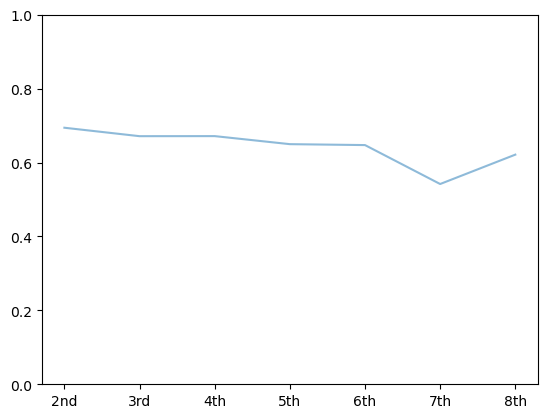

7 <class 'int'>


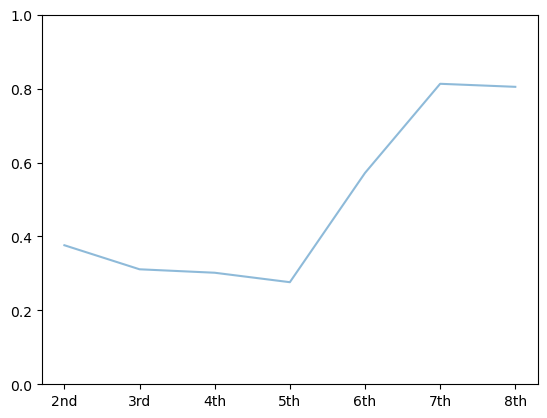

7 <class 'int'>


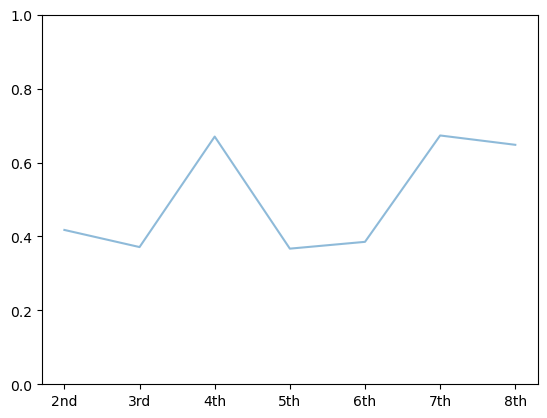

7 <class 'int'>


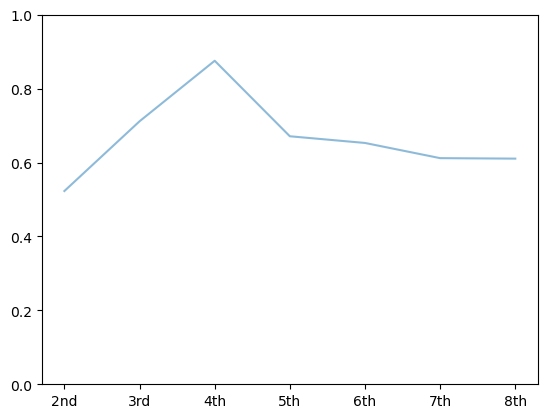

7 <class 'int'>


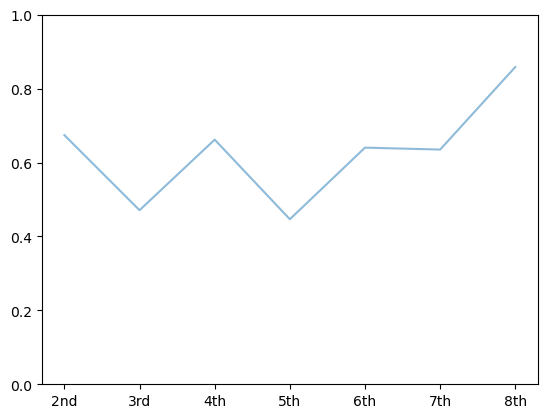

7 <class 'int'>


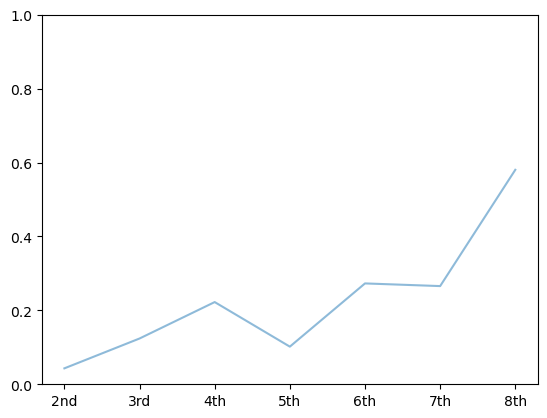

7 <class 'int'>


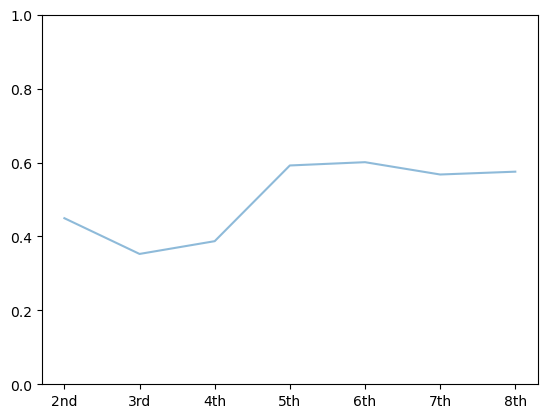

7 <class 'int'>


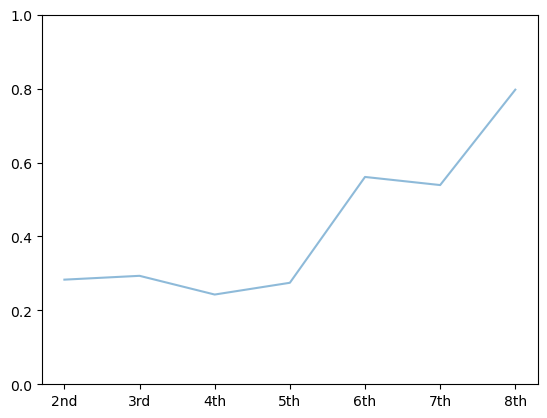

7 <class 'int'>


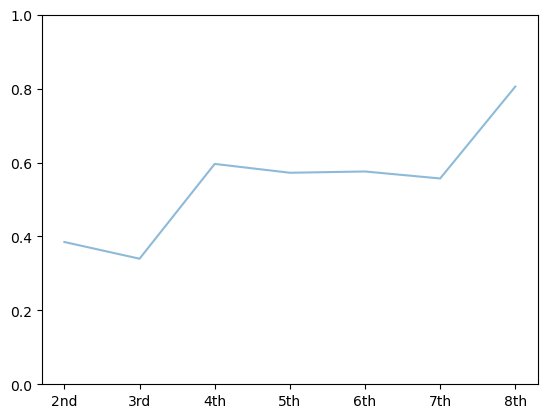

7 <class 'int'>


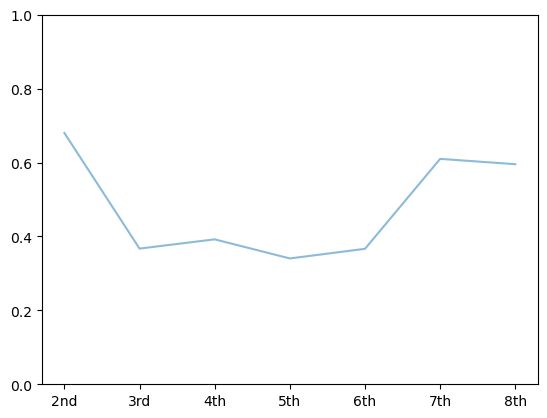

7 <class 'int'>


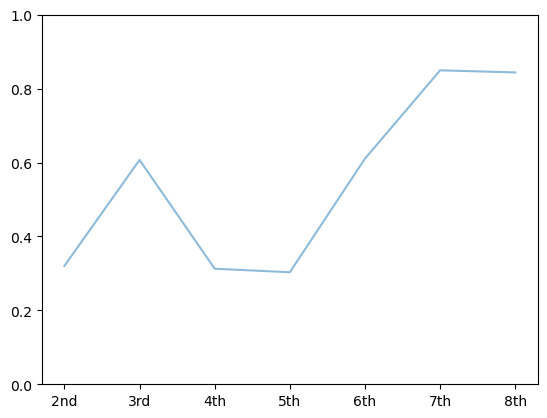

7 <class 'int'>


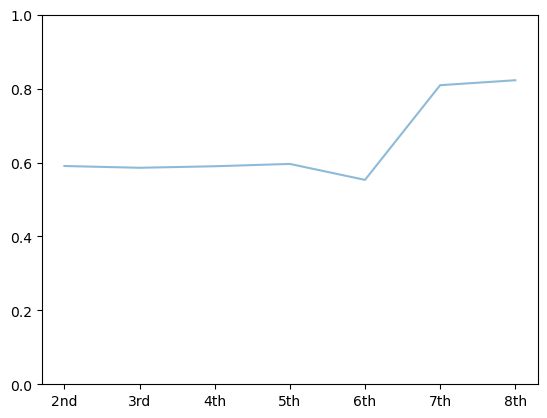

7 <class 'int'>


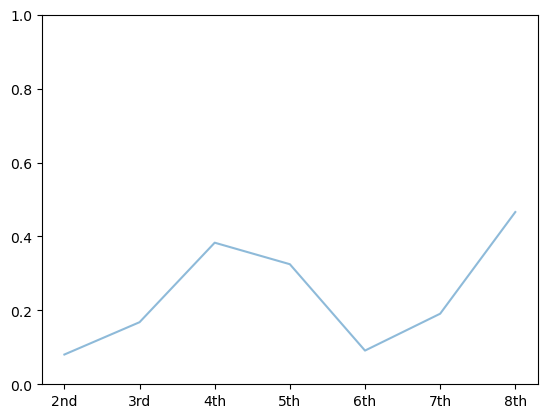

7 <class 'int'>


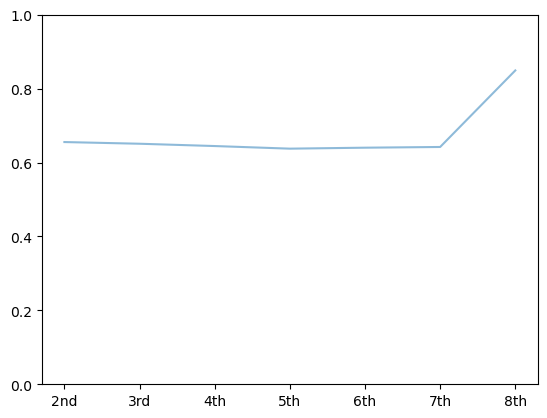

7 <class 'int'>


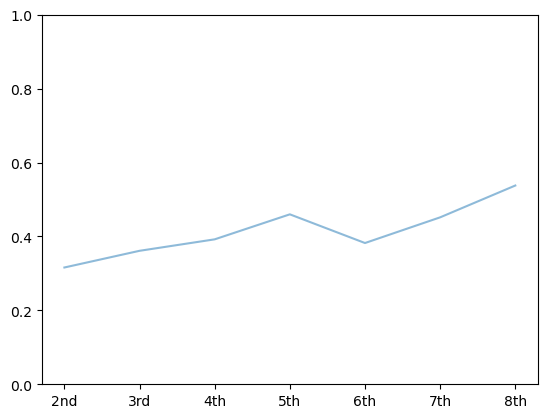

7 <class 'int'>


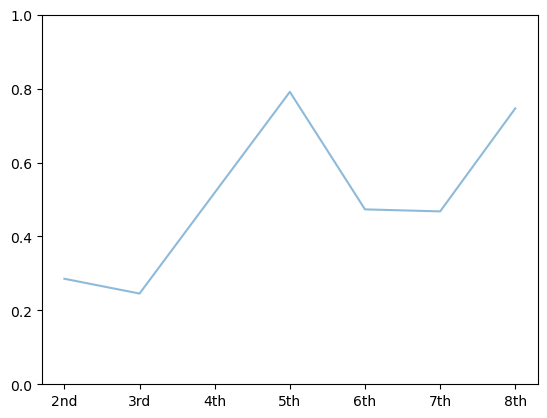

7 <class 'int'>


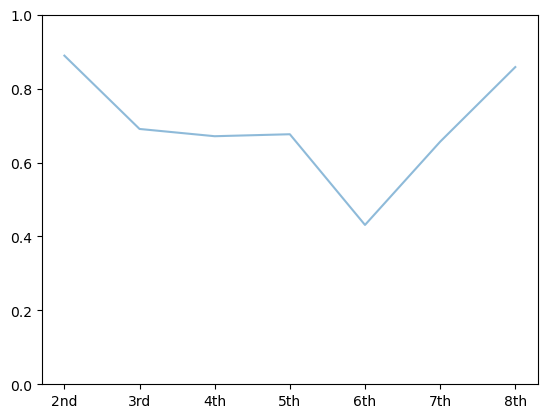

7 <class 'int'>


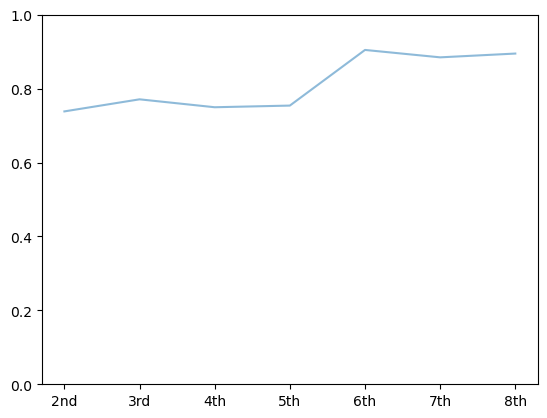

7 <class 'int'>


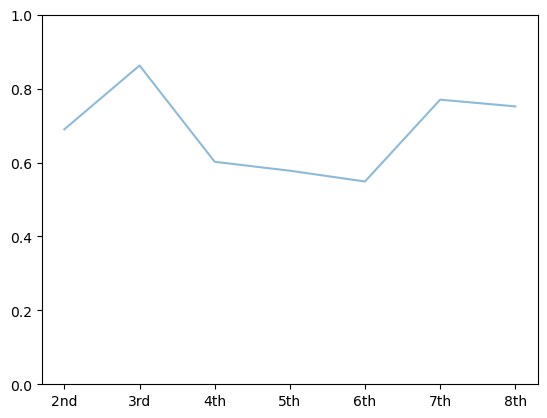

7 <class 'int'>


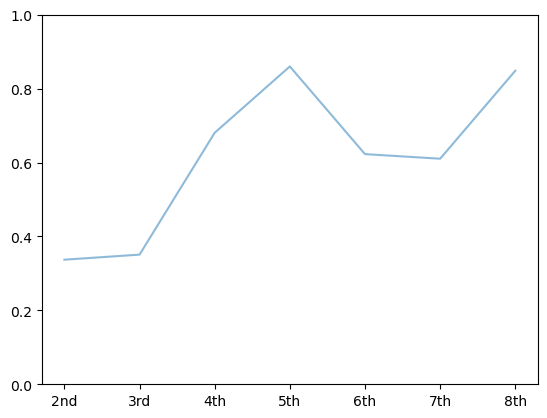

7 <class 'int'>


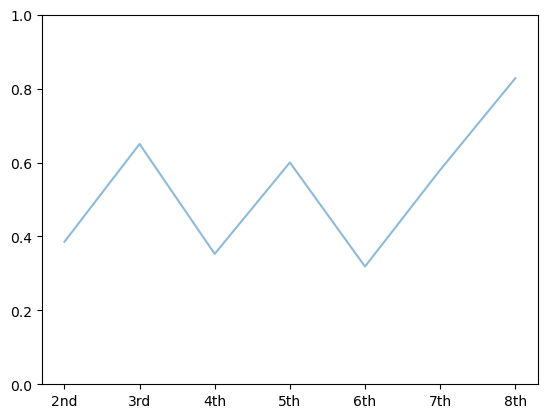

7 <class 'int'>


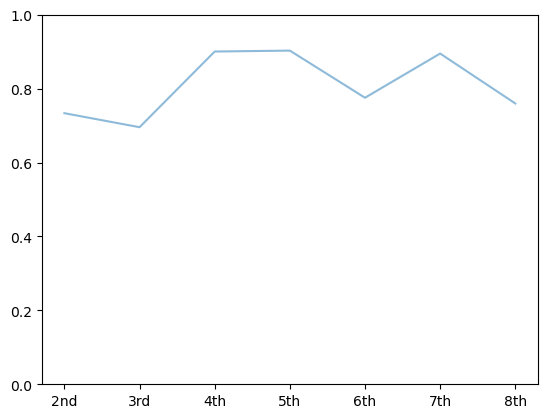

7 <class 'int'>


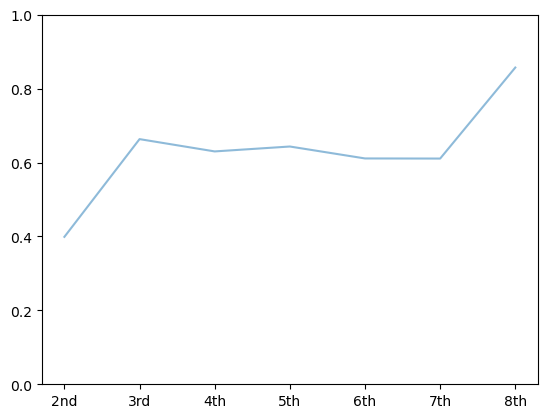

7 <class 'int'>


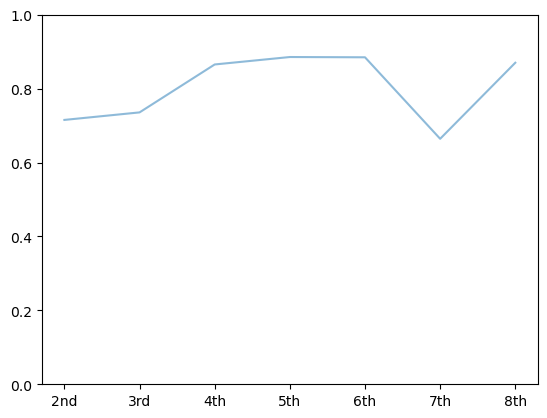

7 <class 'int'>


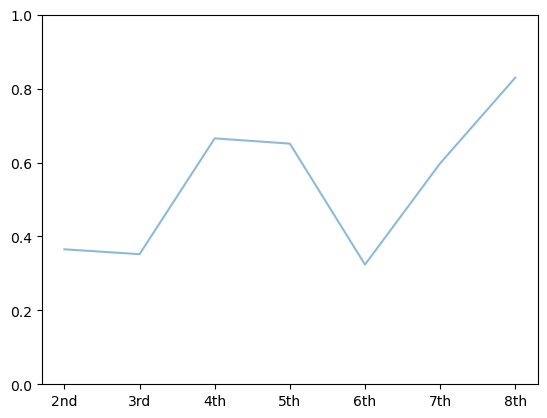

7 <class 'int'>


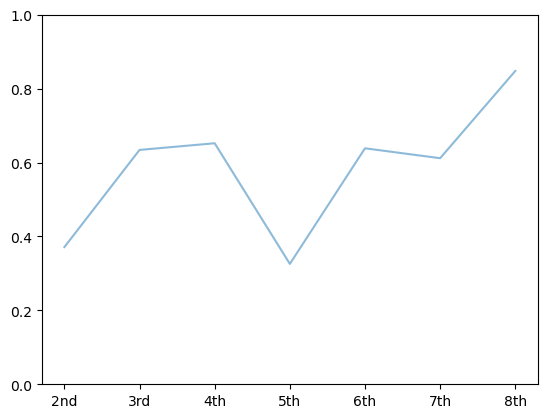

7 <class 'int'>


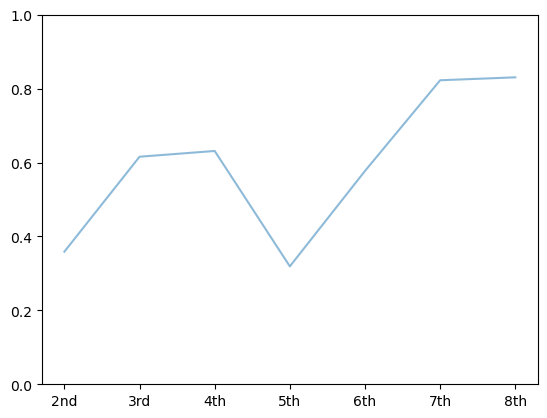

7 <class 'int'>


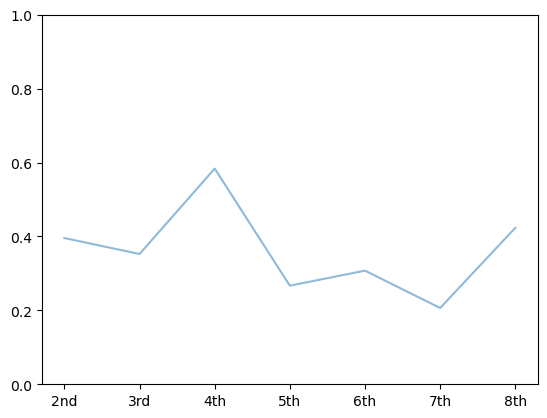

7 <class 'int'>


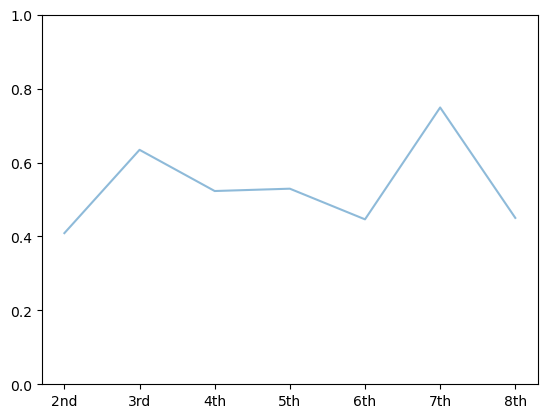

7 <class 'int'>


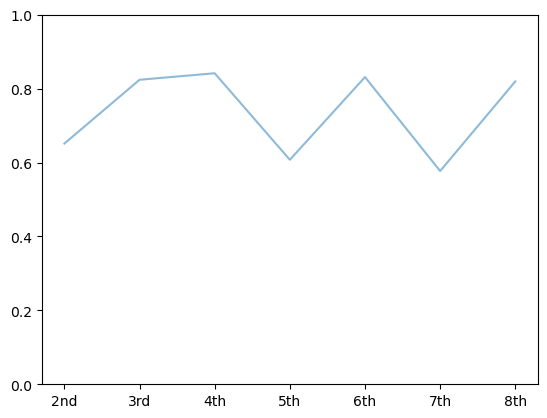

7 <class 'int'>


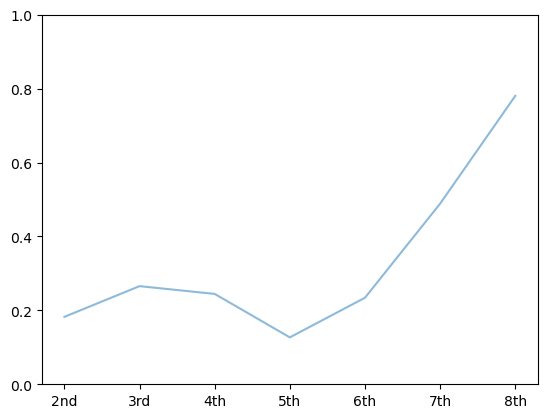

7 <class 'int'>


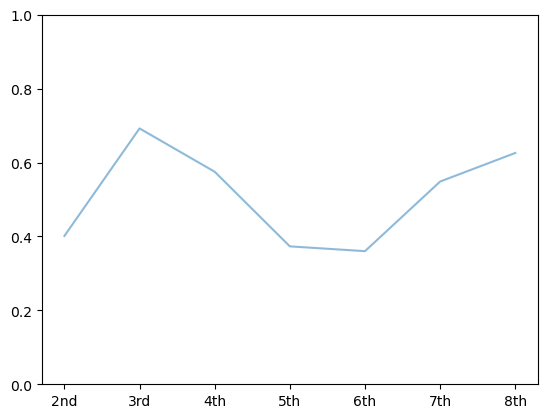

7 <class 'int'>


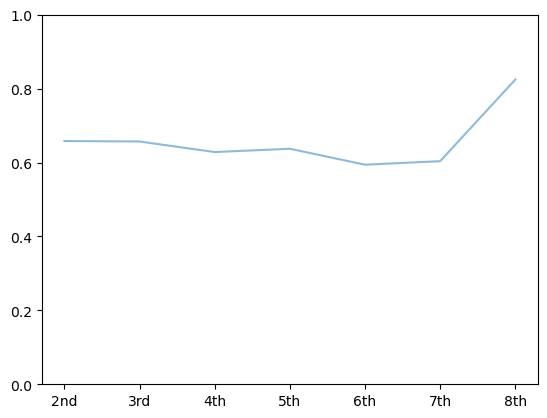

7 <class 'int'>


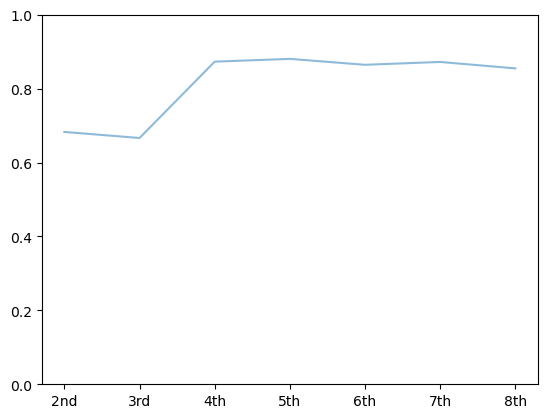

7 <class 'int'>


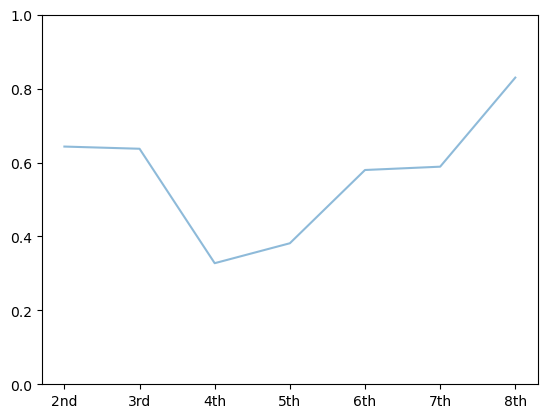

7 <class 'int'>


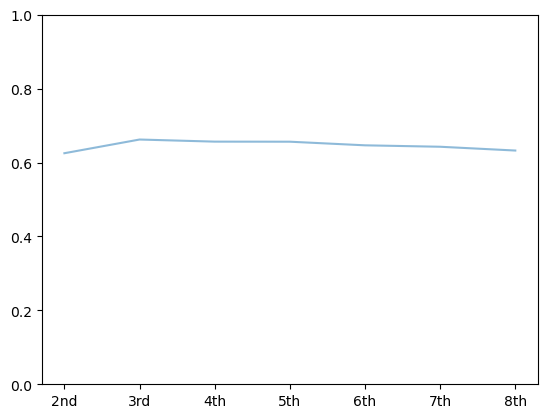

7 <class 'int'>


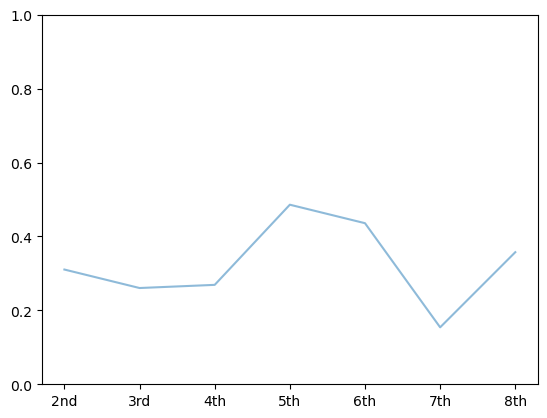

7 <class 'int'>


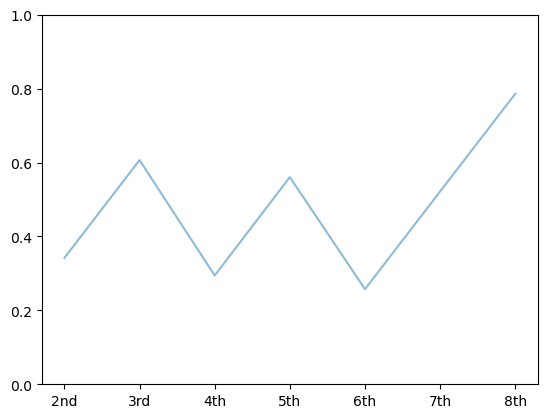

7 <class 'int'>


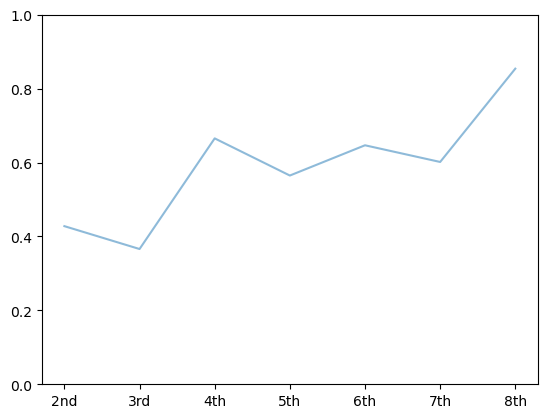

7 <class 'int'>


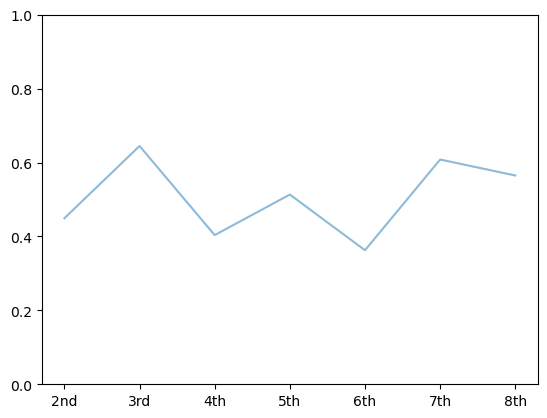

7 <class 'int'>


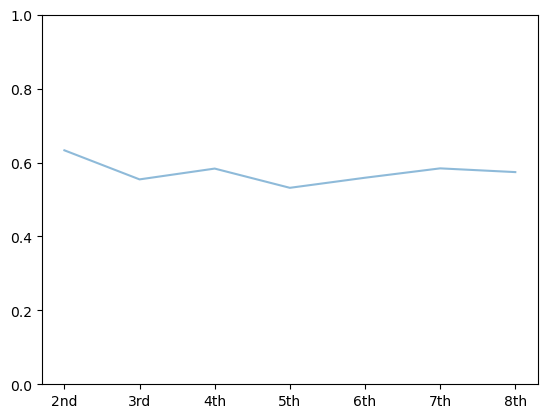

7 <class 'int'>


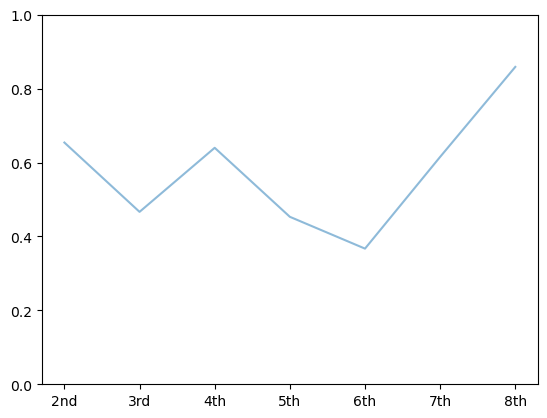

7 <class 'int'>


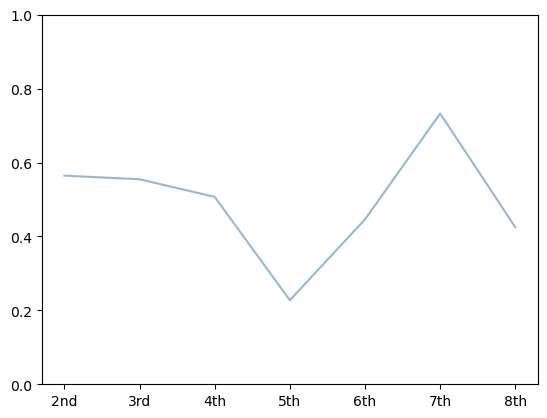

7 <class 'int'>


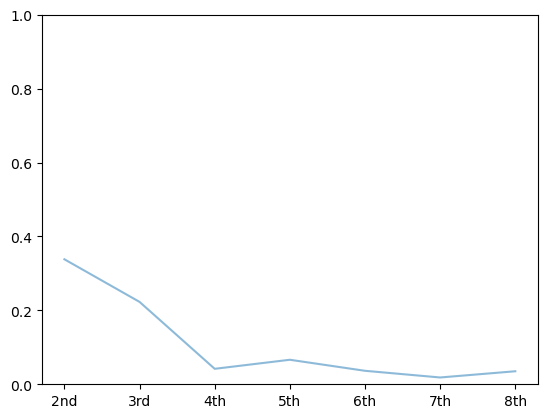

7 <class 'int'>


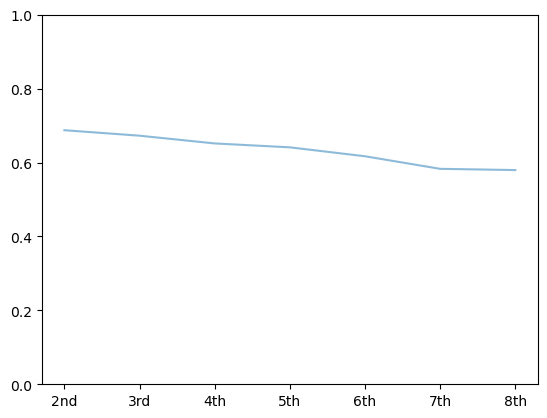

7 <class 'int'>


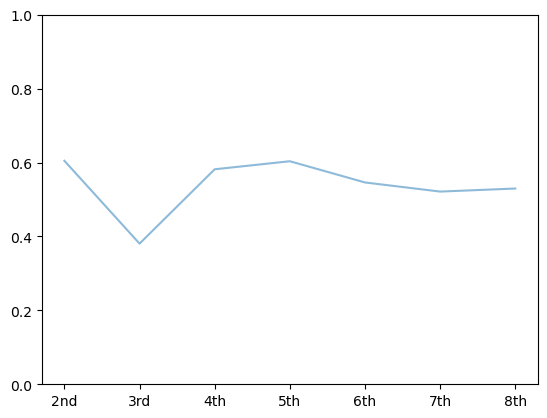

7 <class 'int'>


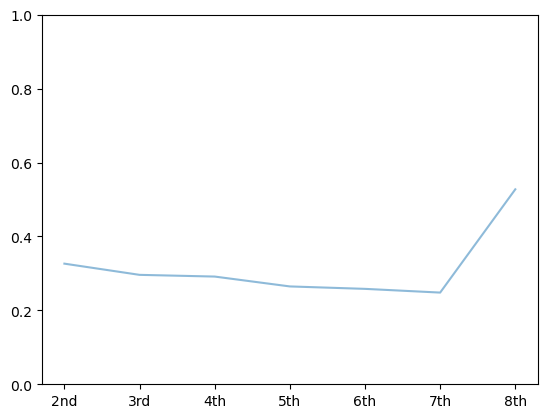

7 <class 'int'>


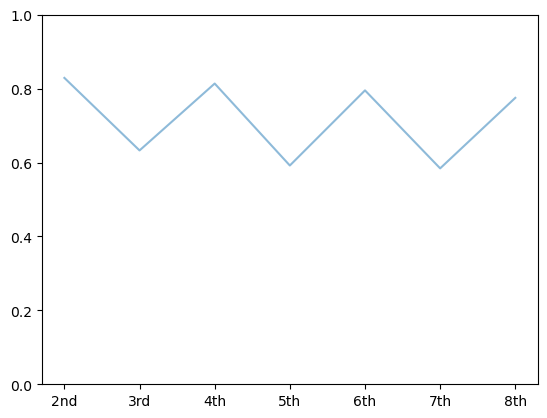

7 <class 'int'>


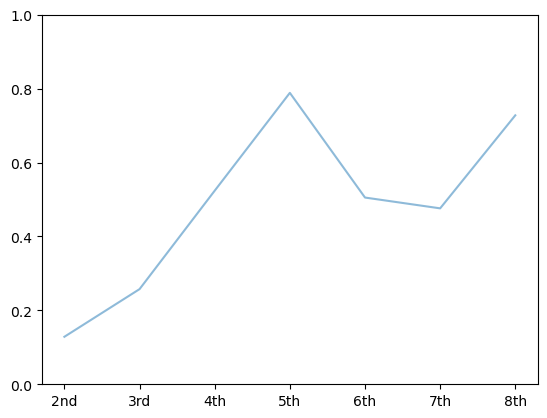

7 <class 'int'>


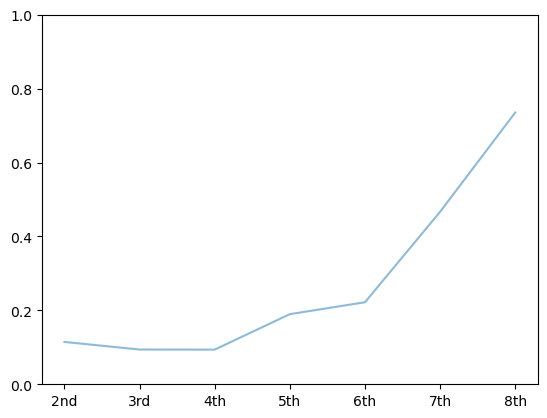

7 <class 'int'>


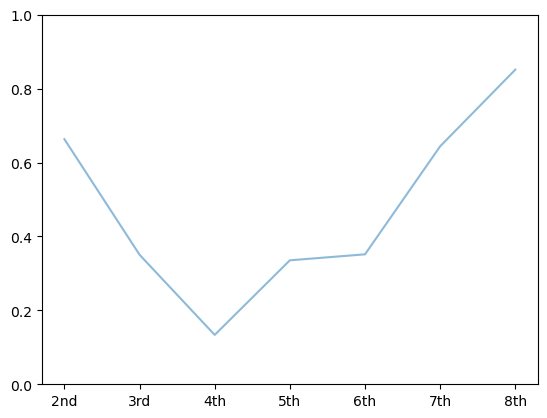

7 <class 'int'>


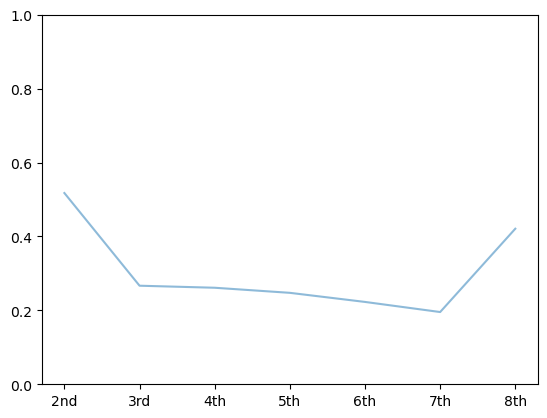

7 <class 'int'>


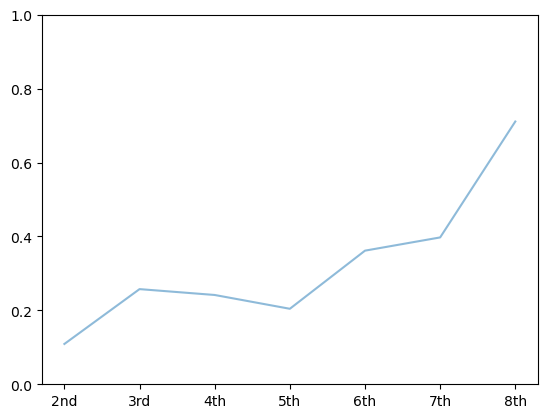

7 <class 'int'>


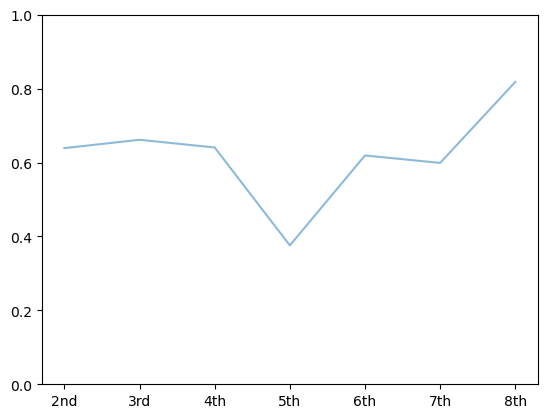

7 <class 'int'>


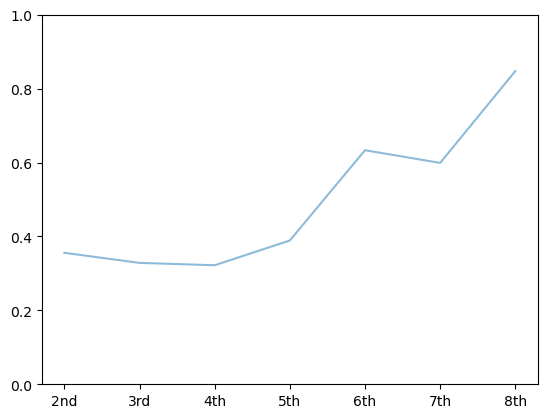

7 <class 'int'>


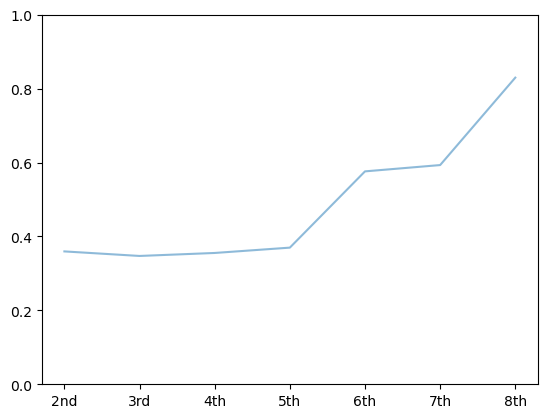

7 <class 'int'>


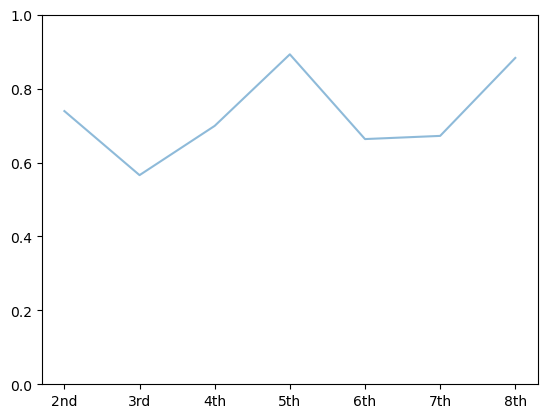

7 <class 'int'>


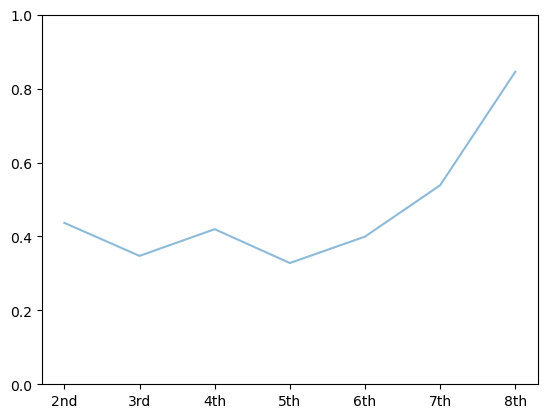

7 <class 'int'>


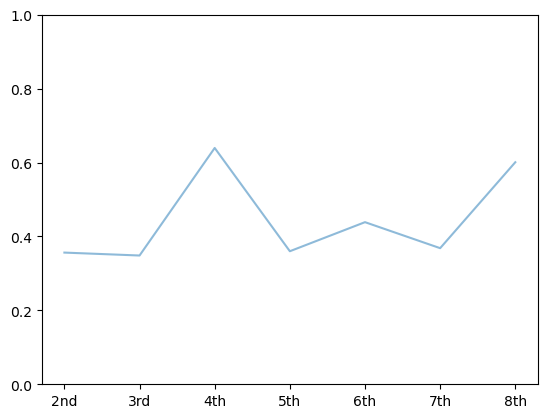

7 <class 'int'>


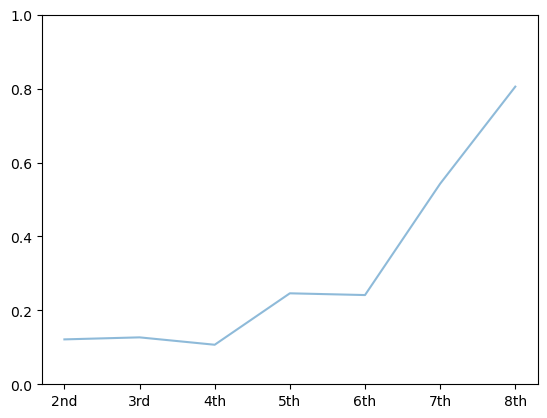

7 <class 'int'>


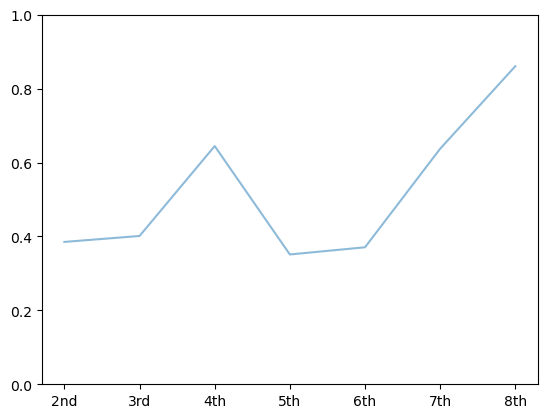

7 <class 'int'>


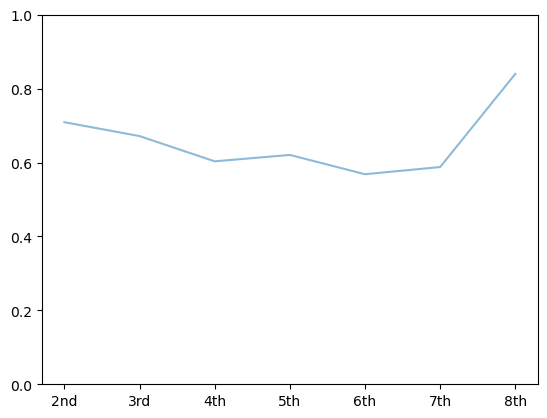

7 <class 'int'>


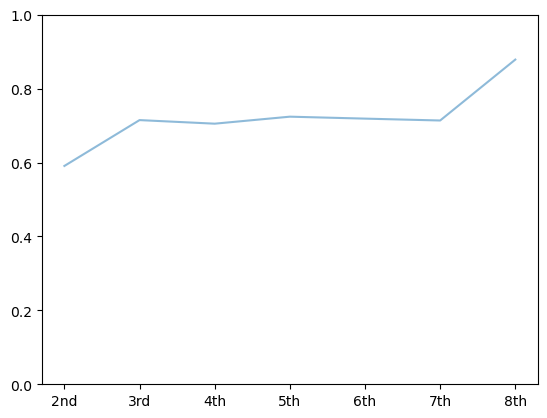

7 <class 'int'>


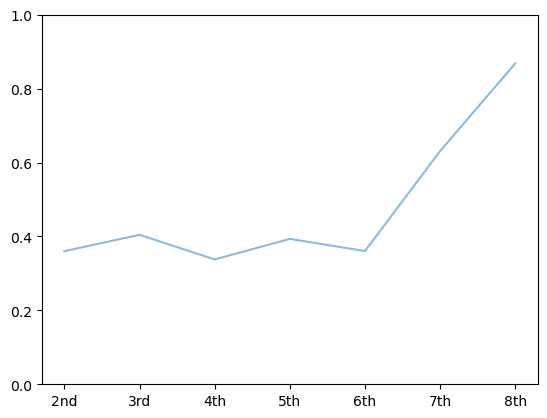

7 <class 'int'>


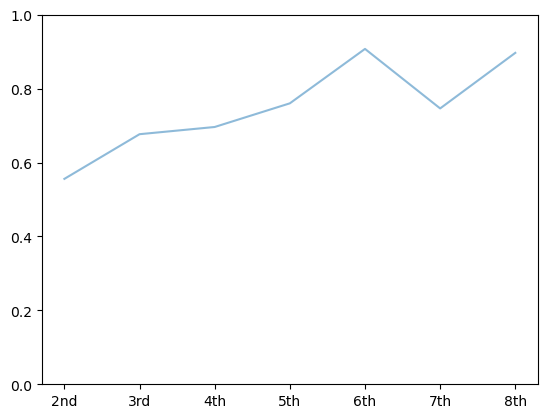

7 <class 'int'>


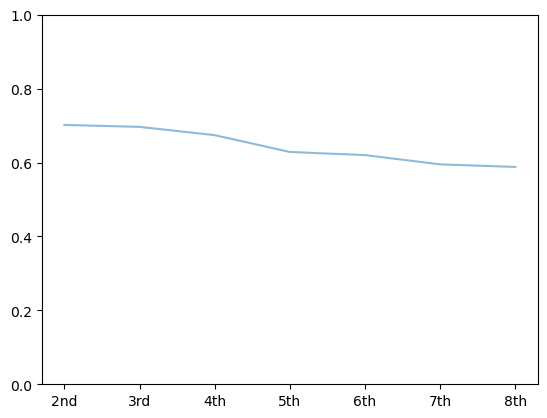

7 <class 'int'>


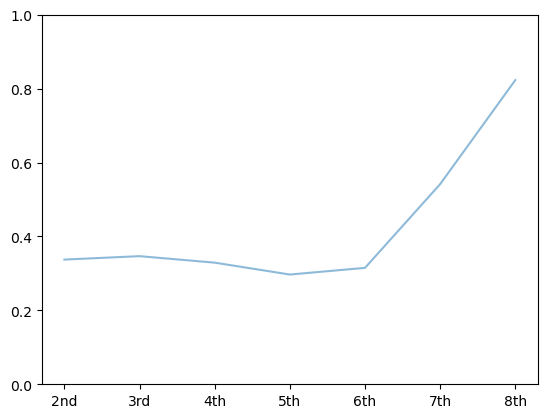

7 <class 'int'>


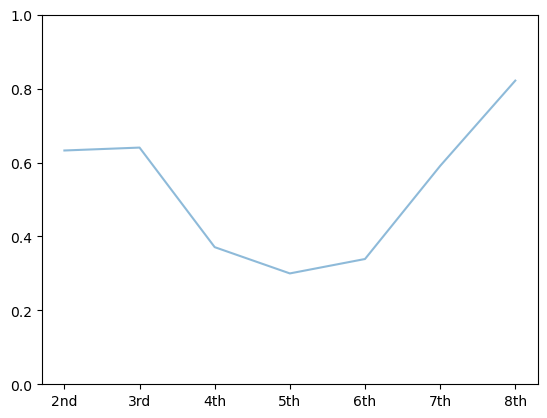

7 <class 'int'>


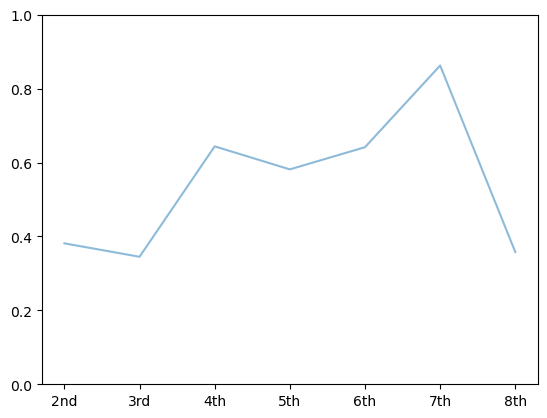

7 <class 'int'>


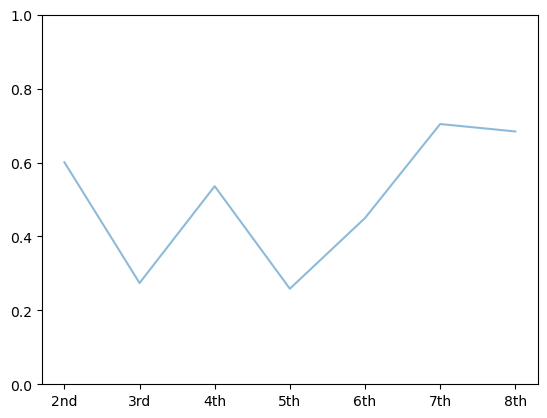

7 <class 'int'>


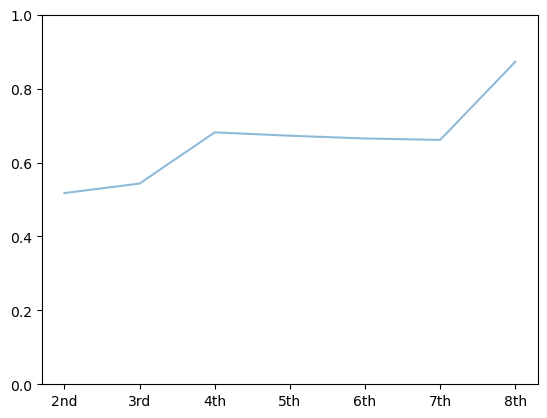

7 <class 'int'>


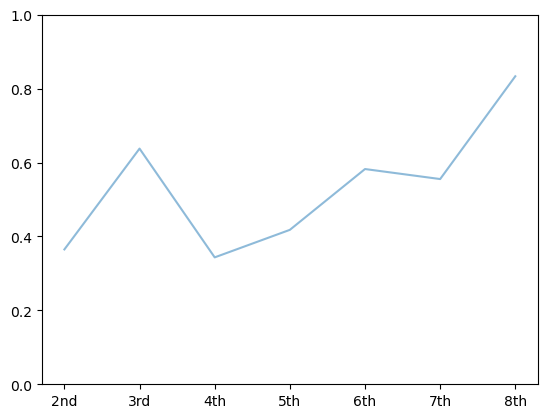

7 <class 'int'>


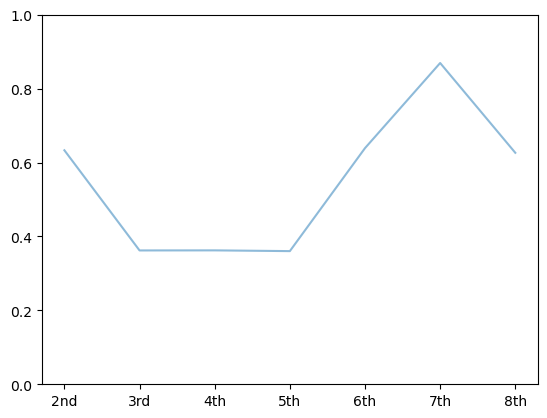

7 <class 'int'>


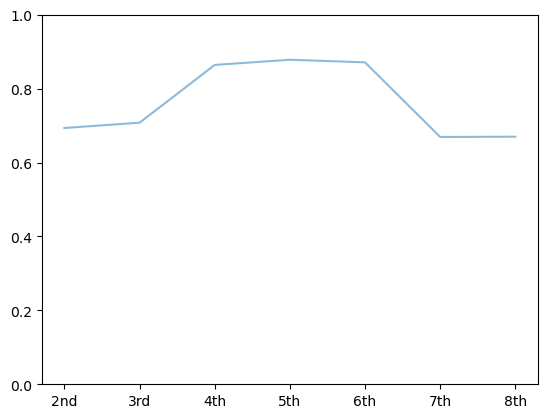

7 <class 'int'>


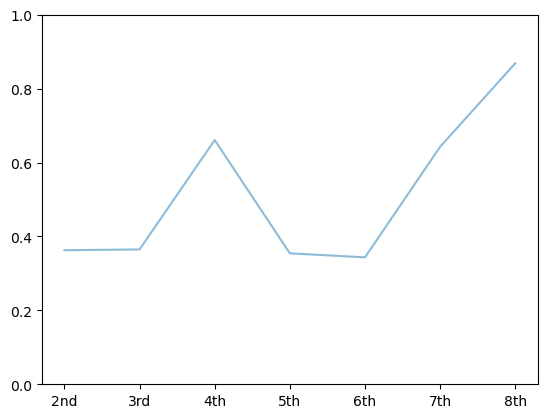

7 <class 'int'>


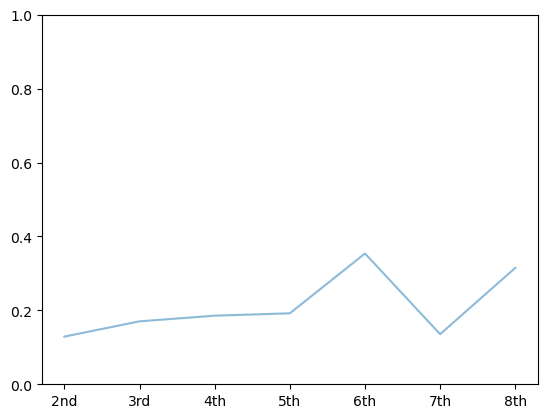

7 <class 'int'>


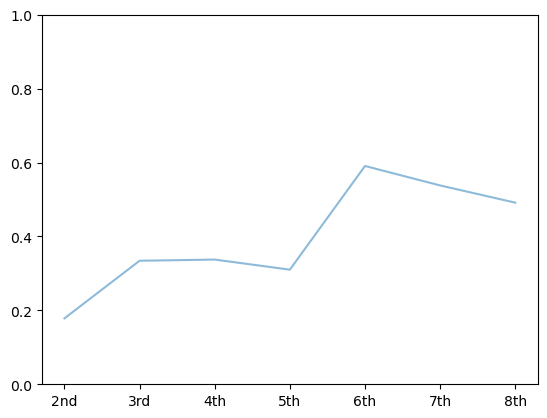

7 <class 'int'>


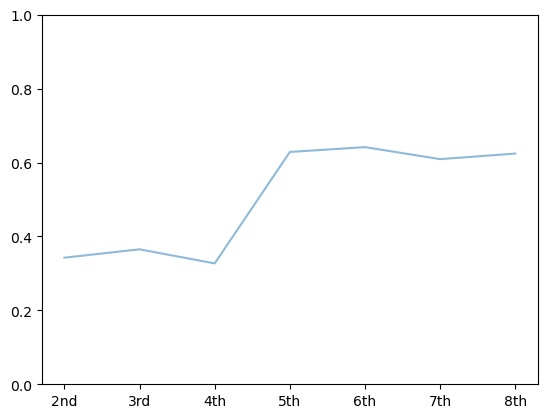

7 <class 'int'>


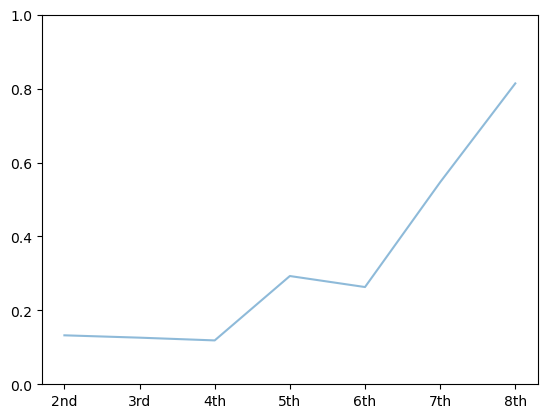

7 <class 'int'>


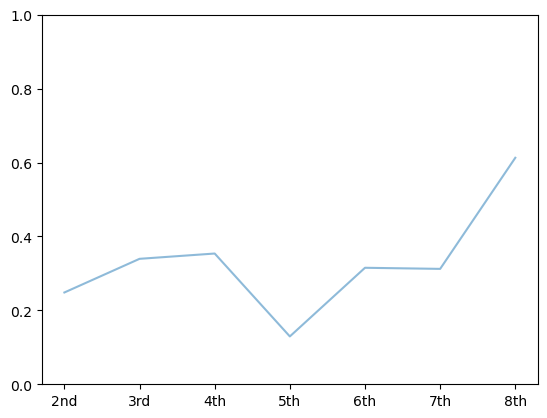

7 <class 'int'>


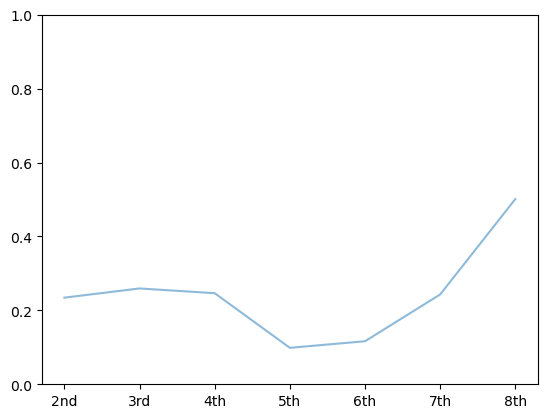

7 <class 'int'>


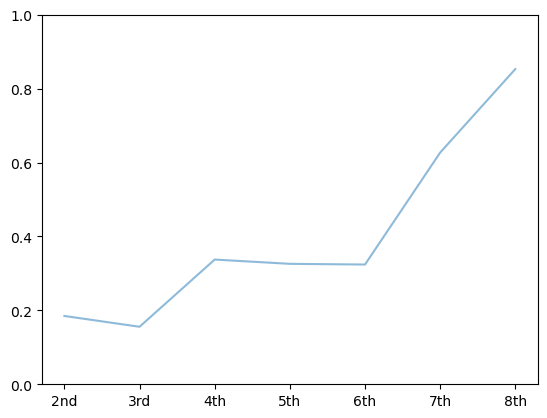

7 <class 'int'>


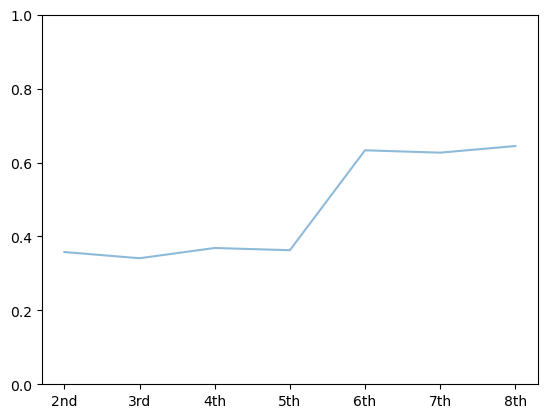

7 <class 'int'>


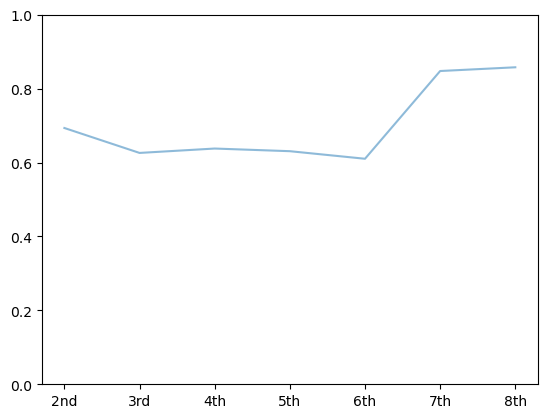

7 <class 'int'>


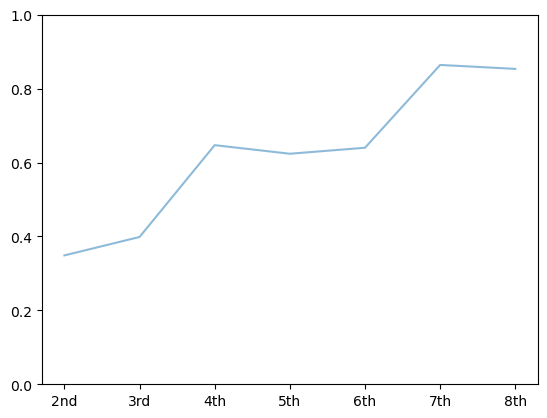

7 <class 'int'>


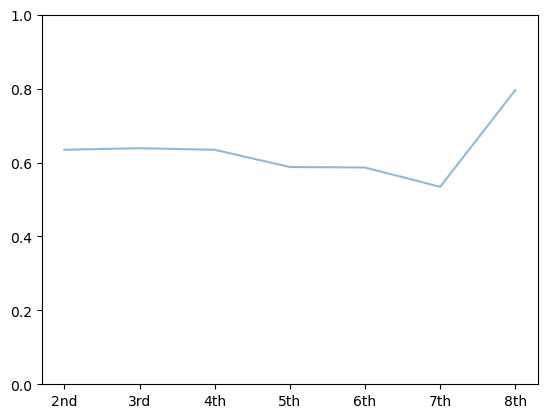

7 <class 'int'>


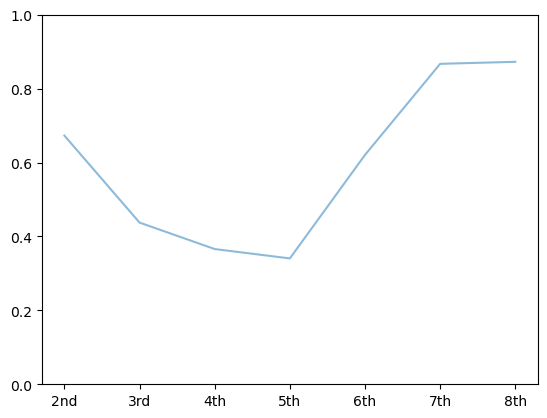

7 <class 'int'>


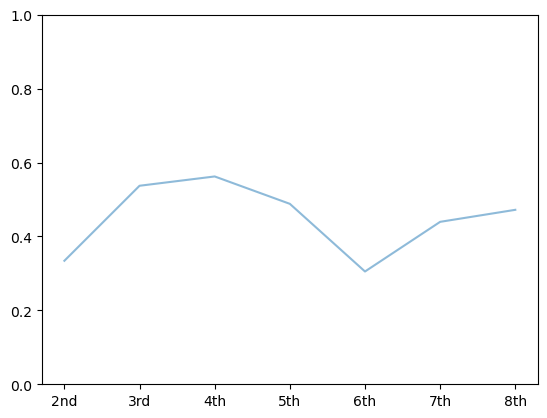

7 <class 'int'>


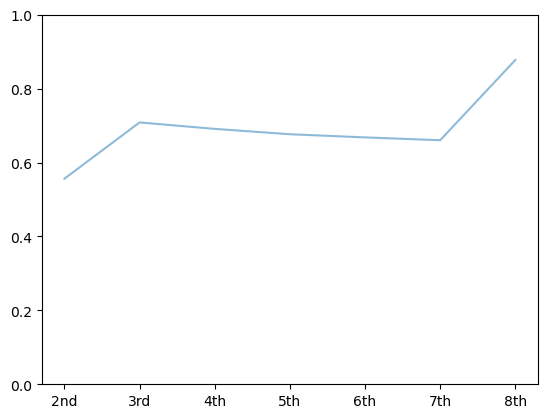

7 <class 'int'>


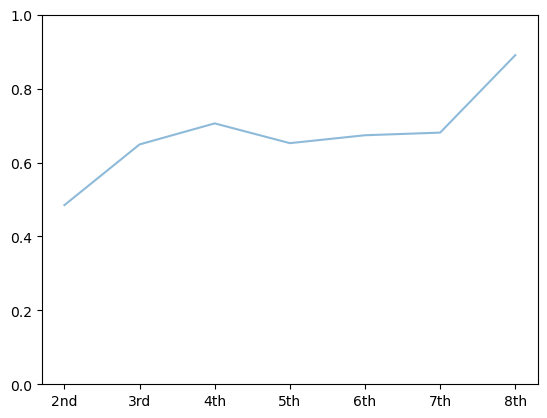

7 <class 'int'>


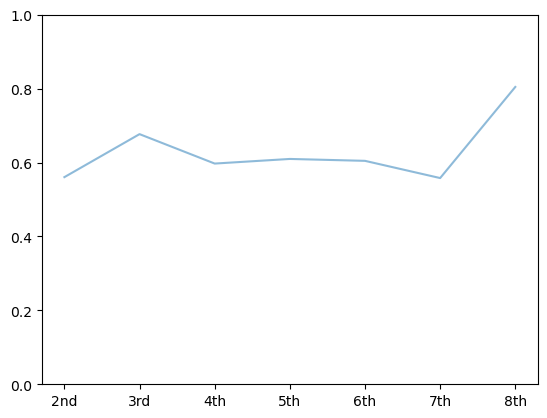

7 <class 'int'>


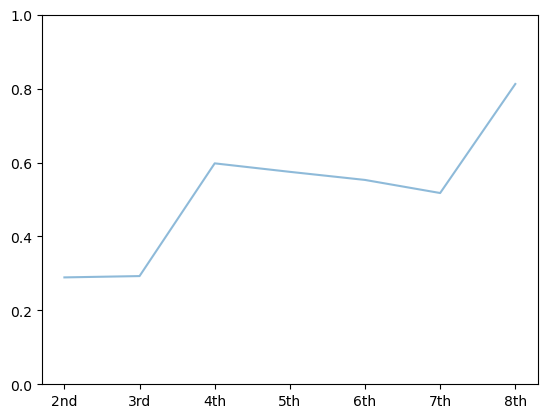

7 <class 'int'>


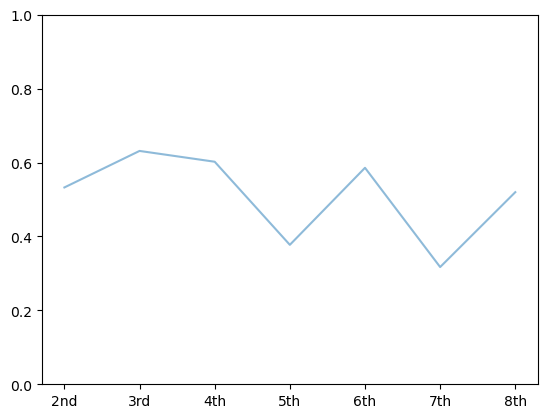

7 <class 'int'>


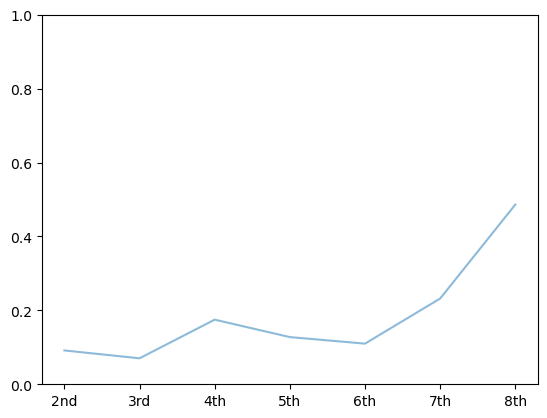

7 <class 'int'>


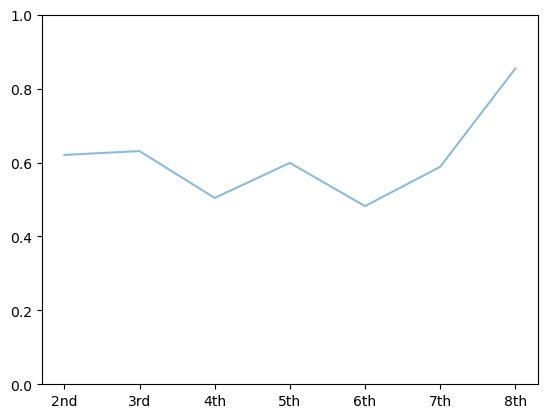

7 <class 'int'>


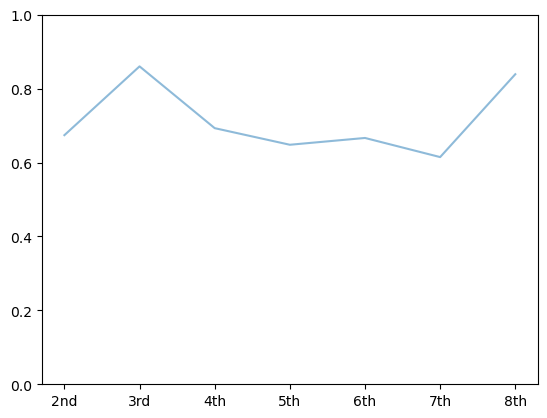

7 <class 'int'>


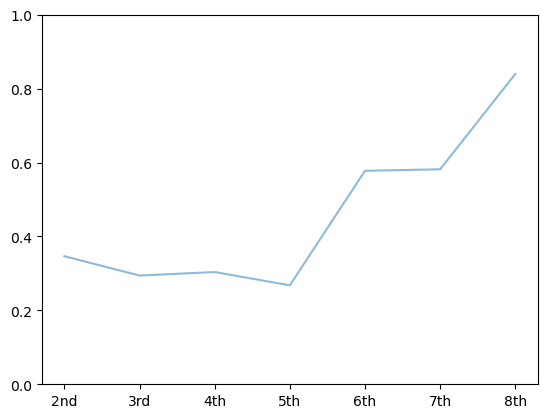

7 <class 'int'>


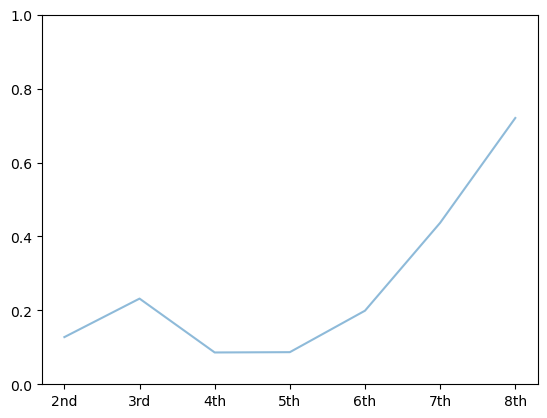

7 <class 'int'>


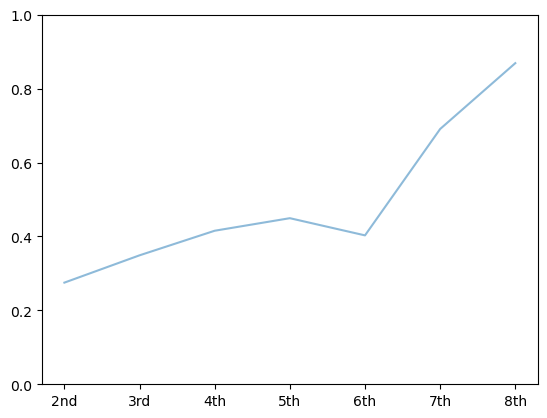

7 <class 'int'>


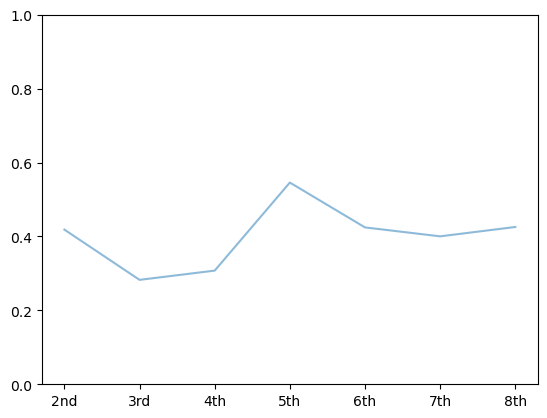

7 <class 'int'>


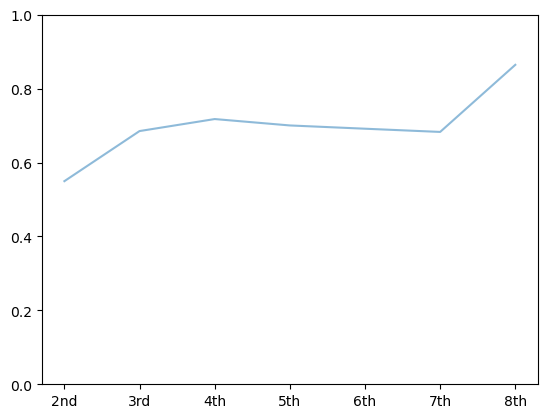

7 <class 'int'>


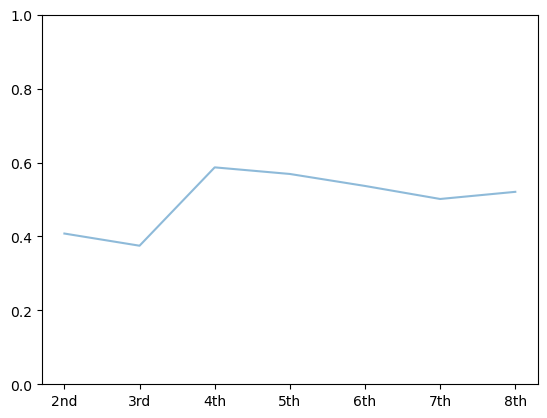

7 <class 'int'>


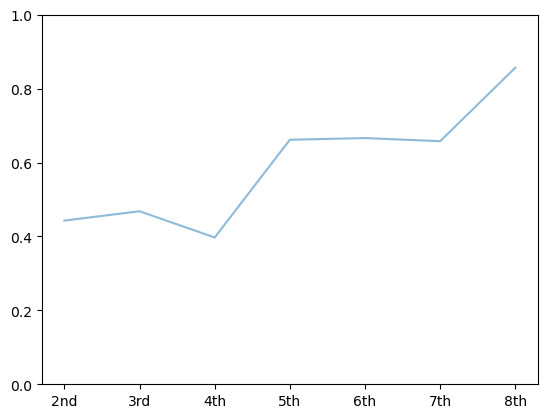

7 <class 'int'>


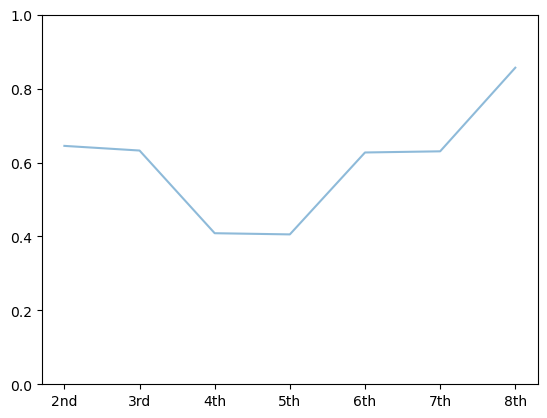

7 <class 'int'>


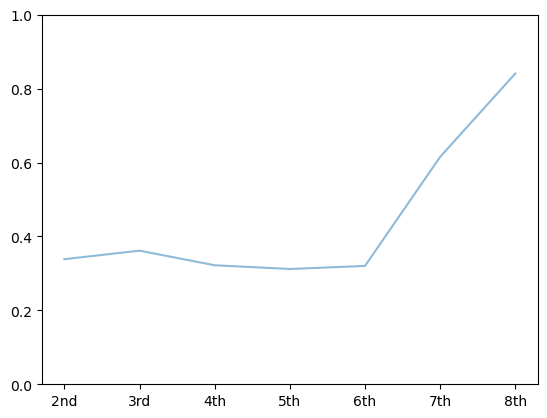

7 <class 'int'>


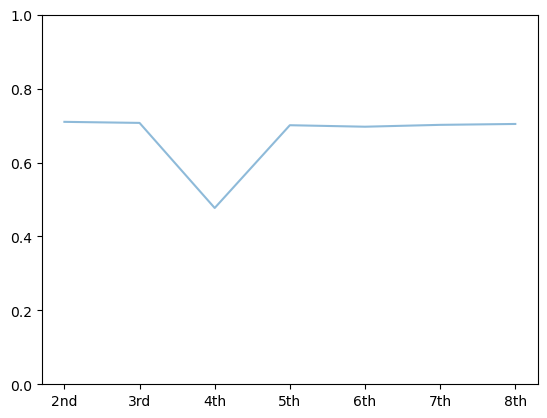

7 <class 'int'>


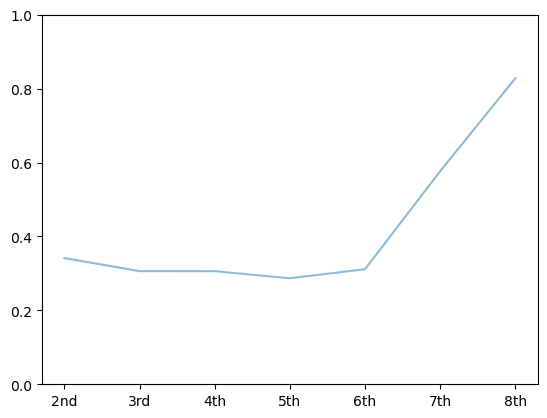

7 <class 'int'>


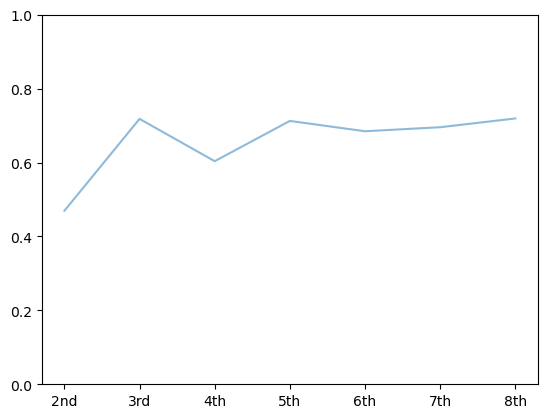

7 <class 'int'>


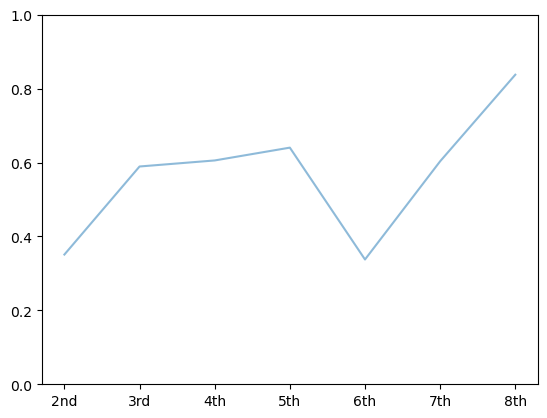

7 <class 'int'>


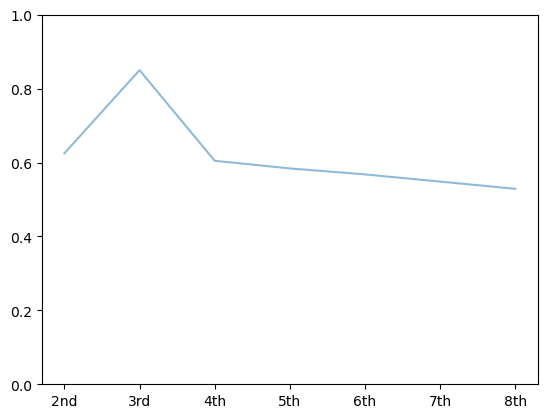

7 <class 'int'>


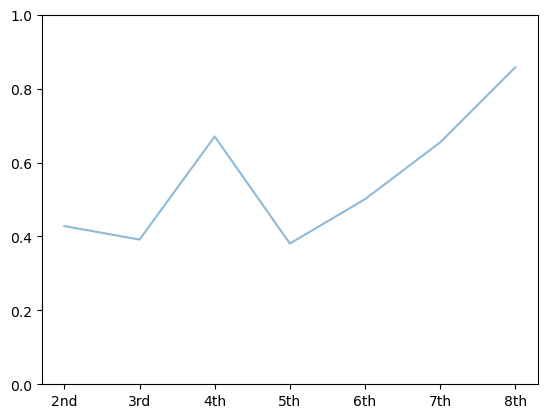

7 <class 'int'>


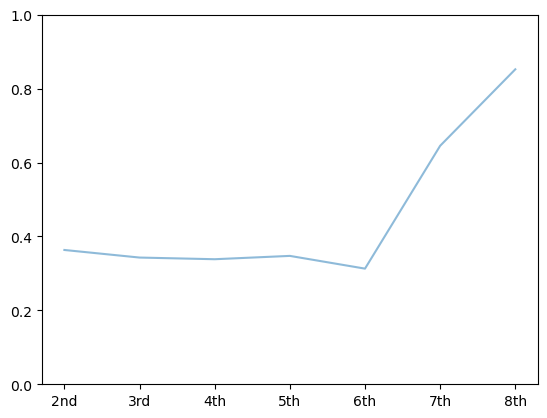

7 <class 'int'>


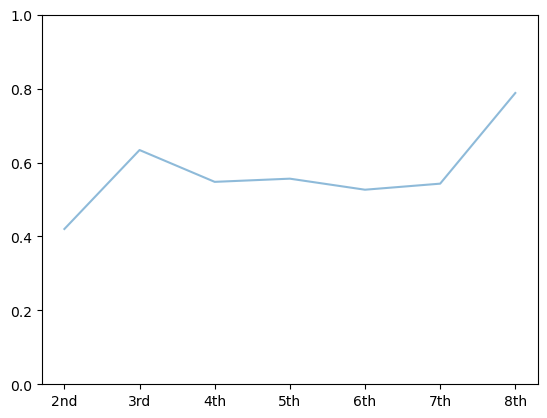

7 <class 'int'>


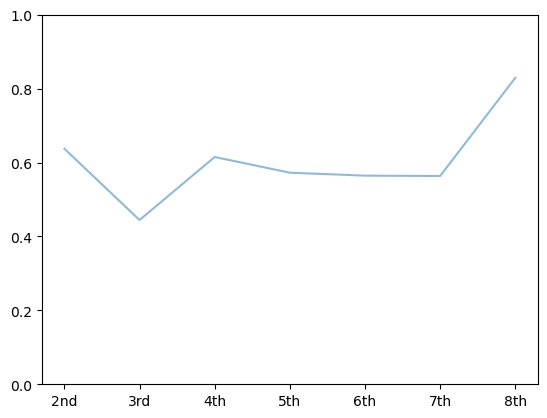

7 <class 'int'>


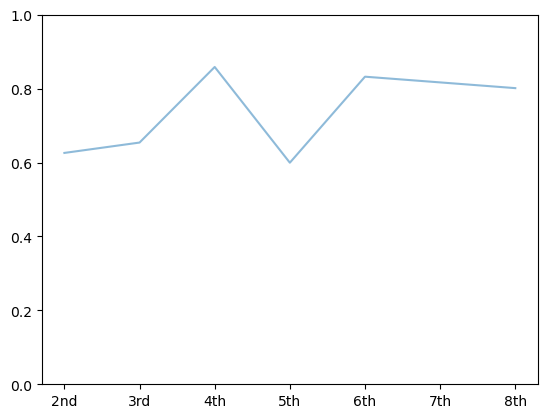

7 <class 'int'>


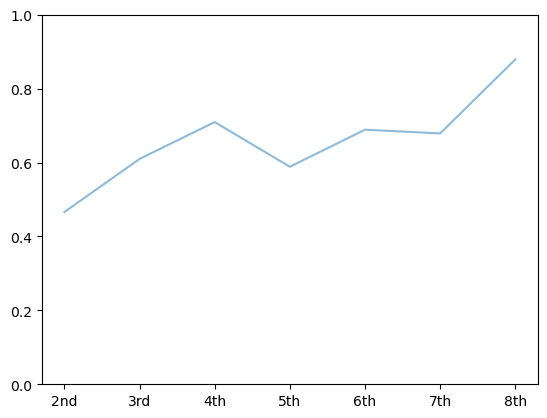

7 <class 'int'>


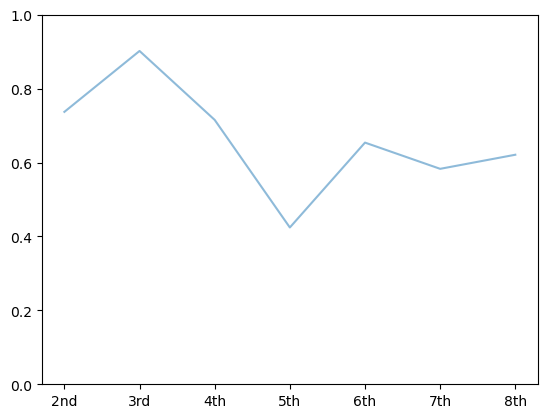

7 <class 'int'>


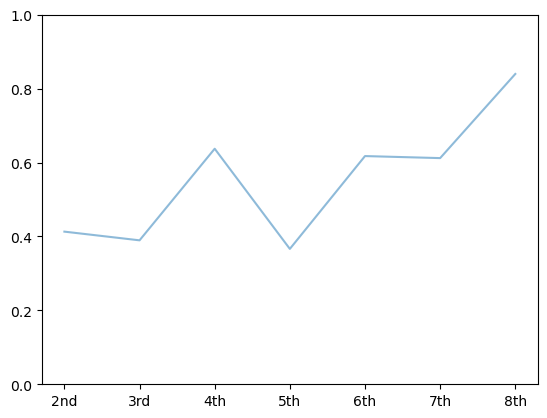

7 <class 'int'>


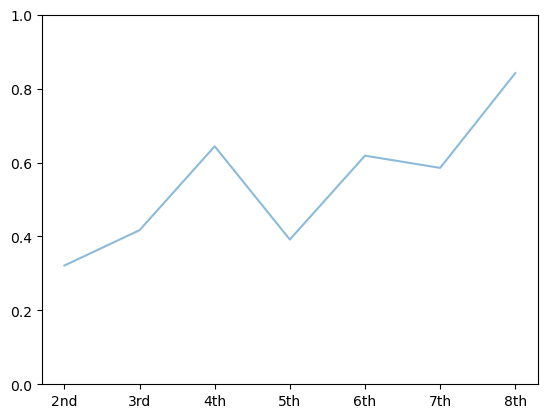

7 <class 'int'>


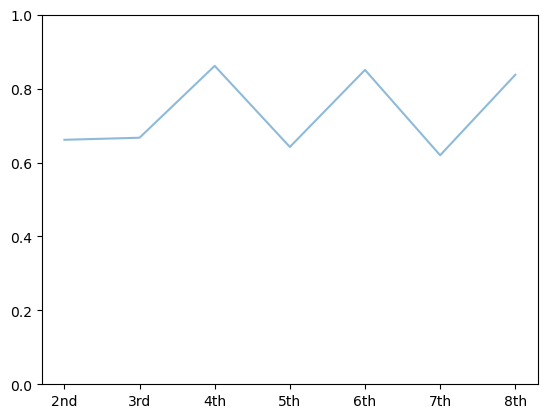

7 <class 'int'>


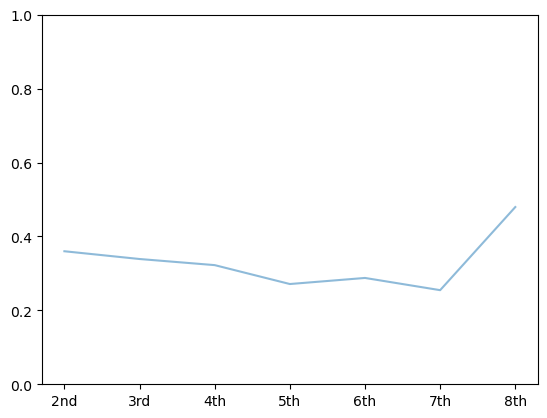

7 <class 'int'>


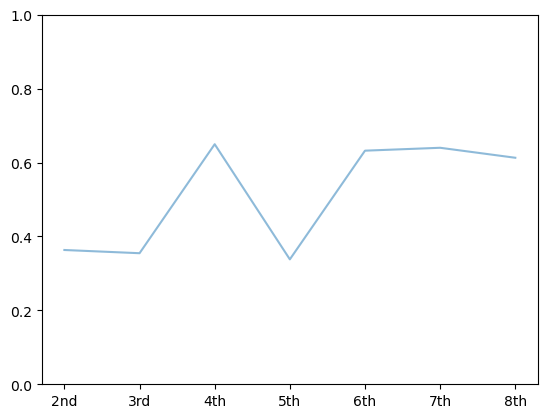

7 <class 'int'>


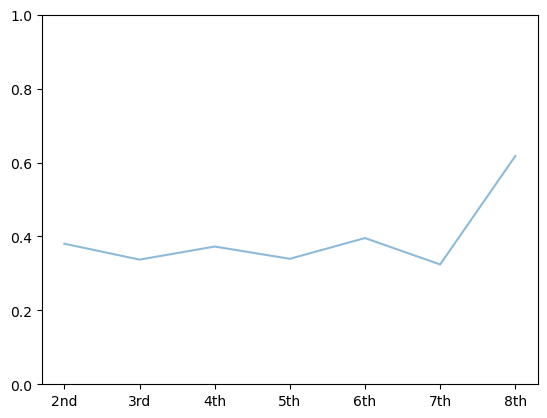

7 <class 'int'>


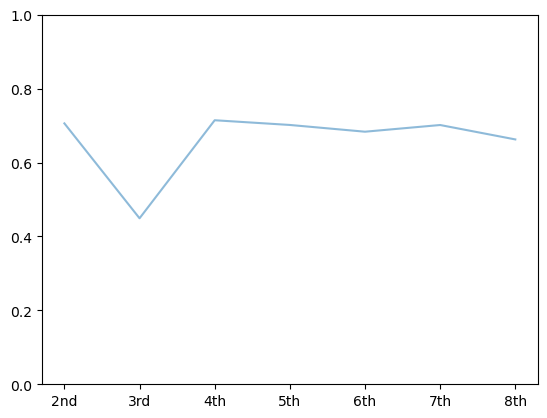

7 <class 'int'>


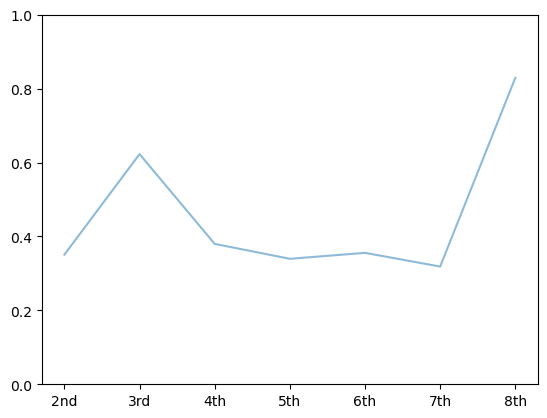

7 <class 'int'>


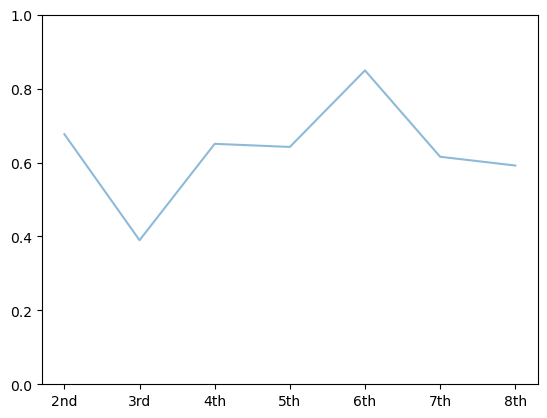

7 <class 'int'>


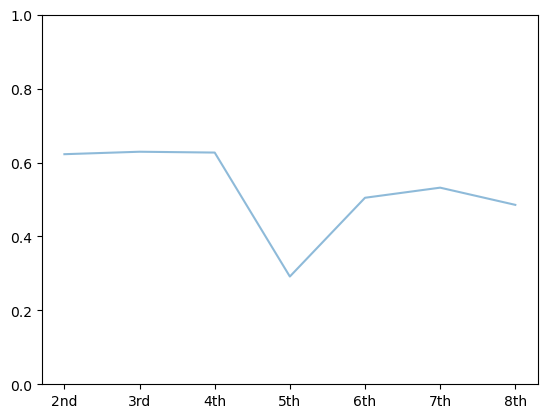

7 <class 'int'>


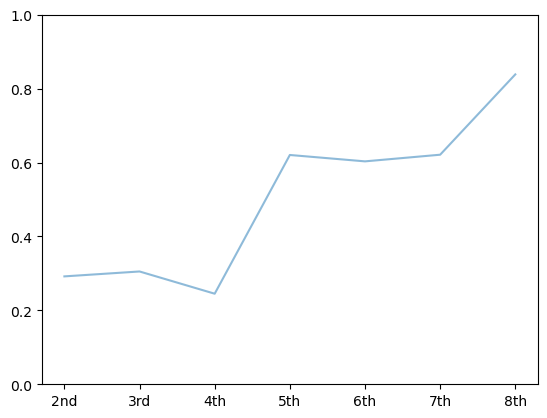

7 <class 'int'>


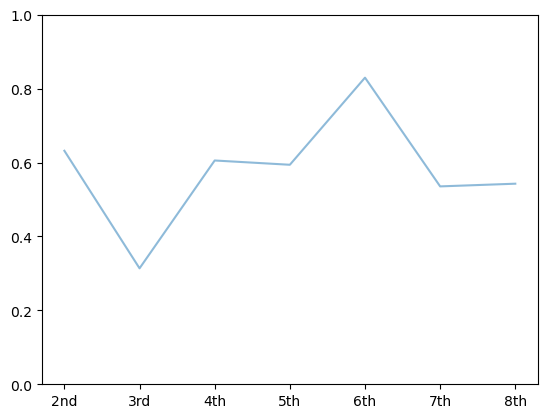

7 <class 'int'>


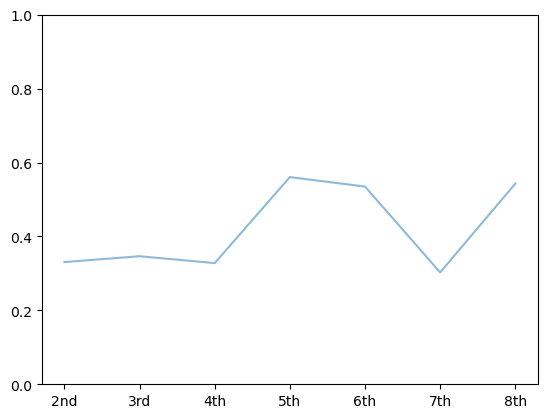

7 <class 'int'>


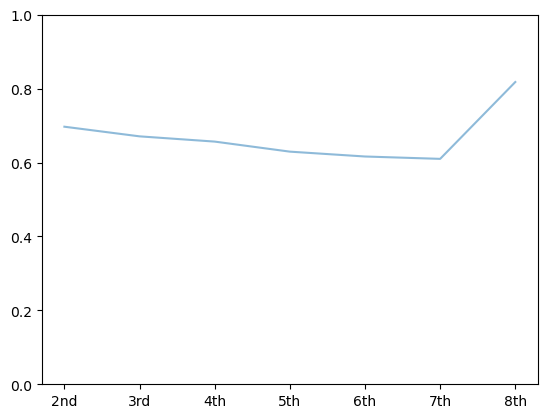

7 <class 'int'>


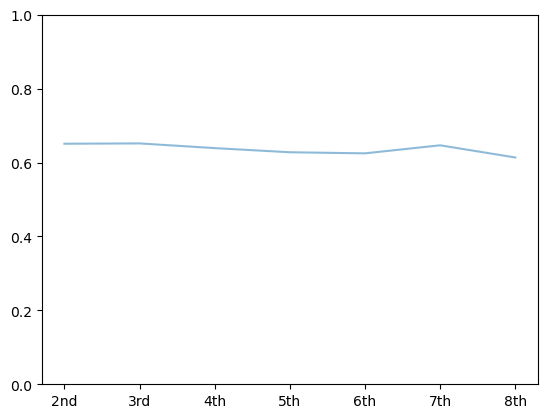

7 <class 'int'>


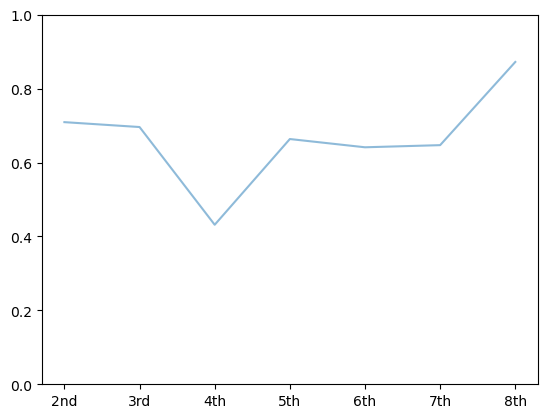

7 <class 'int'>


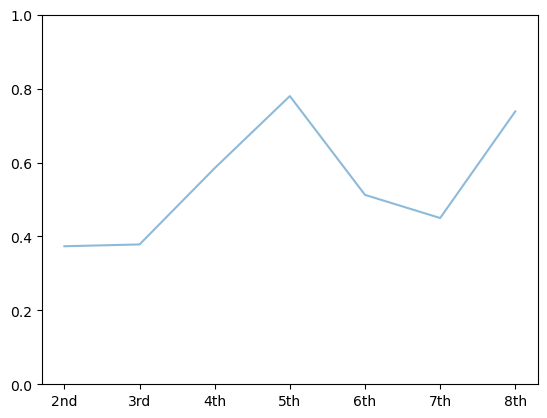

7 <class 'int'>


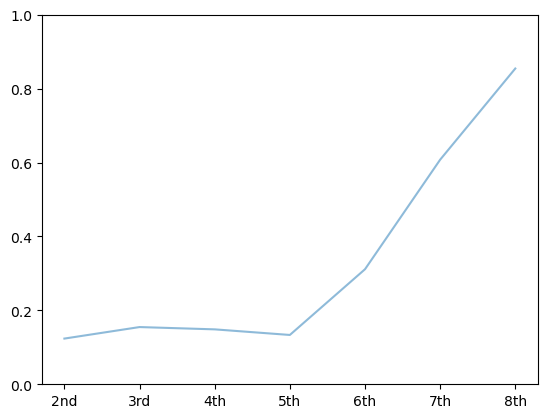

7 <class 'int'>


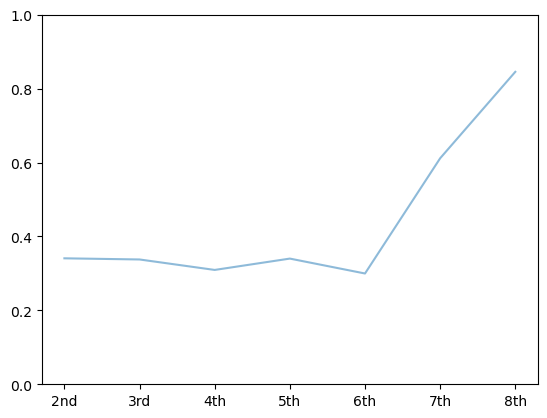

7 <class 'int'>


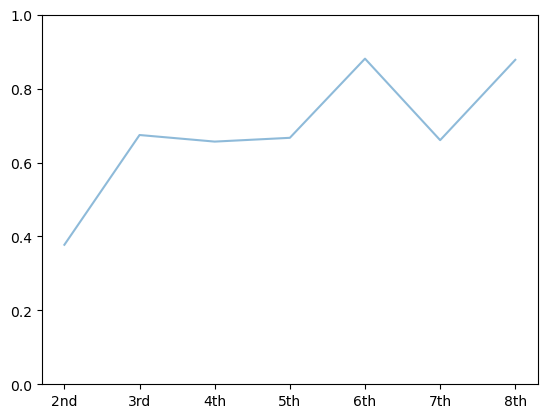

7 <class 'int'>


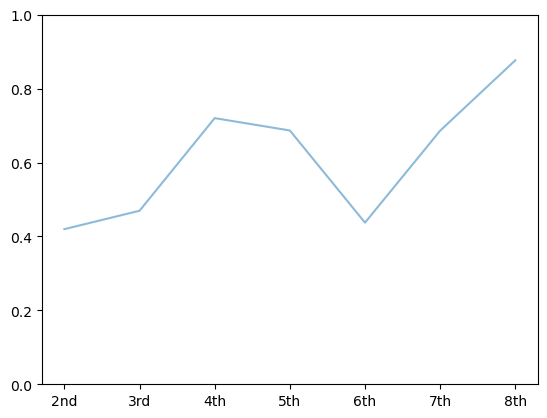

7 <class 'int'>


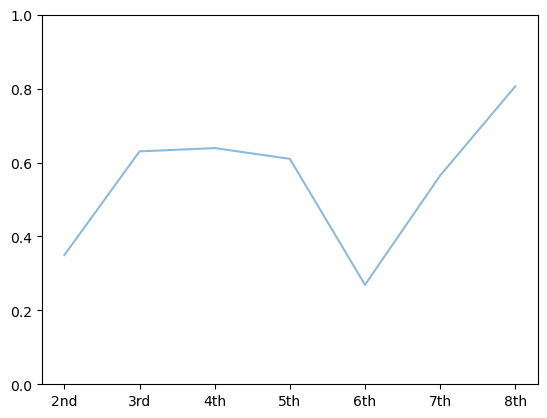

7 <class 'int'>


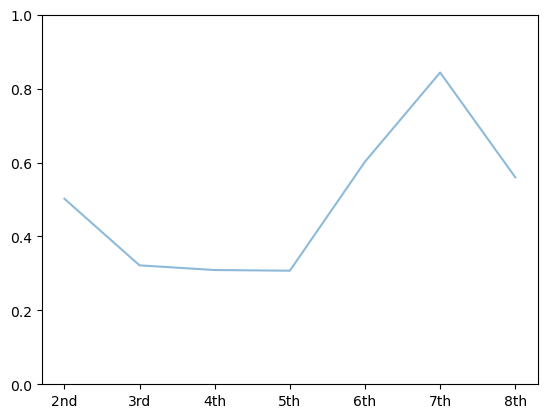

7 <class 'int'>


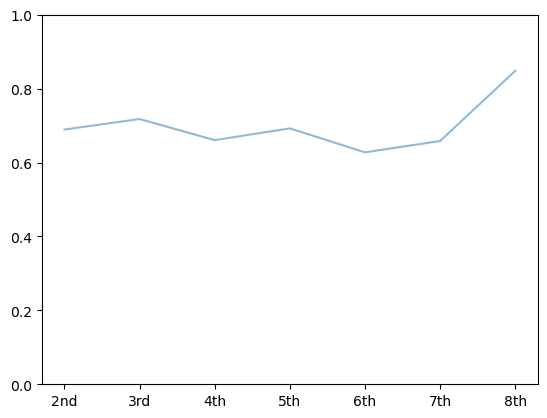

7 <class 'int'>


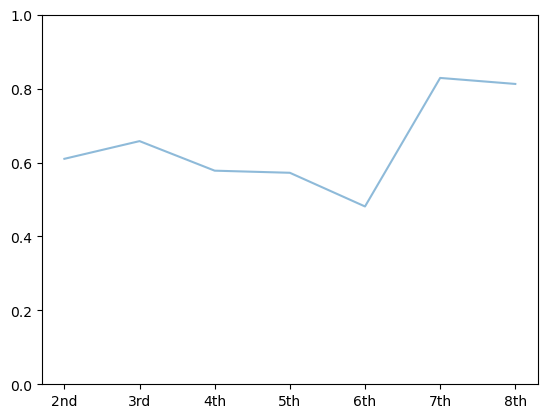

7 <class 'int'>


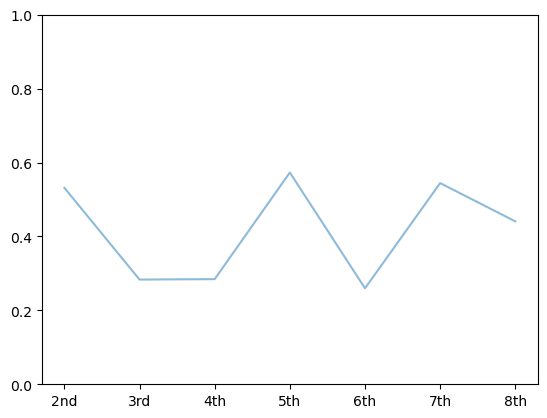

7 <class 'int'>


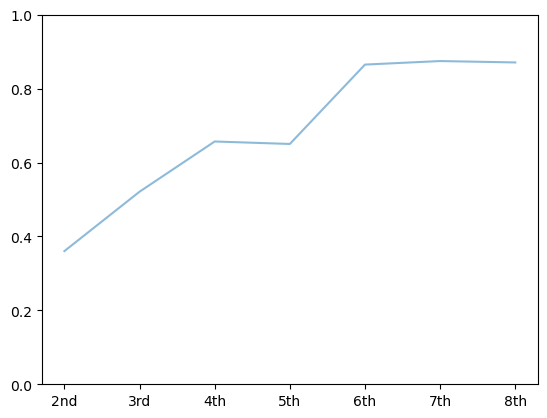

7 <class 'int'>


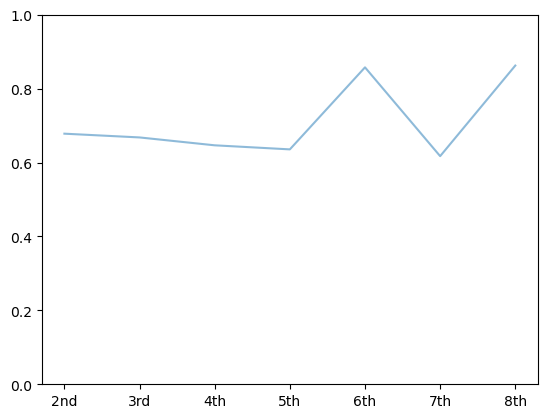

7 <class 'int'>


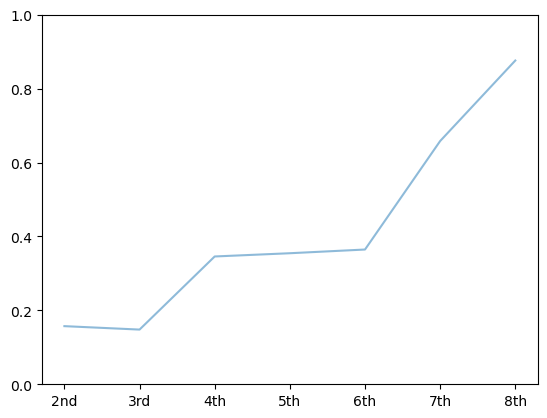

7 <class 'int'>


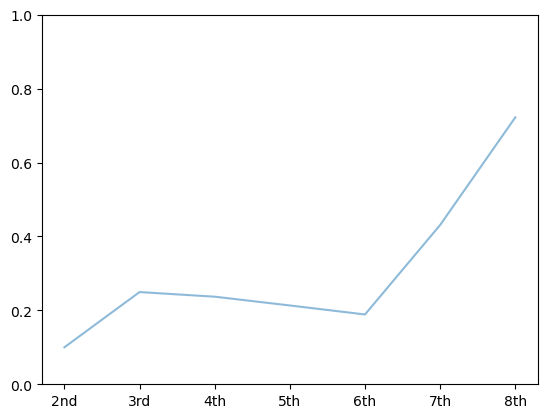

7 <class 'int'>


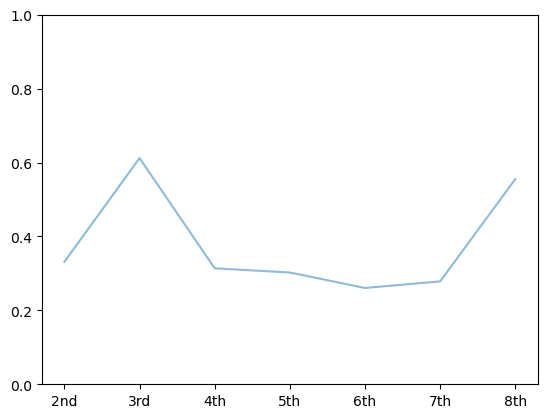

7 <class 'int'>


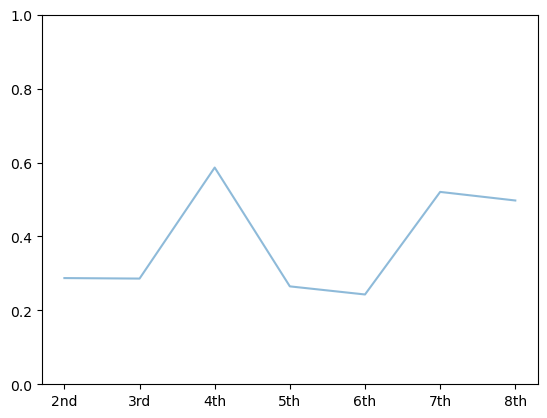

7 <class 'int'>


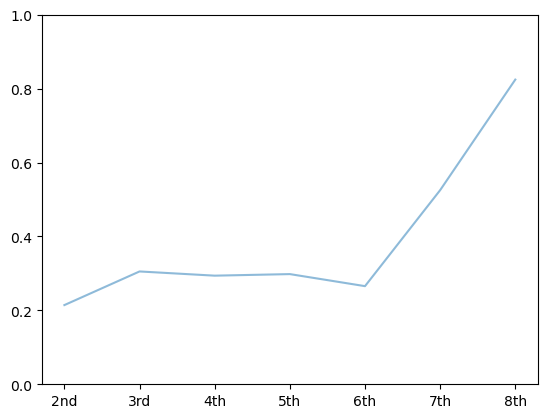

7 <class 'int'>


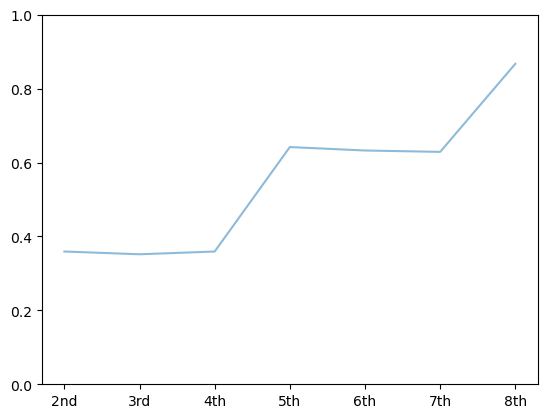

7 <class 'int'>


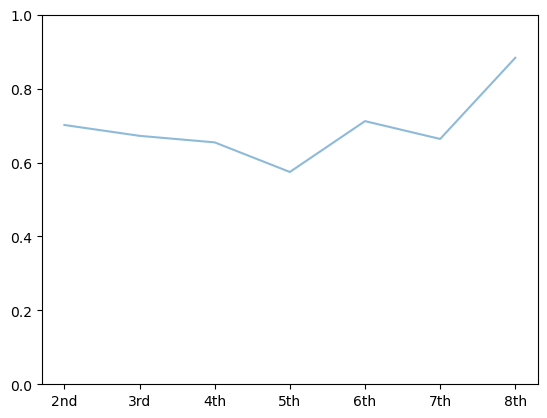

7 <class 'int'>


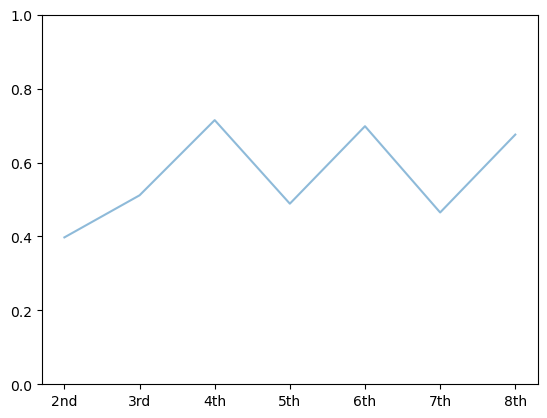

7 <class 'int'>


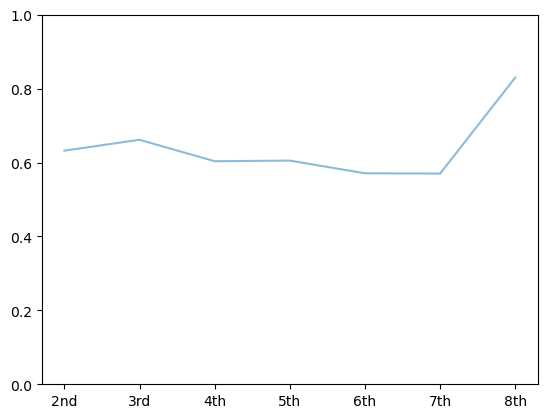

7 <class 'int'>


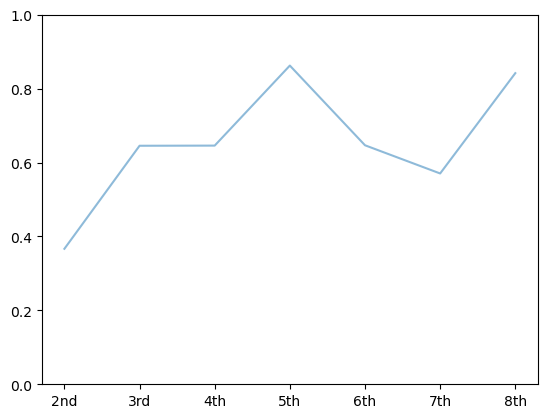

7 <class 'int'>


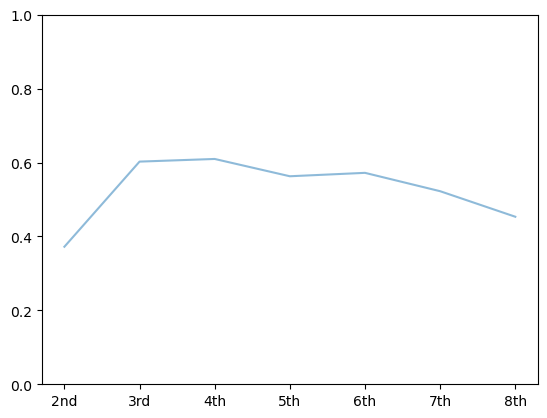

7 <class 'int'>


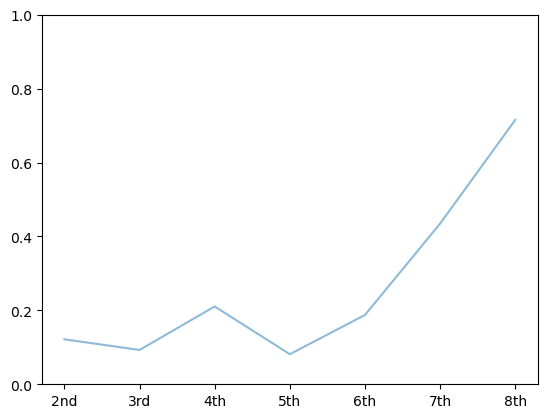

7 <class 'int'>


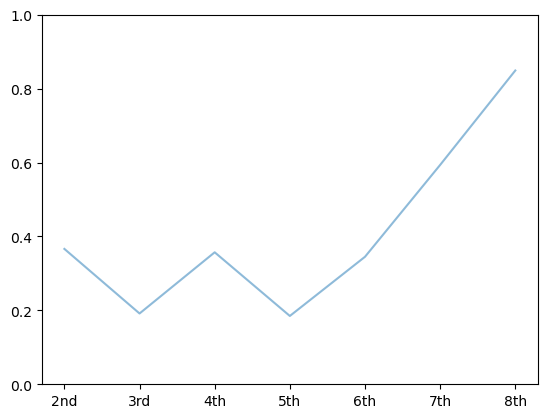

7 <class 'int'>


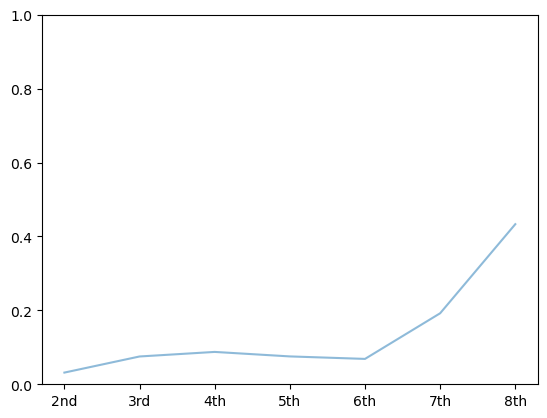

7 <class 'int'>


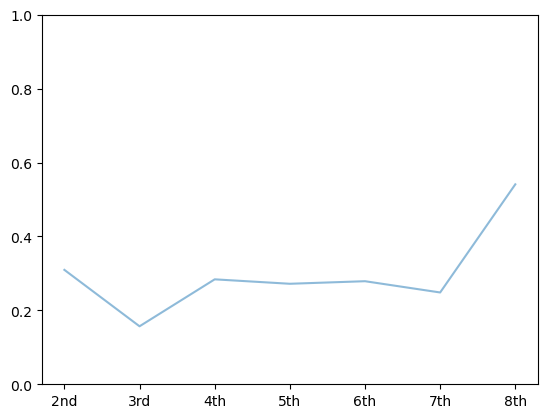

7 <class 'int'>


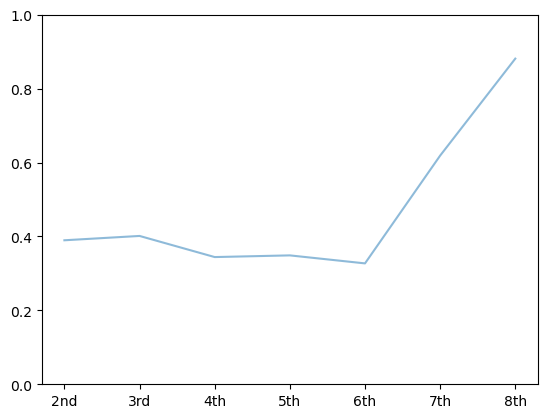

7 <class 'int'>


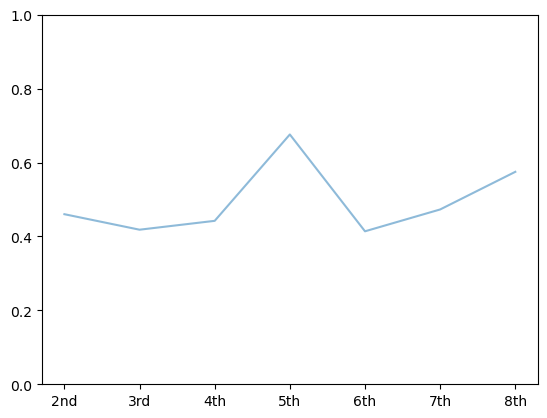

7 <class 'int'>


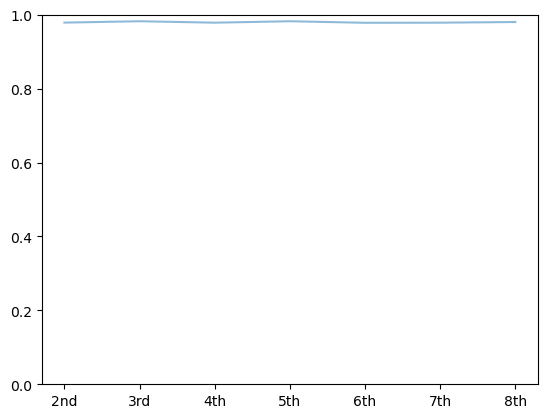

7 <class 'int'>


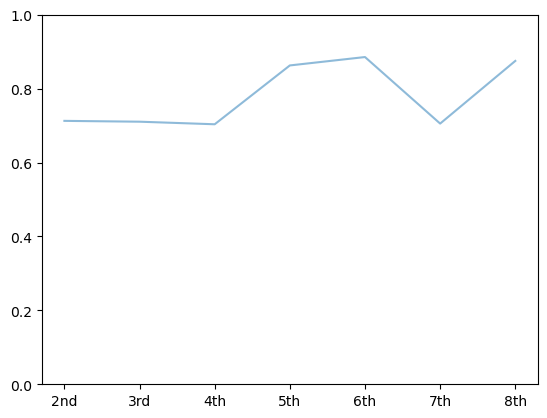

7 <class 'int'>


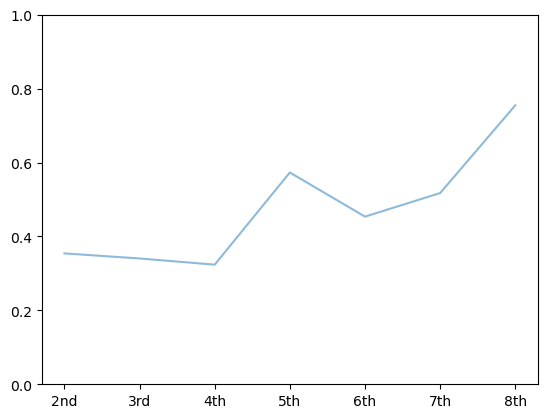

7 <class 'int'>


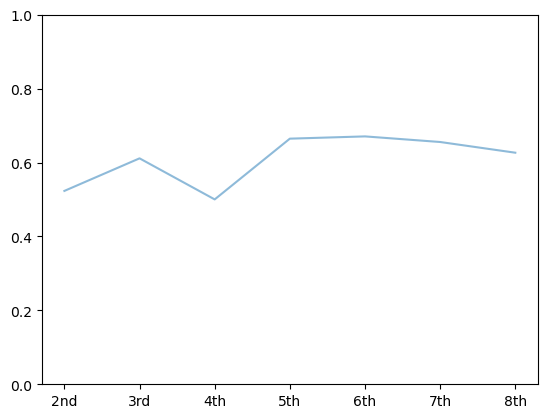

7 <class 'int'>


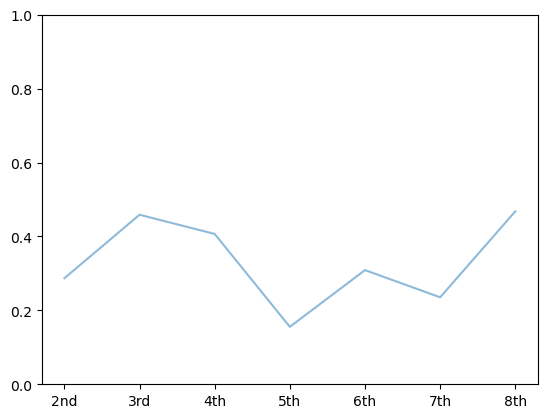

7 <class 'int'>


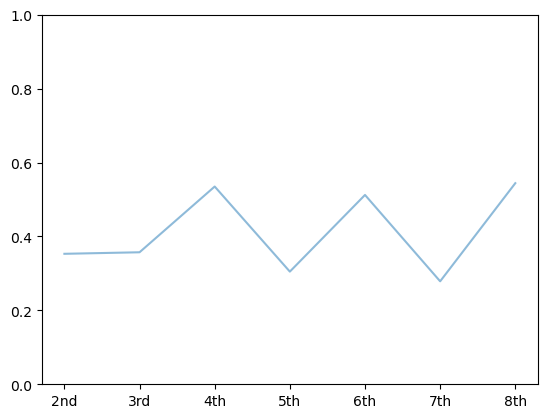

7 <class 'int'>


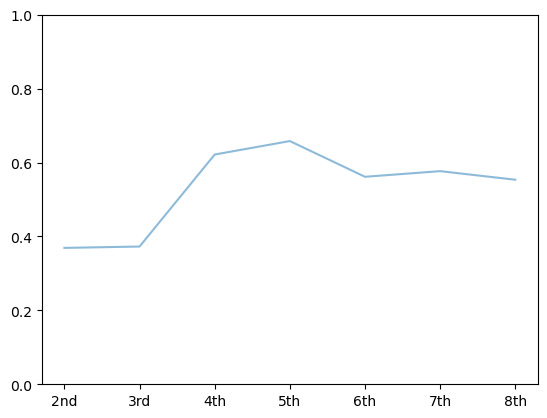

7 <class 'int'>


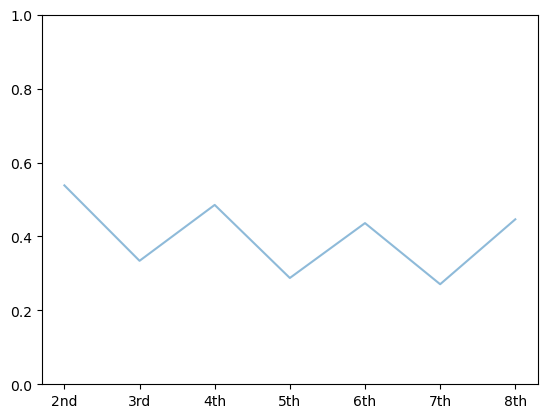

7 <class 'int'>


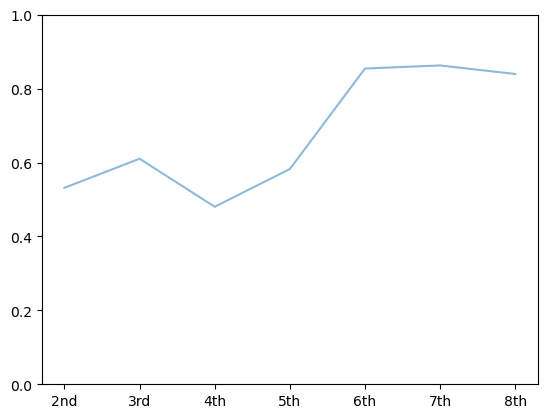

7 <class 'int'>


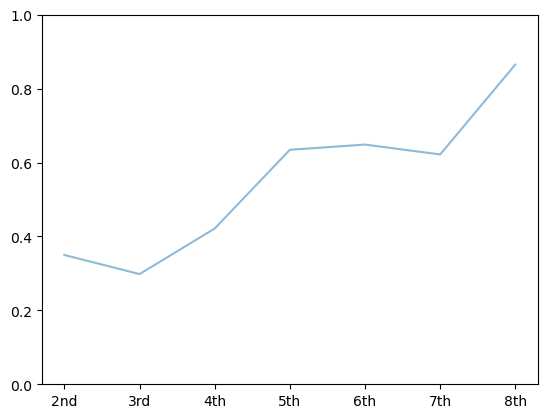

7 <class 'int'>


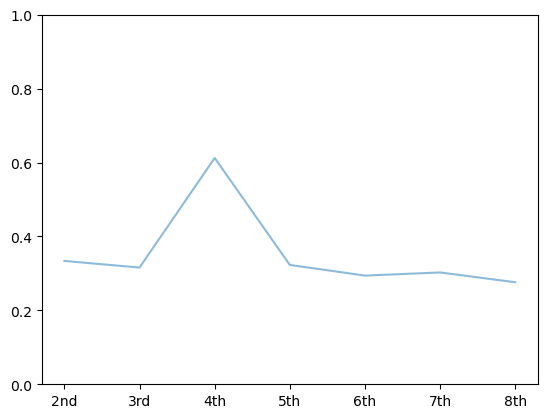

7 <class 'int'>


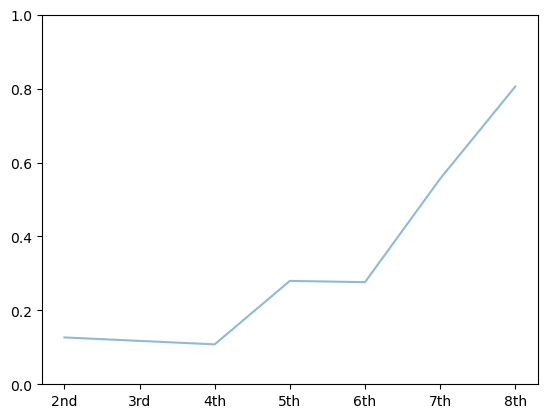

7 <class 'int'>


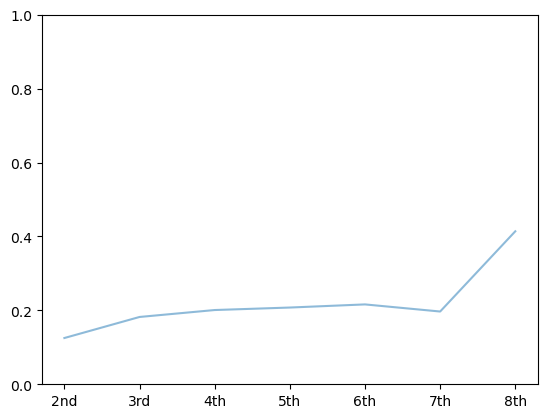

7 <class 'int'>


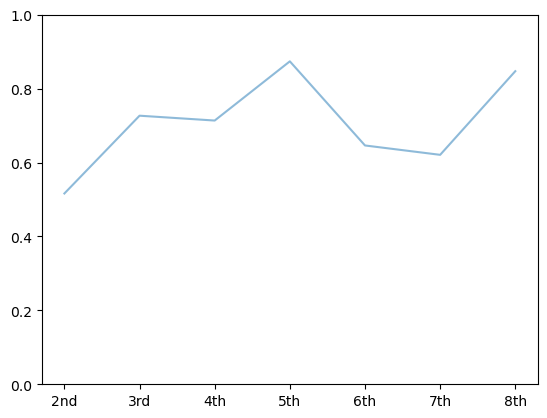

7 <class 'int'>


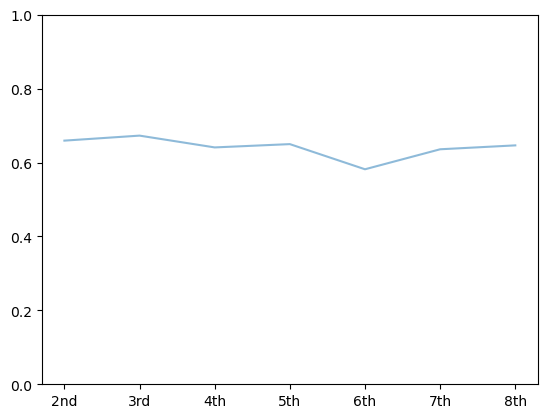

7 <class 'int'>


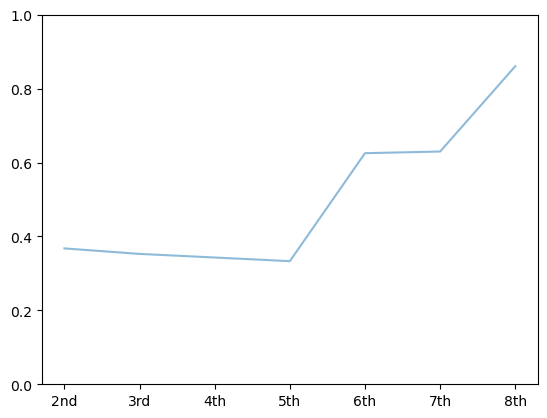

7 <class 'int'>


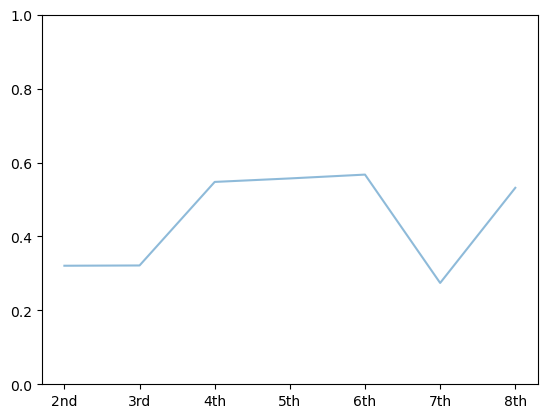

7 <class 'int'>


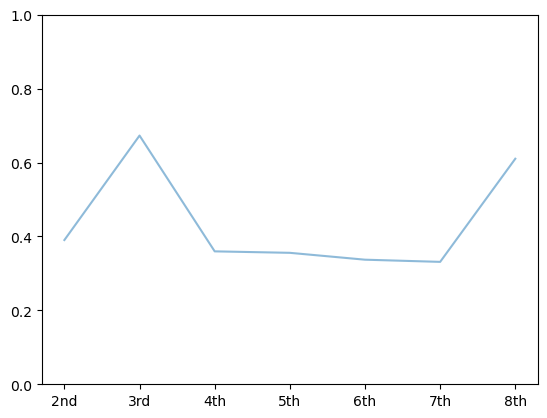

7 <class 'int'>


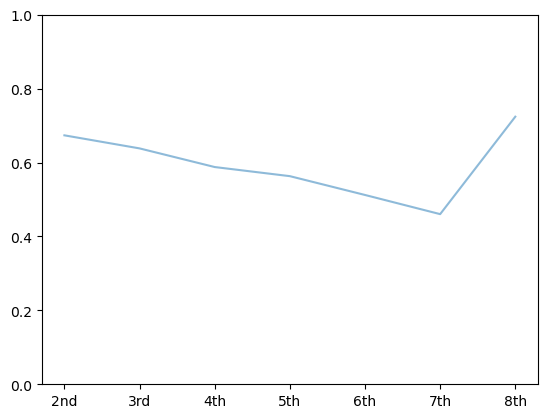

7 <class 'int'>


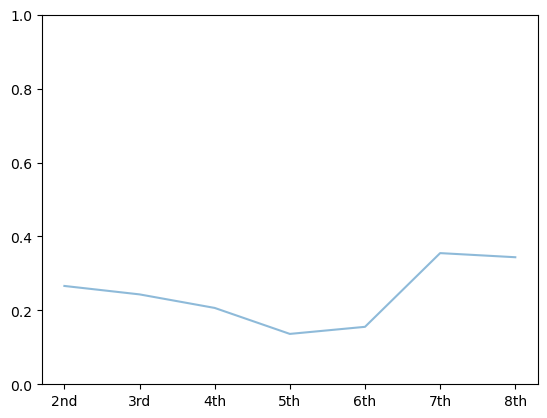

7 <class 'int'>


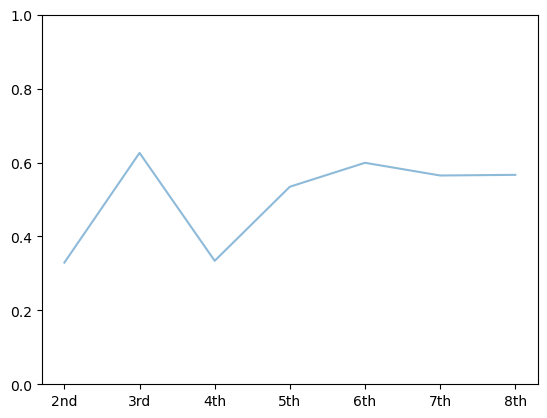

7 <class 'int'>


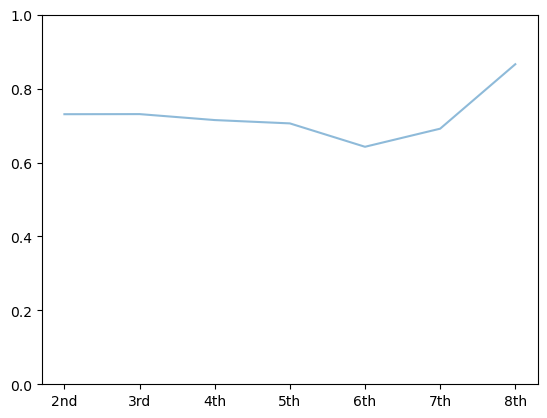

7 <class 'int'>


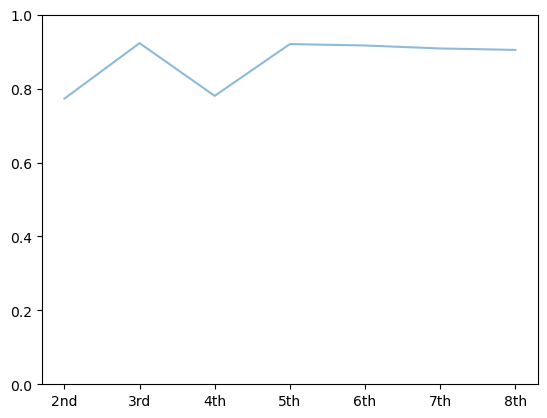

7 <class 'int'>


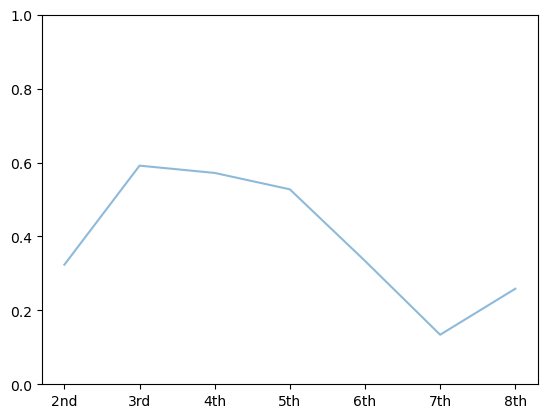

7 <class 'int'>


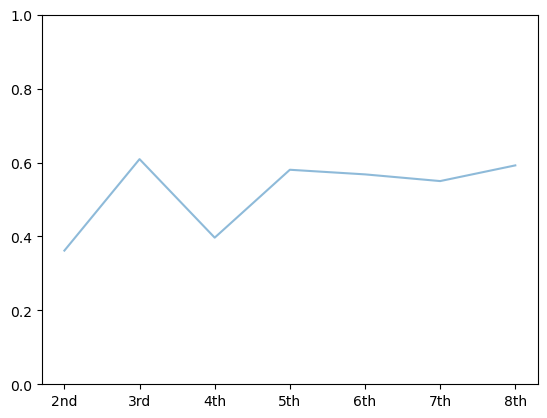

7 <class 'int'>


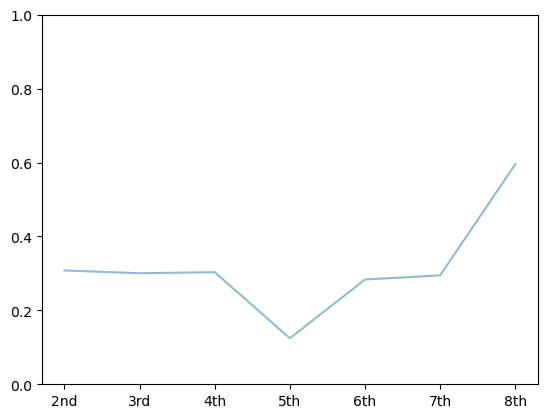

7 <class 'int'>


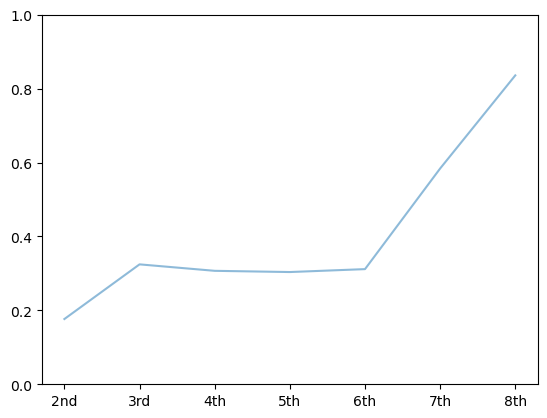

7 <class 'int'>


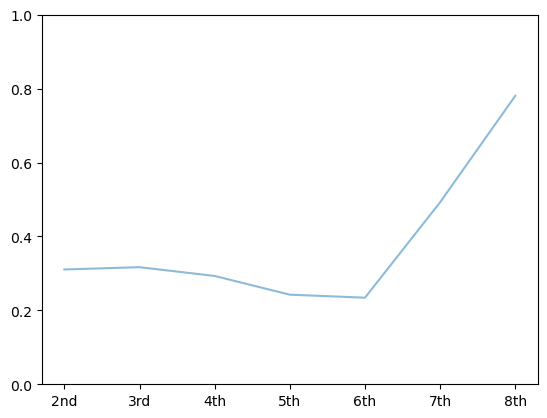

7 <class 'int'>


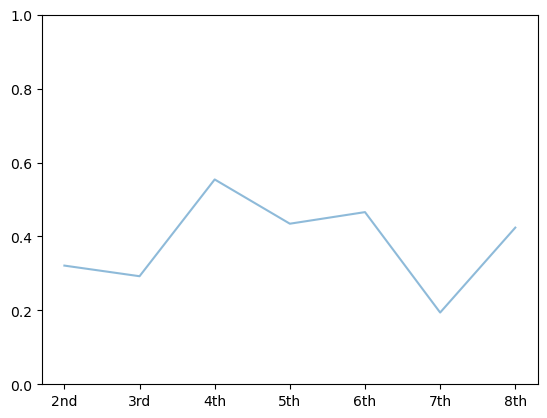

7 <class 'int'>


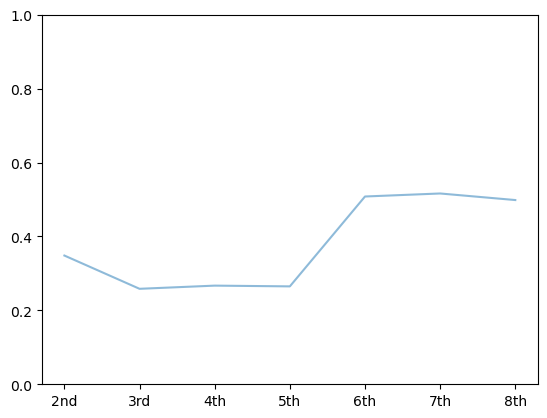

7 <class 'int'>


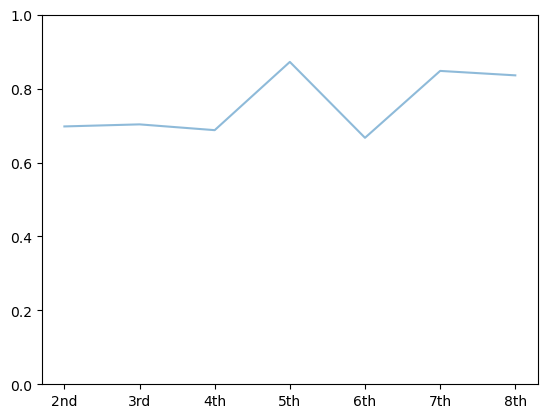

7 <class 'int'>


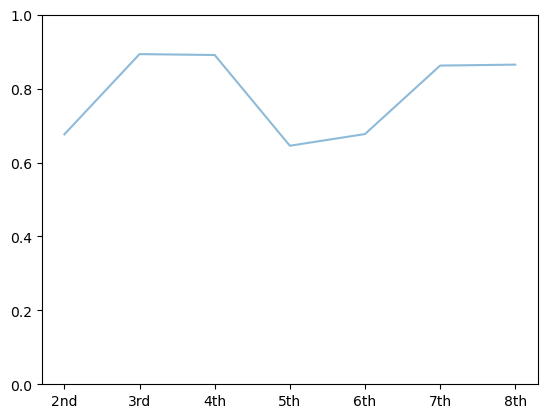

7 <class 'int'>


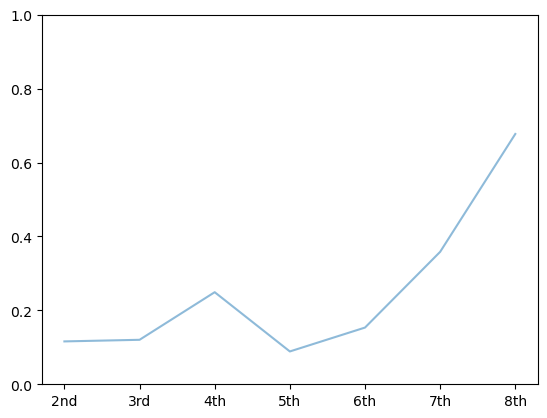

7 <class 'int'>


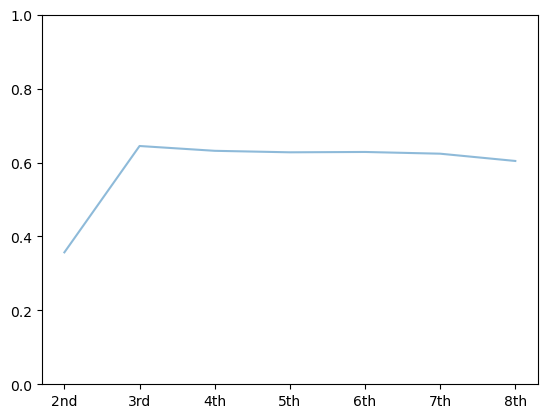

7 <class 'int'>


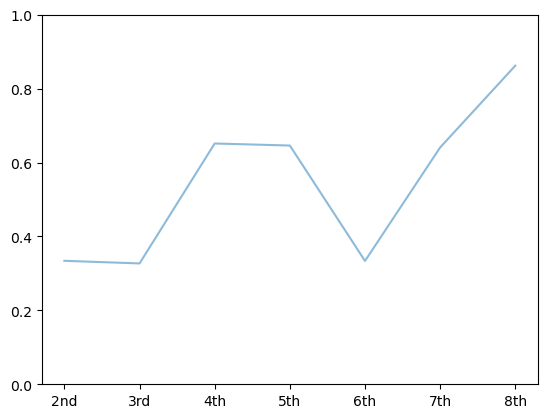

7 <class 'int'>


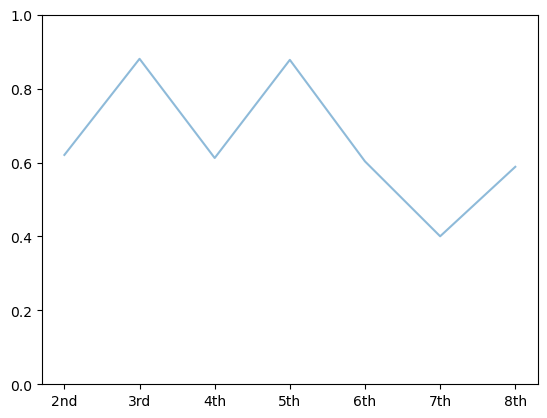

7 <class 'int'>


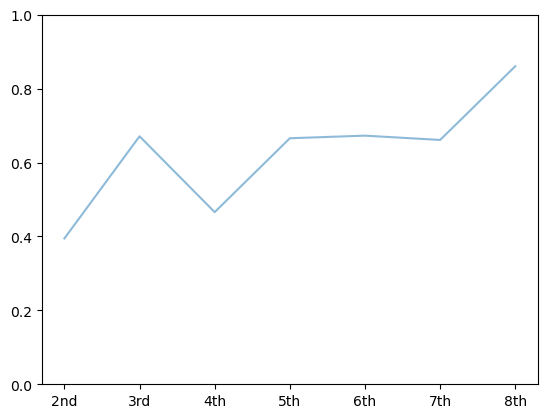

7 <class 'int'>


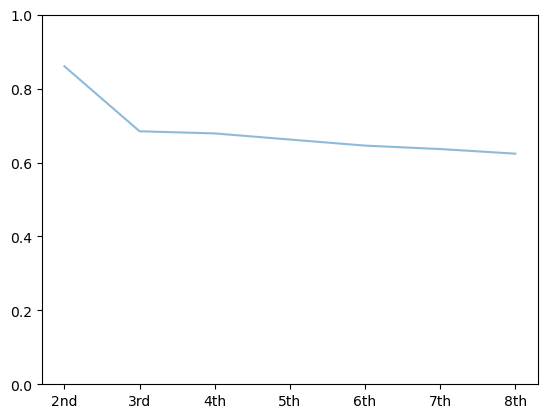

7 <class 'int'>


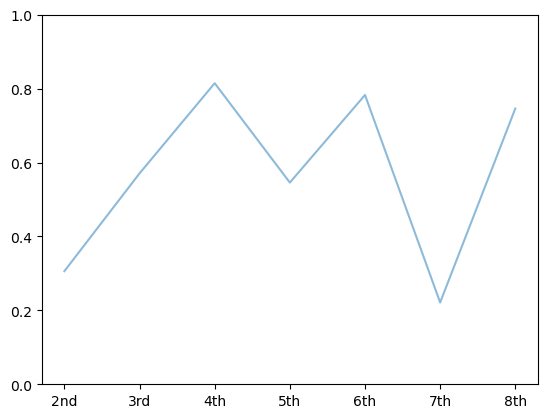

7 <class 'int'>


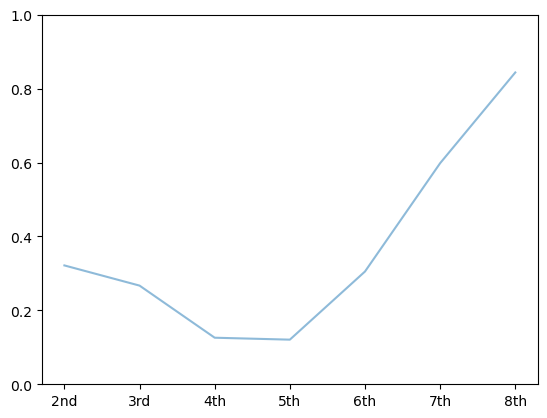

7 <class 'int'>


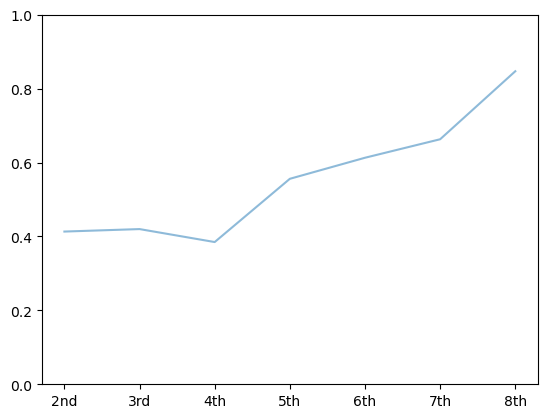

7 <class 'int'>


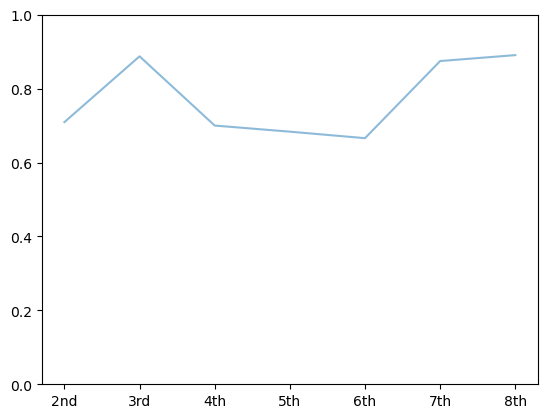

7 <class 'int'>


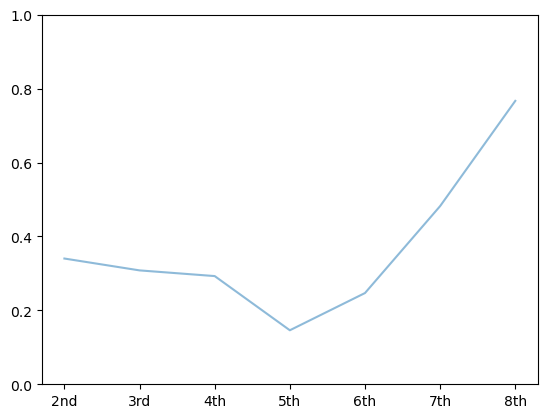

7 <class 'int'>


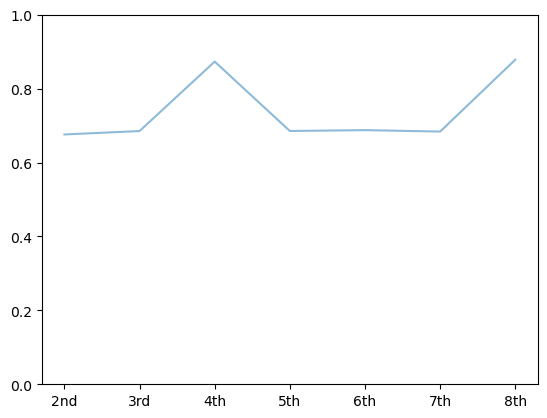

7 <class 'int'>


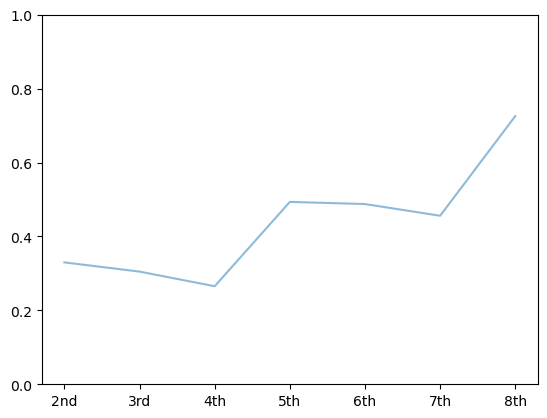

7 <class 'int'>


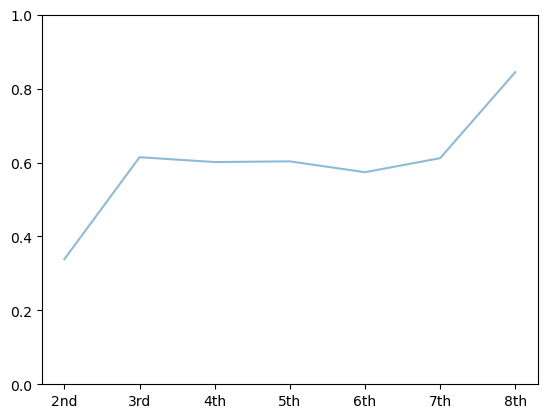

7 <class 'int'>


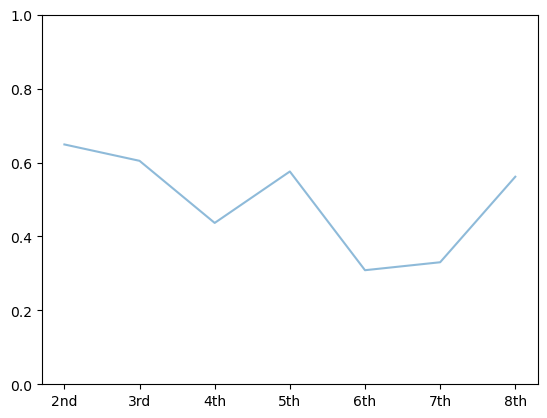

7 <class 'int'>


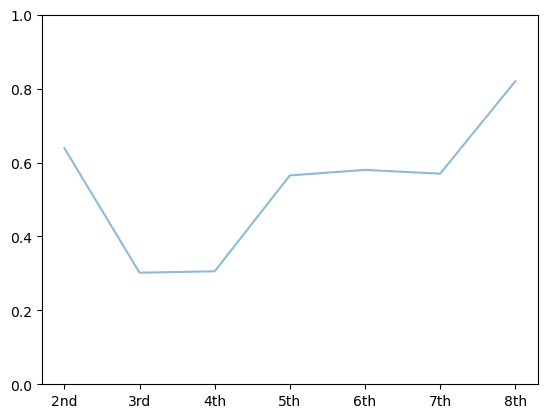

7 <class 'int'>


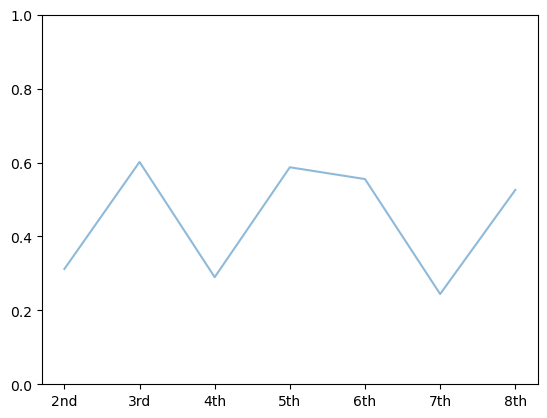

7 <class 'int'>


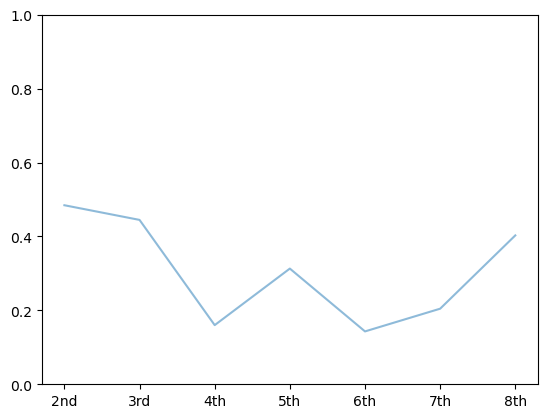

7 <class 'int'>


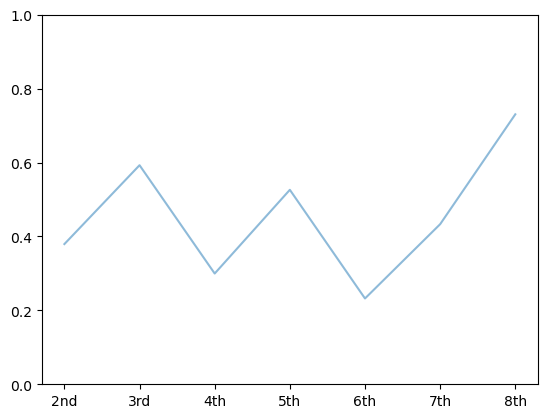

7 <class 'int'>


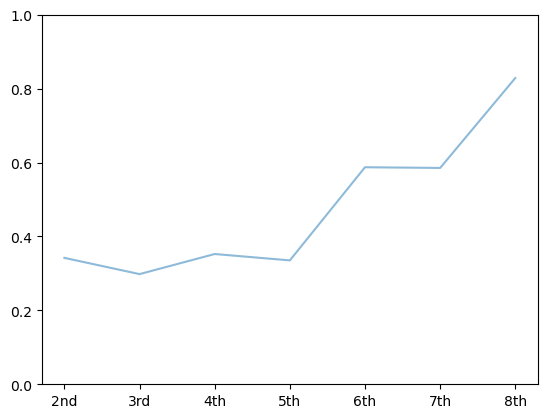

7 <class 'int'>


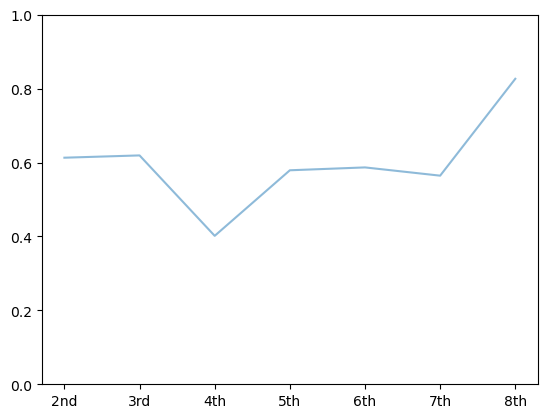

7 <class 'int'>


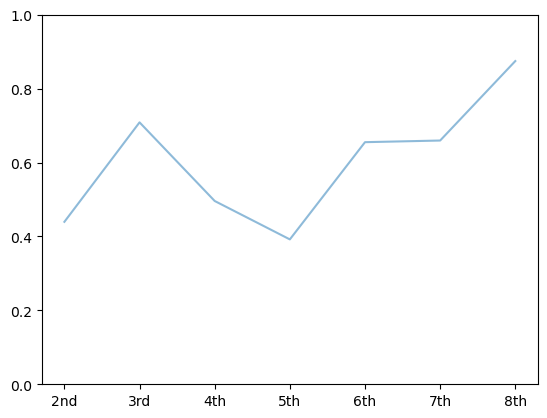

7 <class 'int'>


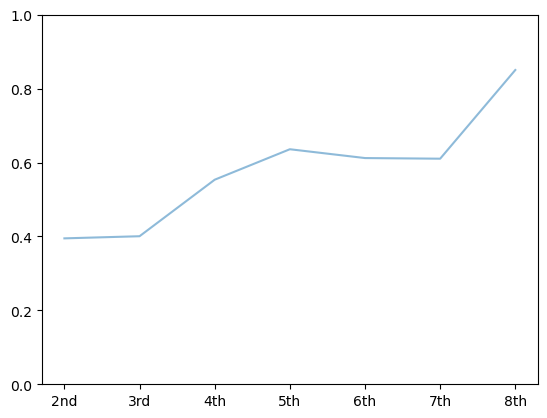

7 <class 'int'>


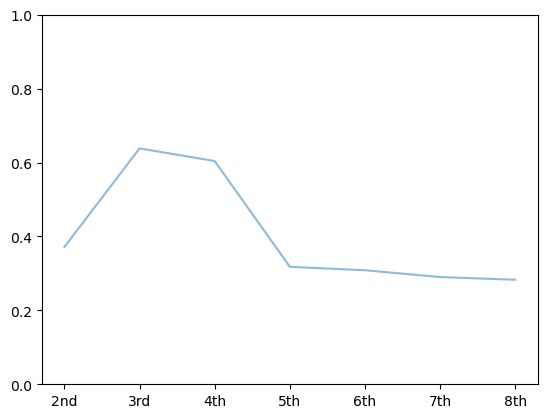

7 <class 'int'>


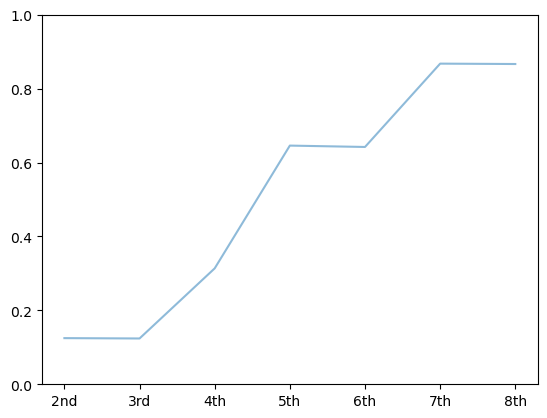

7 <class 'int'>


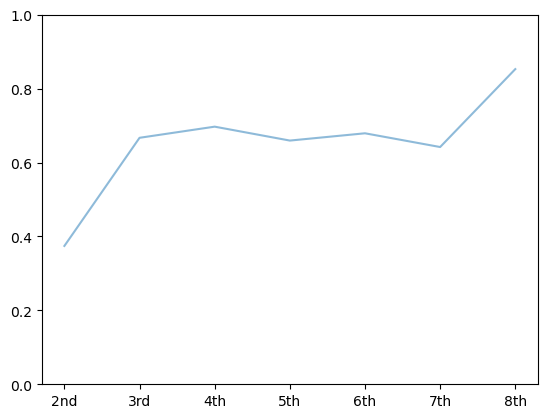

7 <class 'int'>


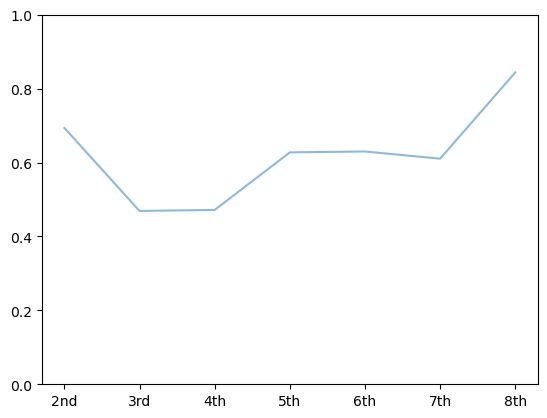

7 <class 'int'>


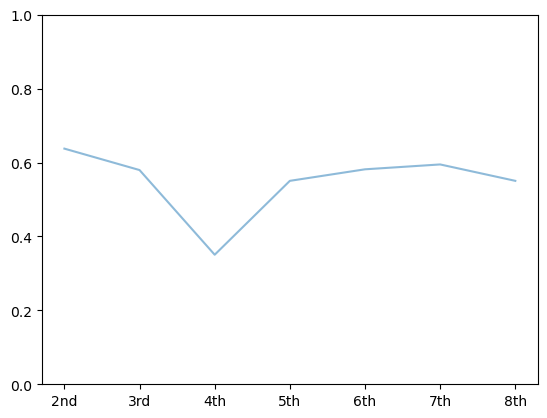

7 <class 'int'>


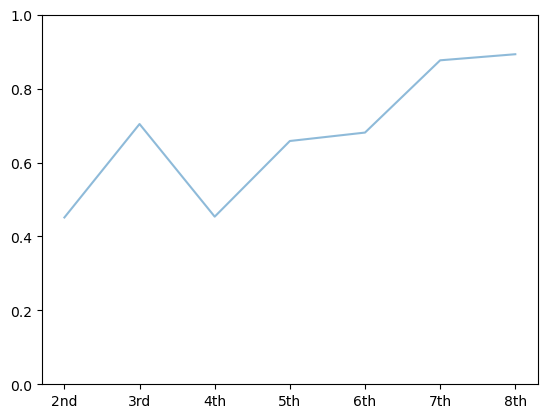

7 <class 'int'>


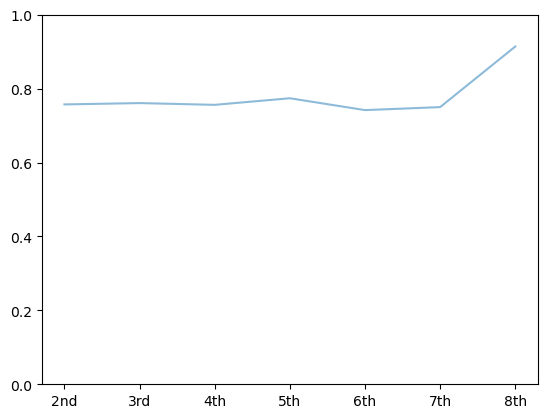

7 <class 'int'>


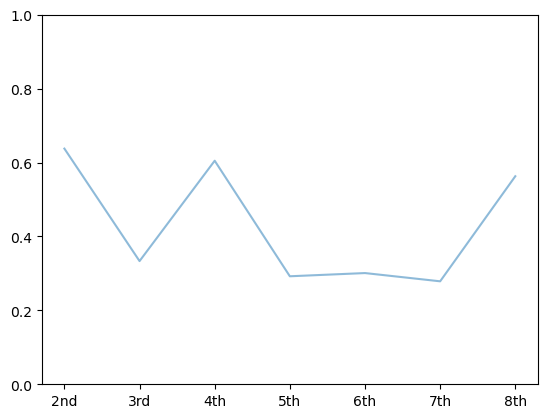

7 <class 'int'>


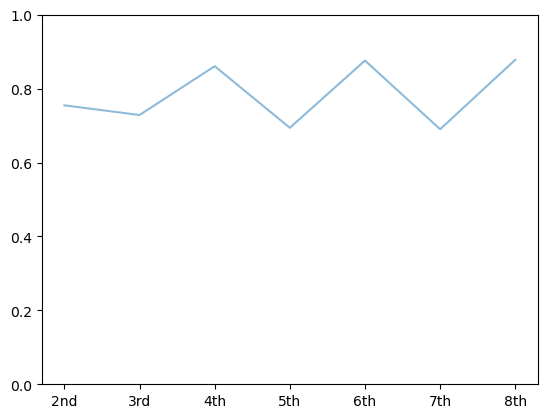

7 <class 'int'>


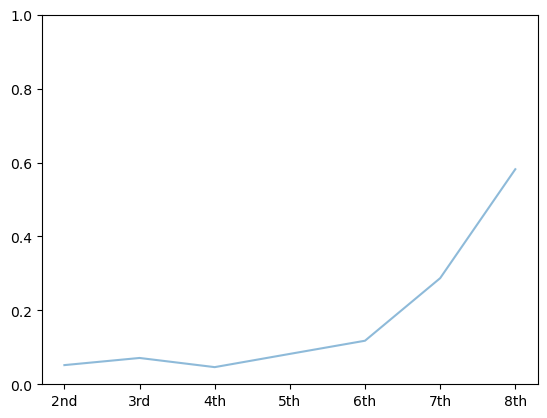

7 <class 'int'>


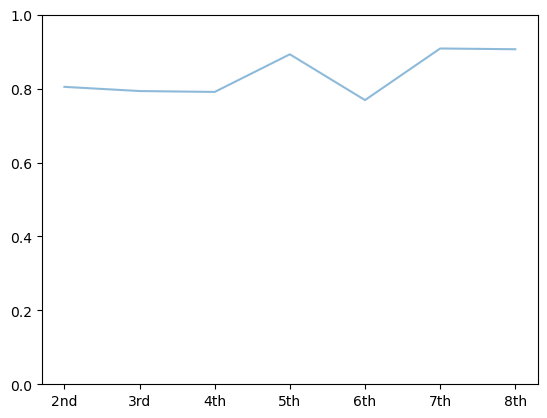

7 <class 'int'>


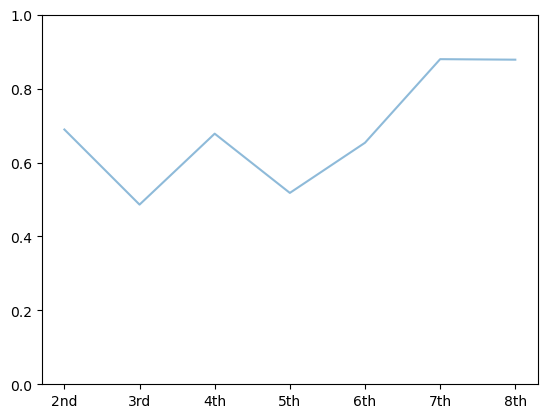

7 <class 'int'>


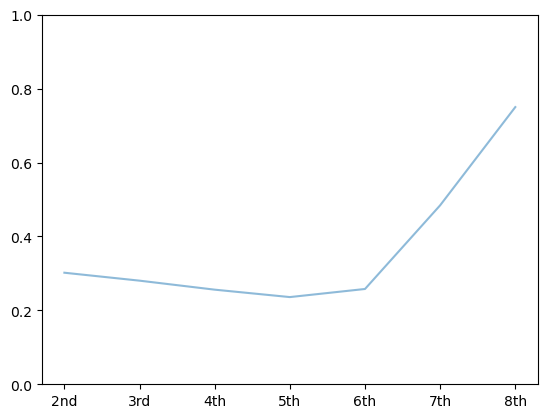

7 <class 'int'>


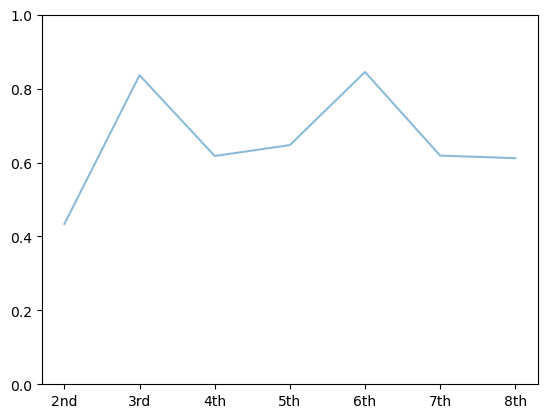

7 <class 'int'>


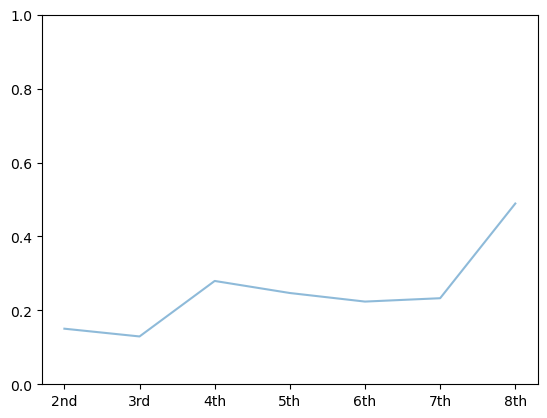

7 <class 'int'>


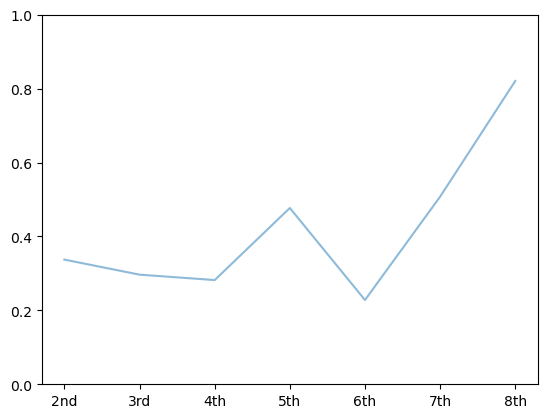

7 <class 'int'>


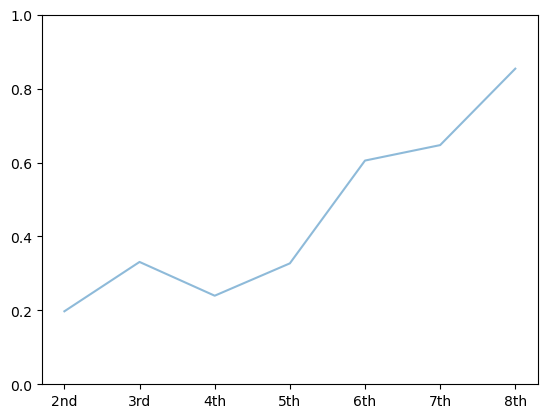

7 <class 'int'>


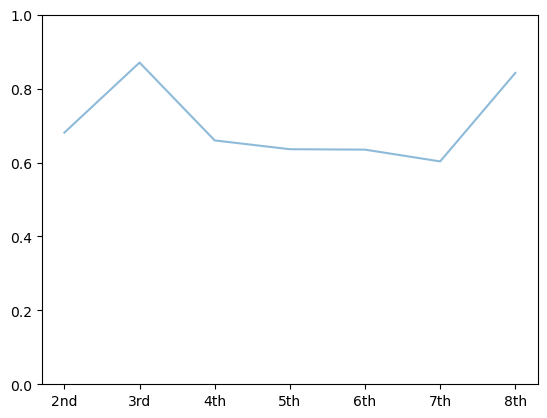

7 <class 'int'>


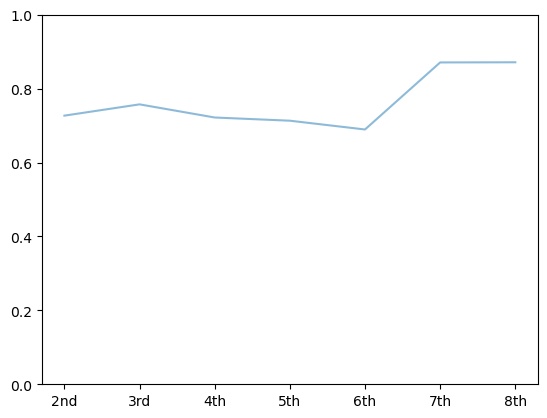

7 <class 'int'>


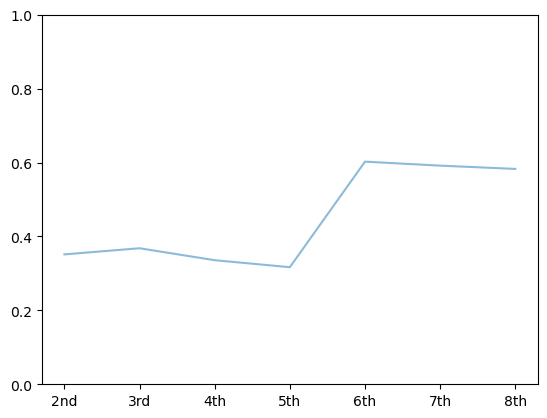

7 <class 'int'>


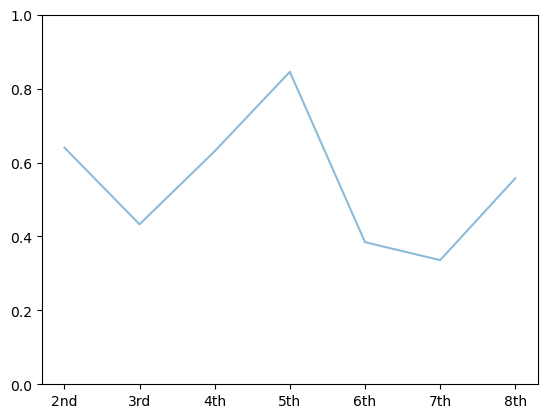

7 <class 'int'>


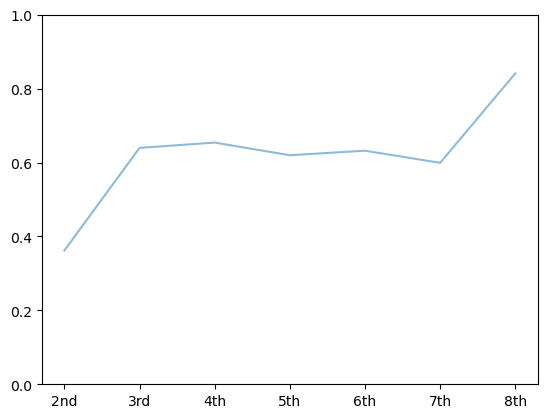

7 <class 'int'>


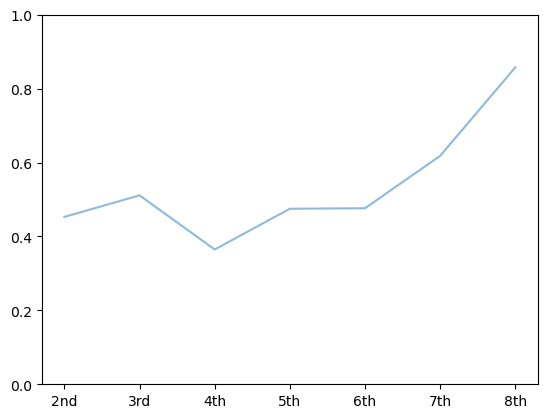

7 <class 'int'>


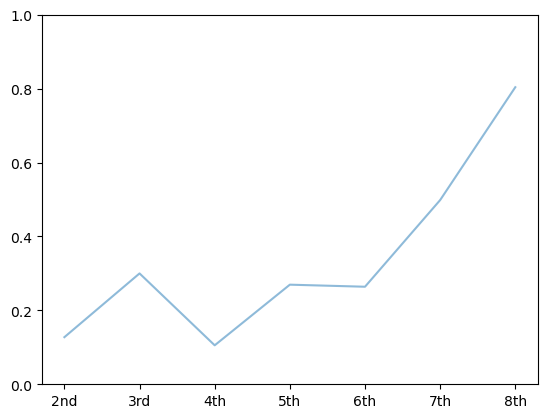

7 <class 'int'>


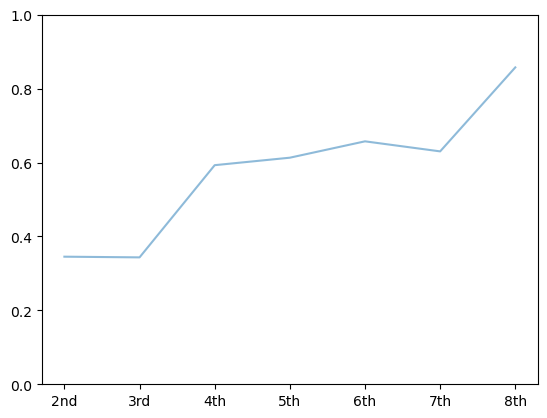

7 <class 'int'>


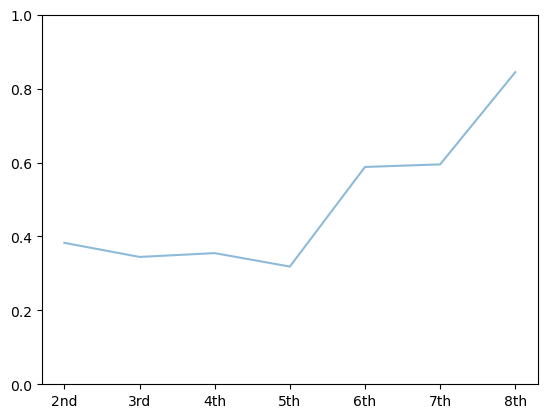

7 <class 'int'>


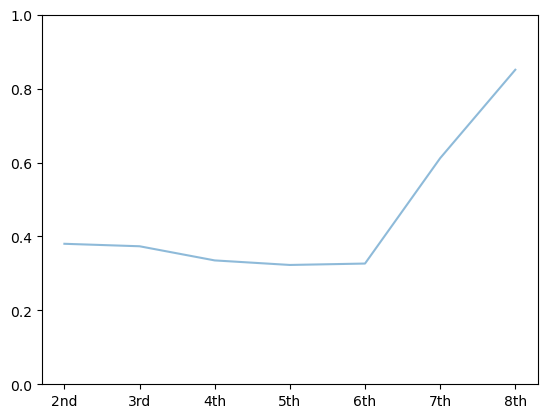

7 <class 'int'>


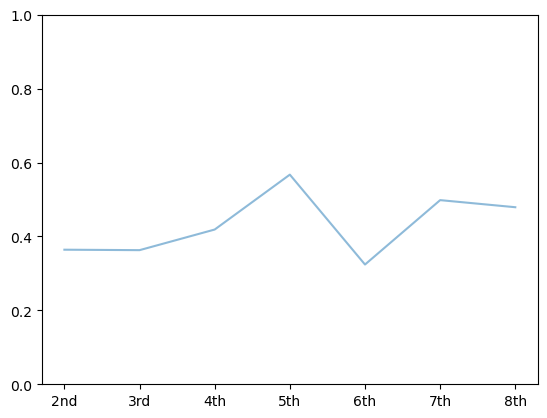

7 <class 'int'>


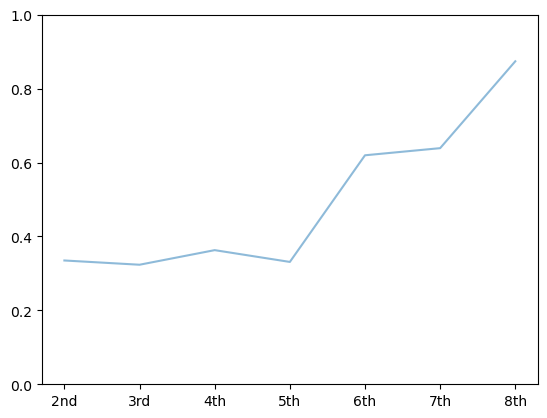

7 <class 'int'>


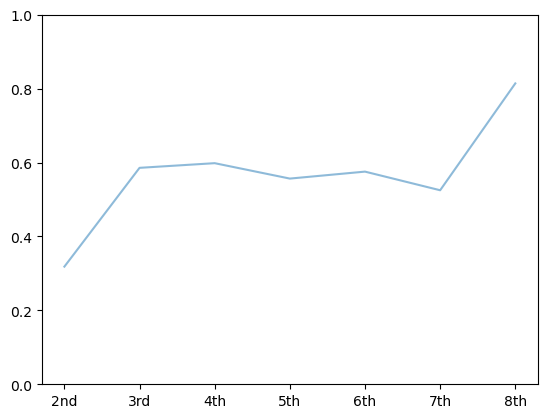

7 <class 'int'>


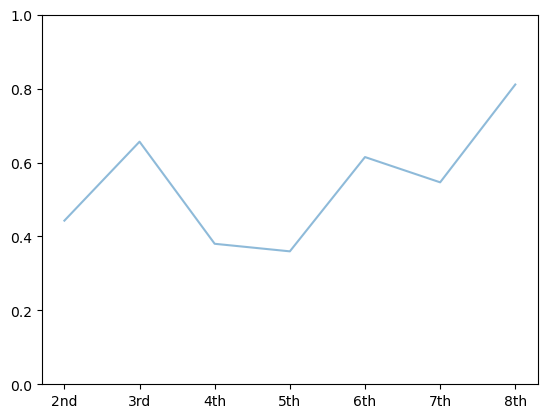

7 <class 'int'>


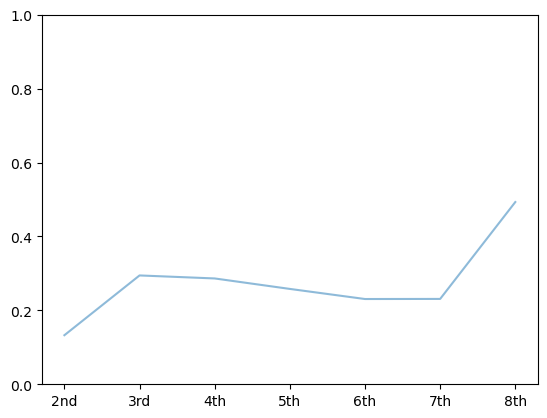

7 <class 'int'>


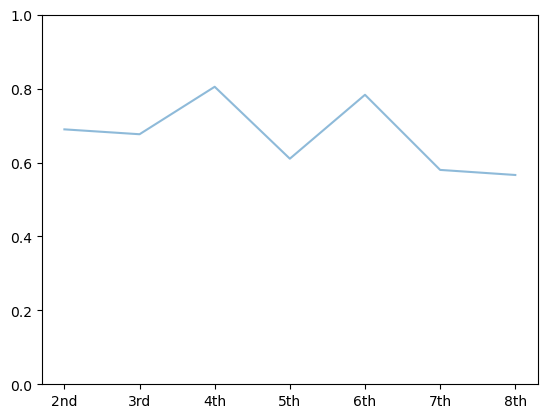

7 <class 'int'>


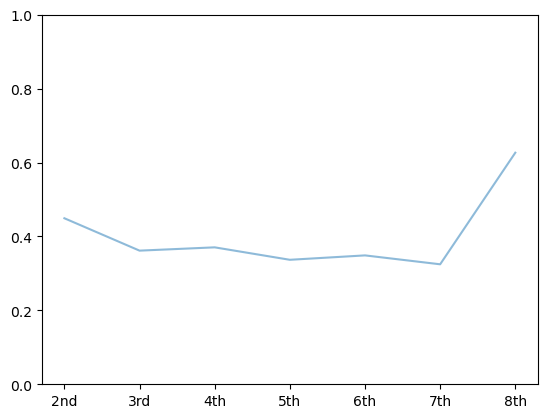

7 <class 'int'>


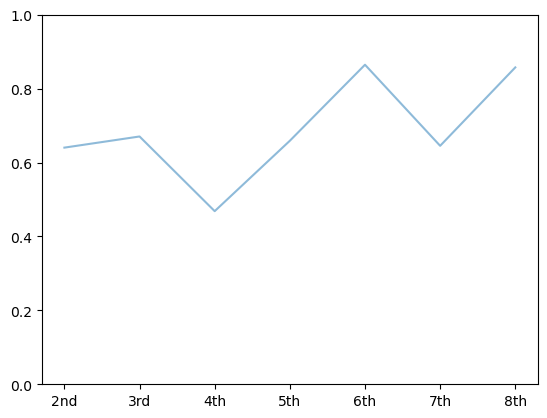

7 <class 'int'>


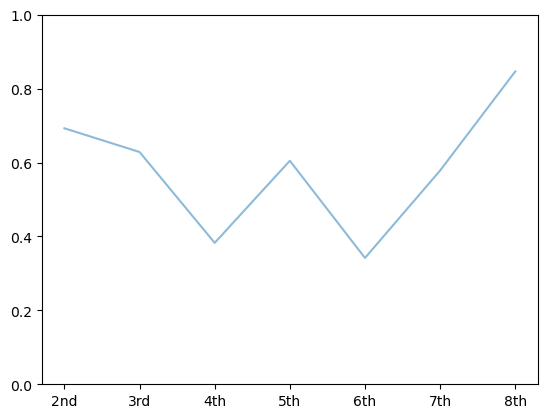

7 <class 'int'>


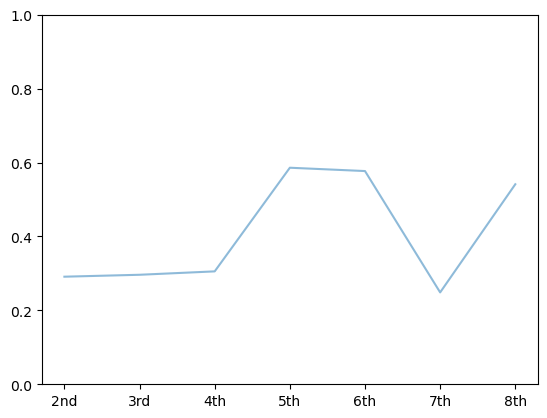

7 <class 'int'>


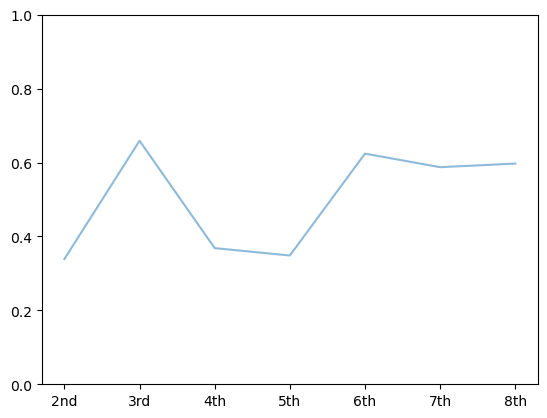

7 <class 'int'>


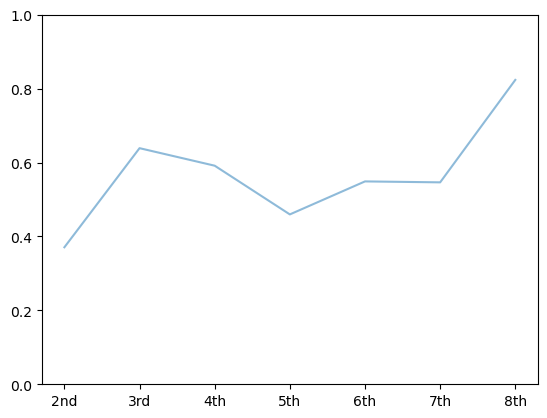

7 <class 'int'>


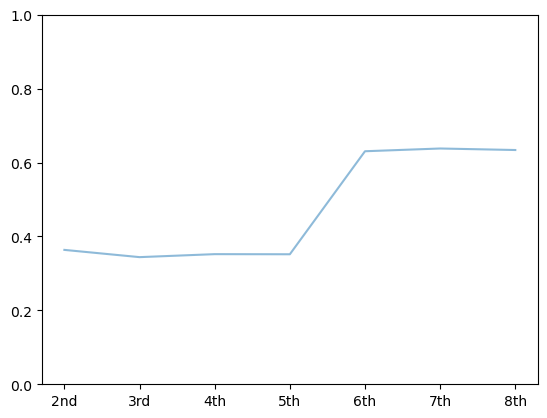

7 <class 'int'>


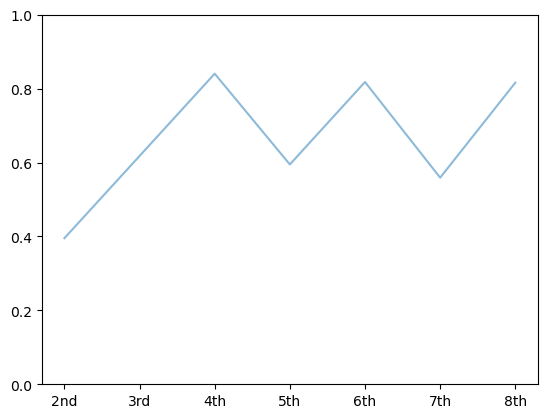

7 <class 'int'>


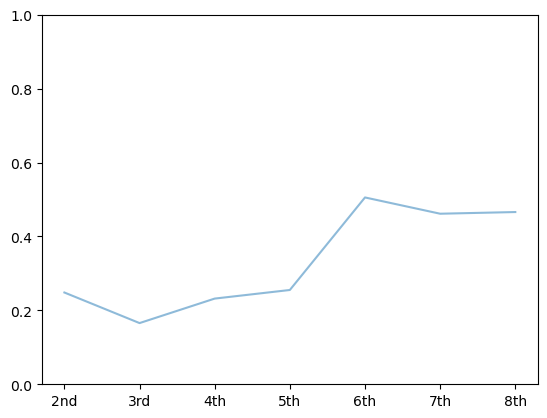

7 <class 'int'>


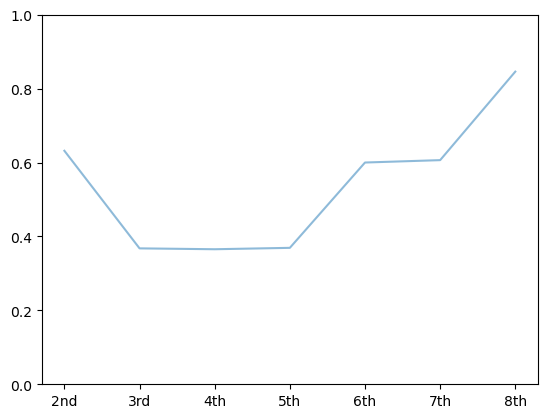

7 <class 'int'>


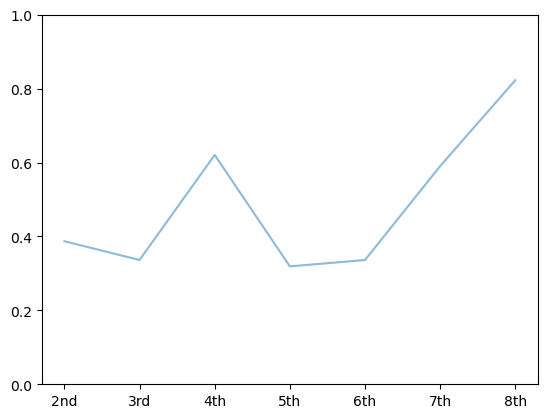

7 <class 'int'>


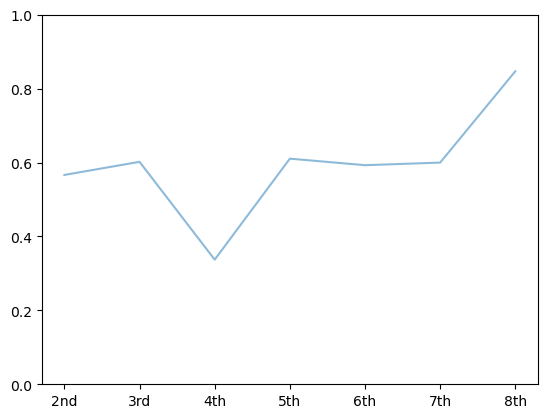

7 <class 'int'>


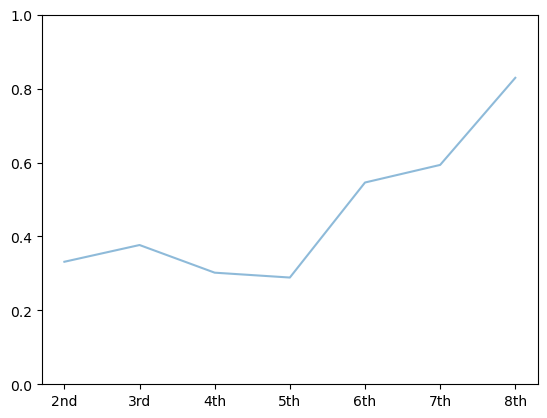

7 <class 'int'>


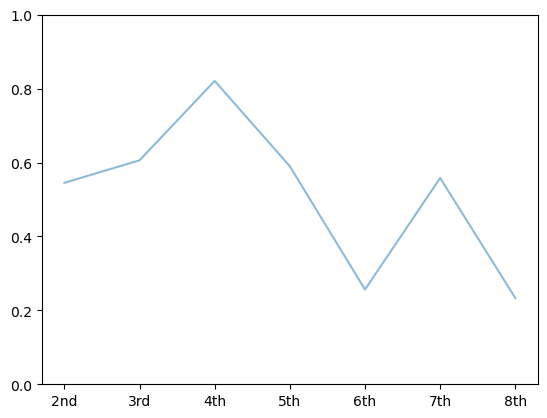

7 <class 'int'>


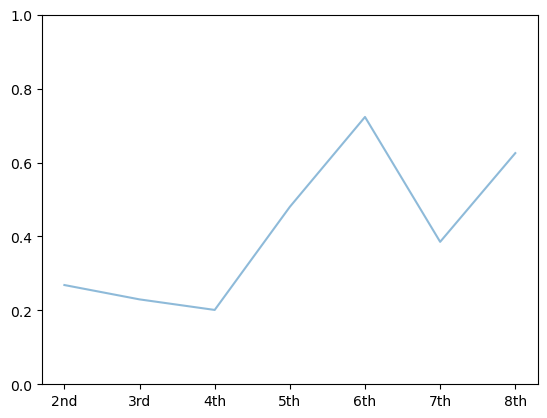

7 <class 'int'>


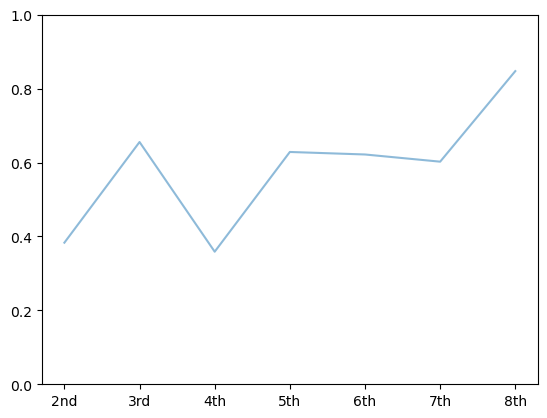

7 <class 'int'>


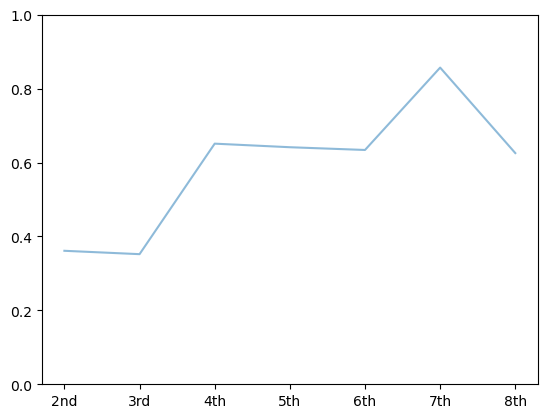

7 <class 'int'>


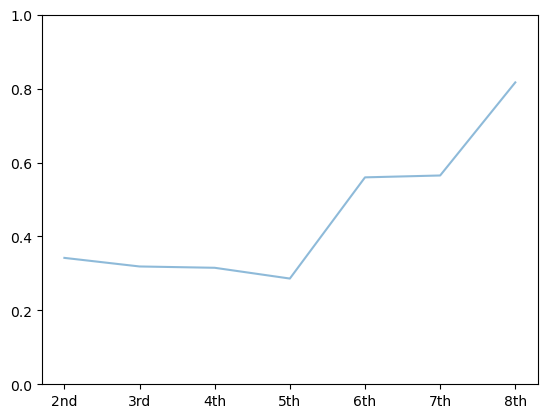

7 <class 'int'>


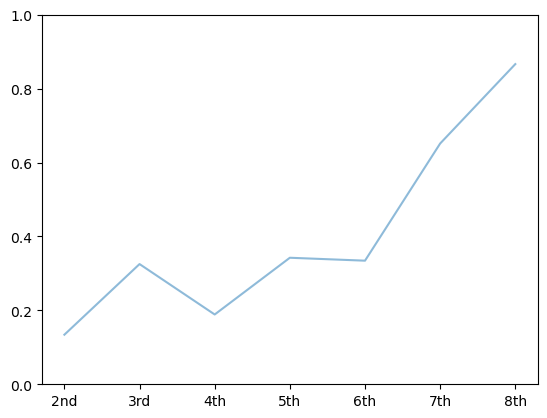

7 <class 'int'>


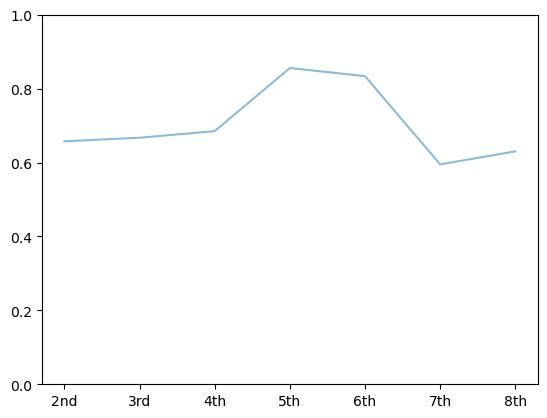

7 <class 'int'>


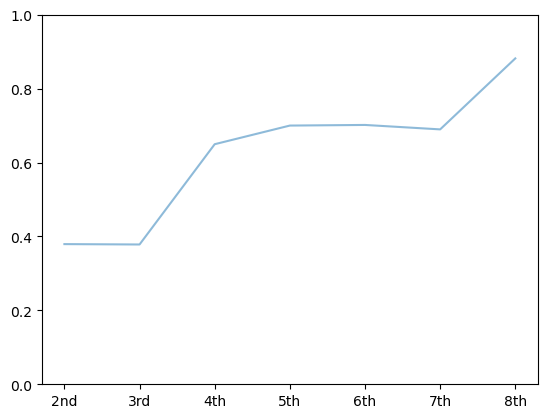

7 <class 'int'>


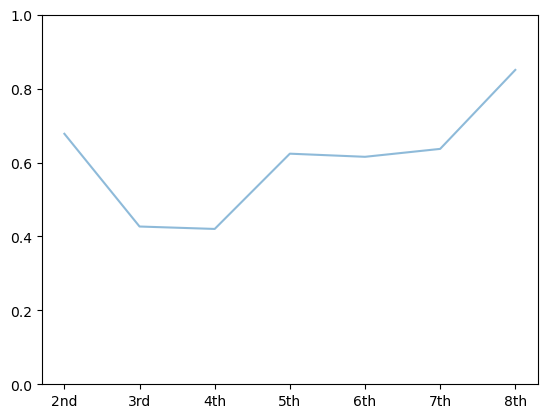

7 <class 'int'>


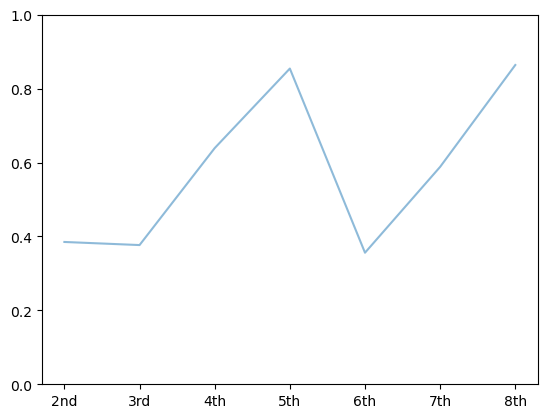

7 <class 'int'>


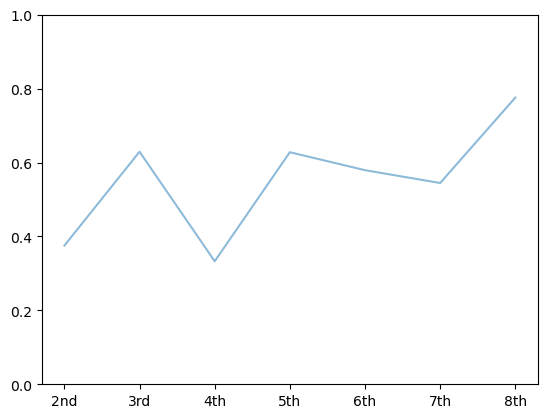

7 <class 'int'>


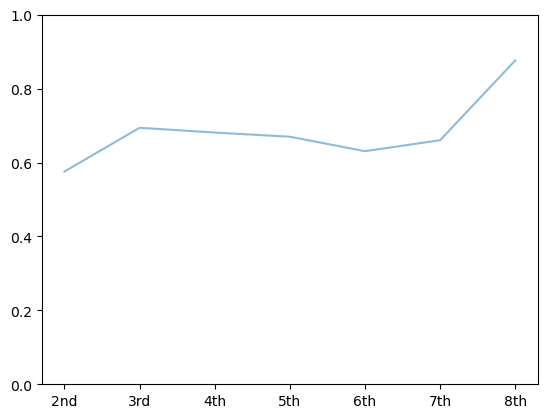

7 <class 'int'>


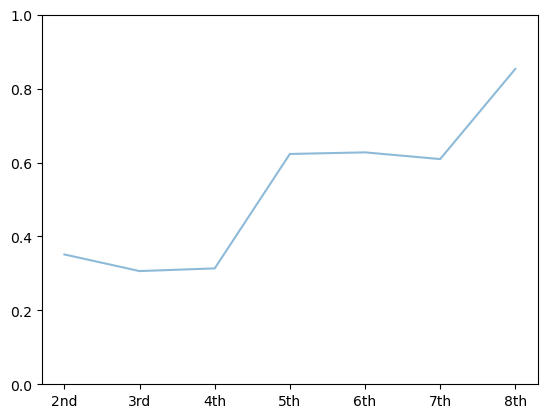

7 <class 'int'>


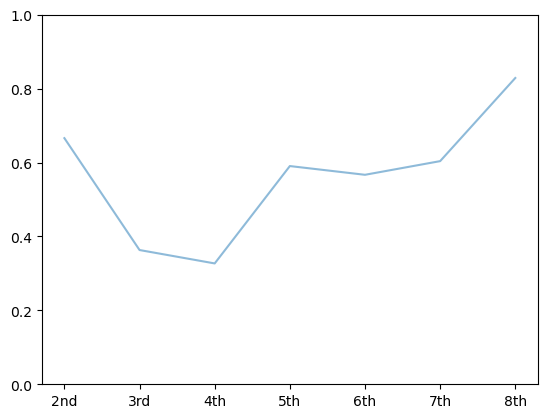

7 <class 'int'>


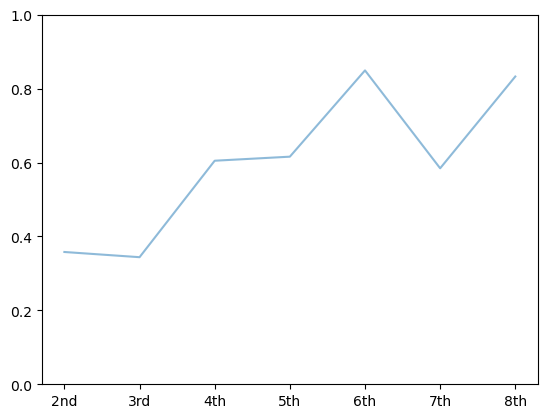

7 <class 'int'>


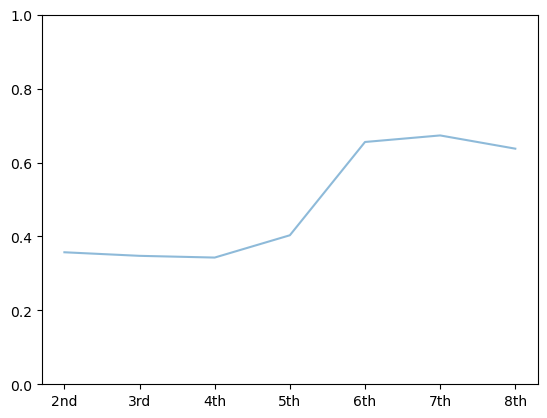

7 <class 'int'>


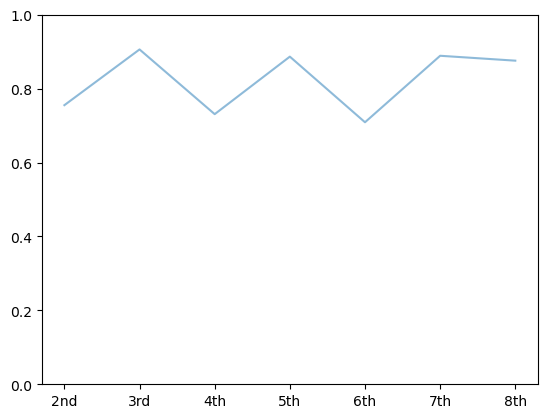

7 <class 'int'>


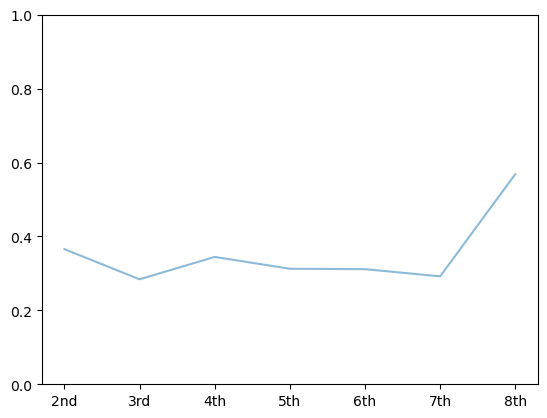

7 <class 'int'>


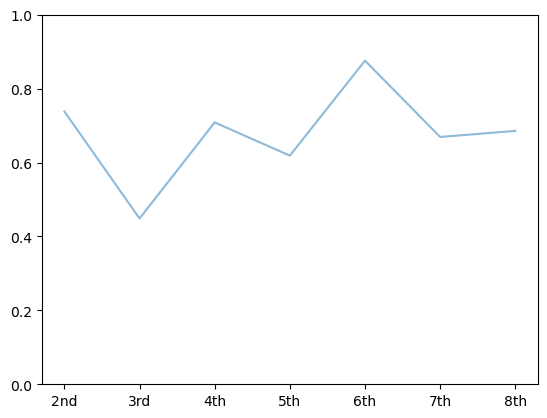

7 <class 'int'>


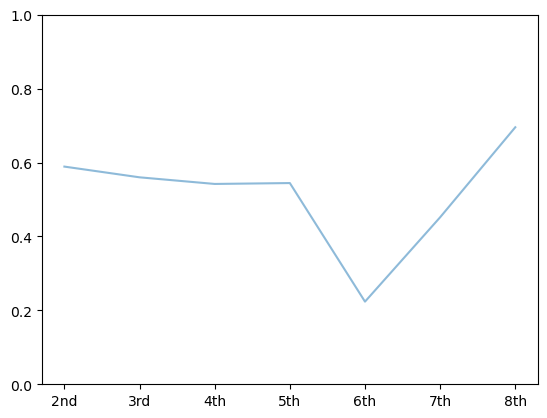

7 <class 'int'>


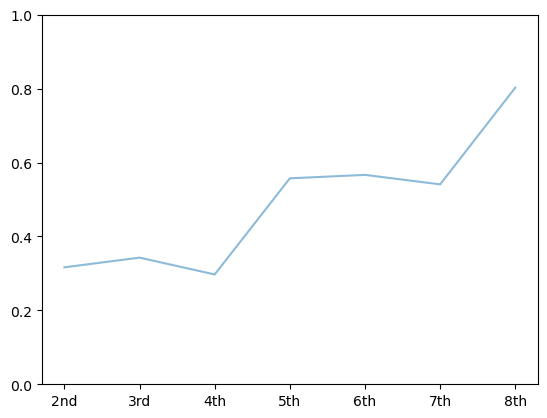

7 <class 'int'>


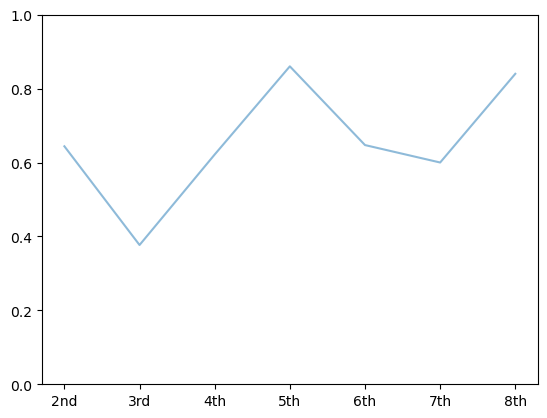

7 <class 'int'>


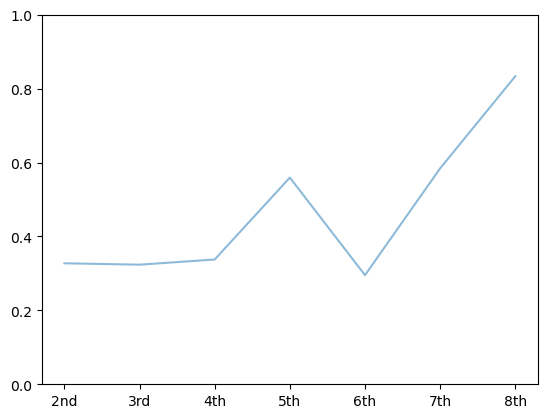

7 <class 'int'>


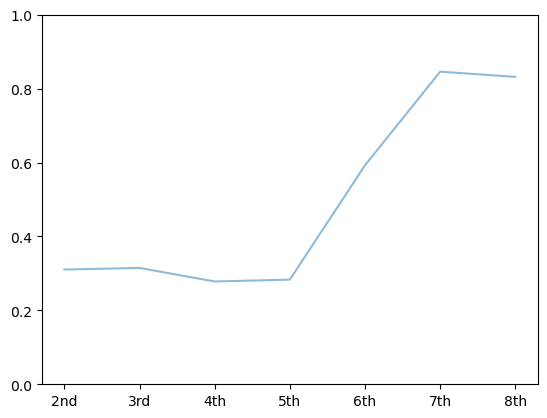

7 <class 'int'>


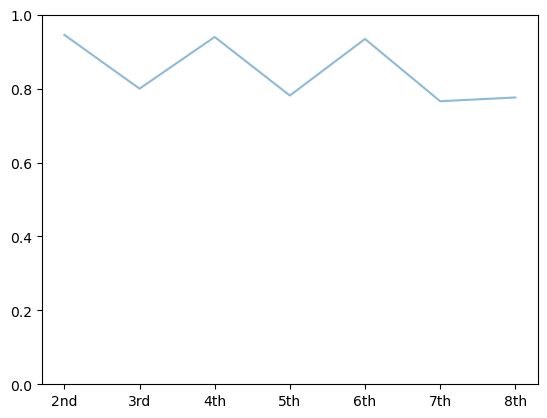

7 <class 'int'>


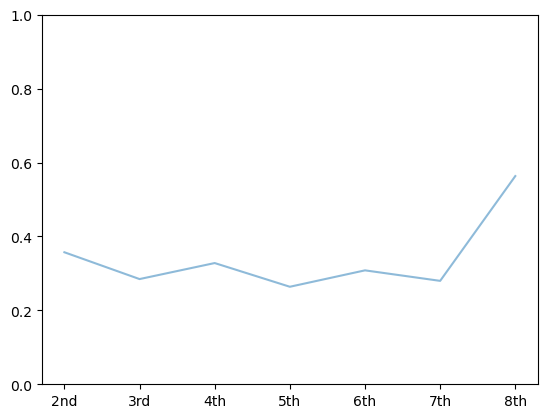

7 <class 'int'>


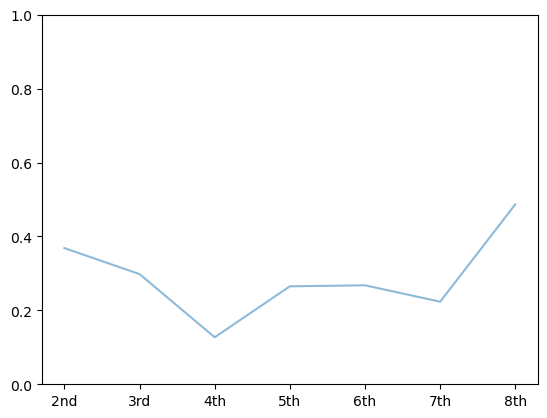

7 <class 'int'>


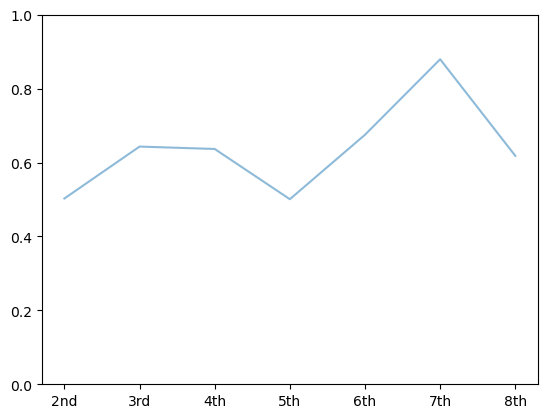

7 <class 'int'>


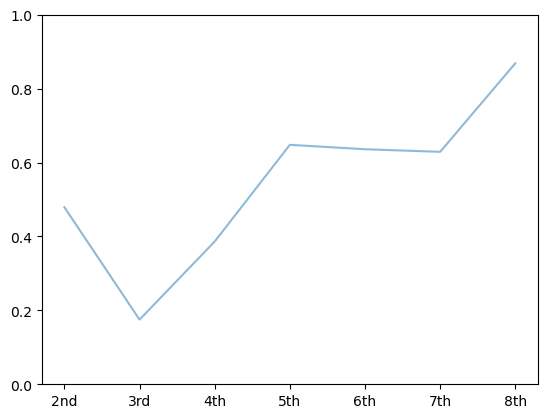

7 <class 'int'>


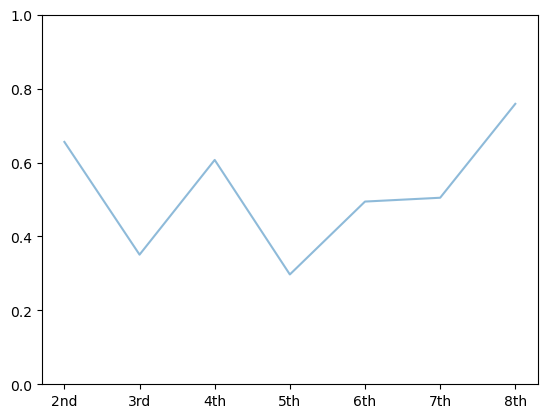

7 <class 'int'>


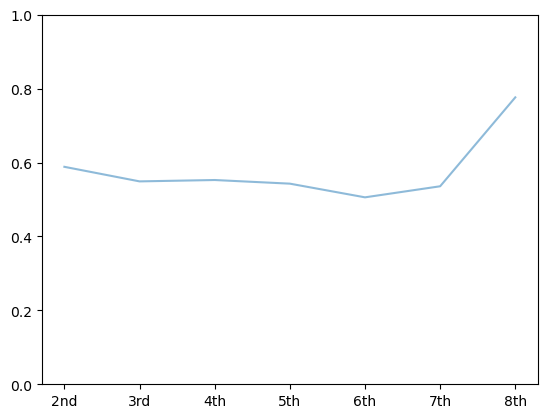

7 <class 'int'>


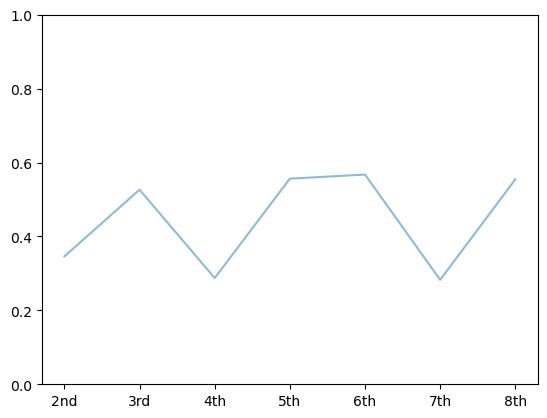

7 <class 'int'>


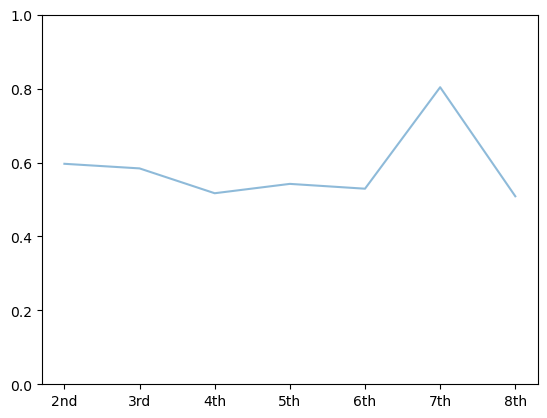

7 <class 'int'>


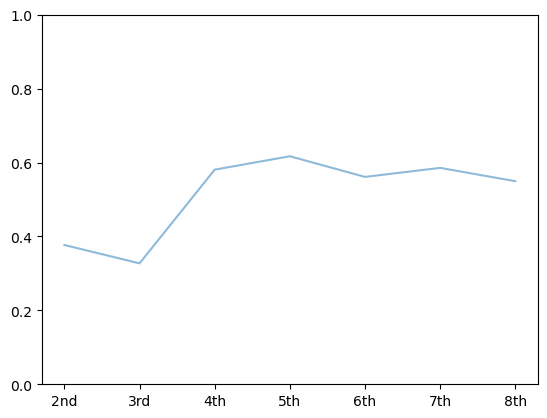

7 <class 'int'>


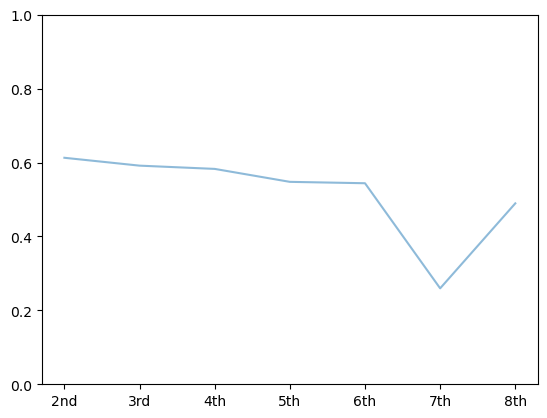

7 <class 'int'>


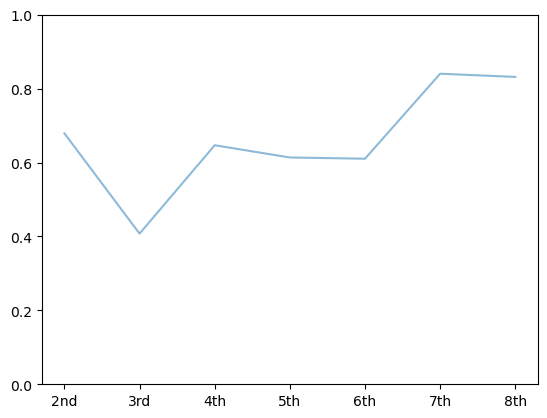

7 <class 'int'>


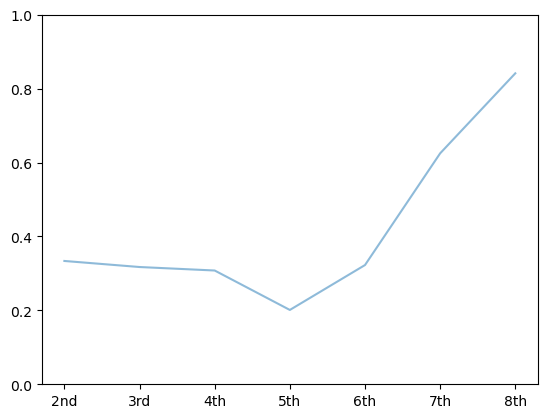

7 <class 'int'>


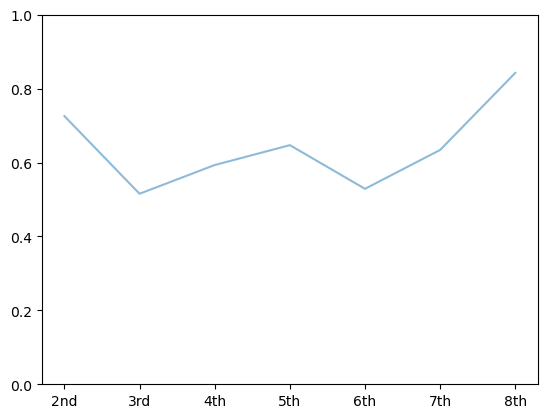

7 <class 'int'>


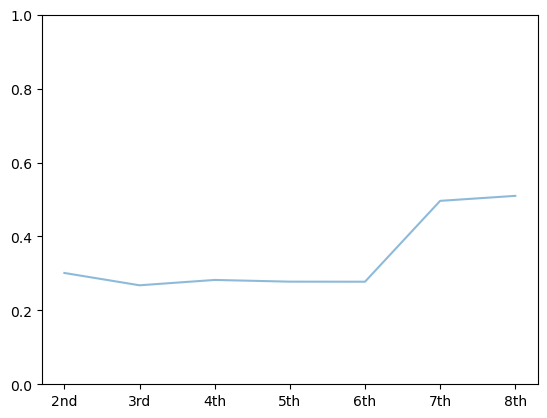

7 <class 'int'>


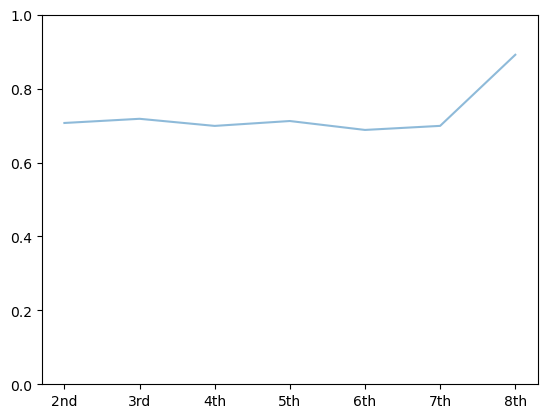

7 <class 'int'>


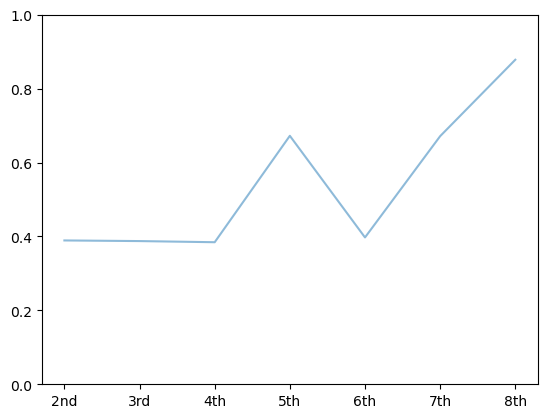

7 <class 'int'>


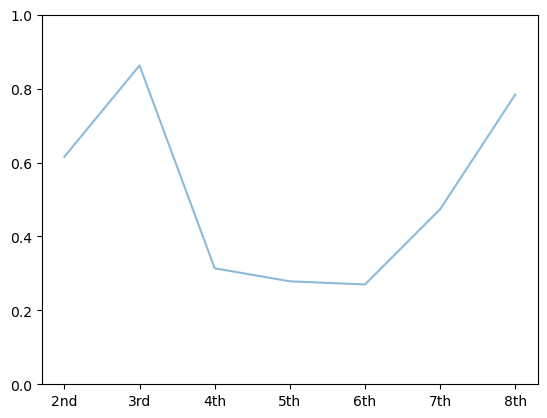

7 <class 'int'>


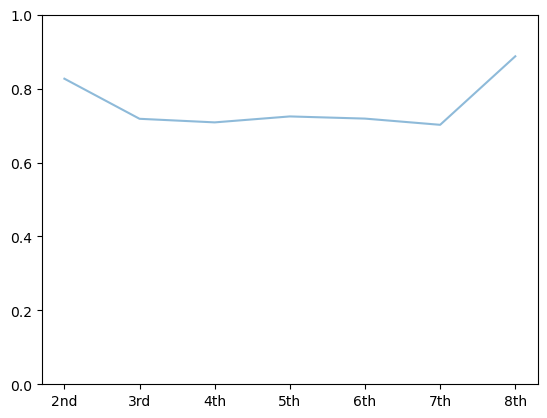

7 <class 'int'>


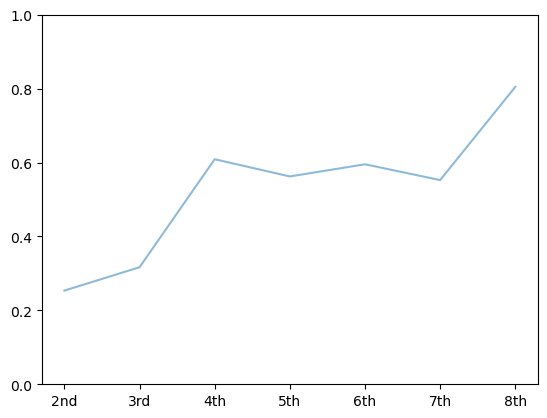

7 <class 'int'>


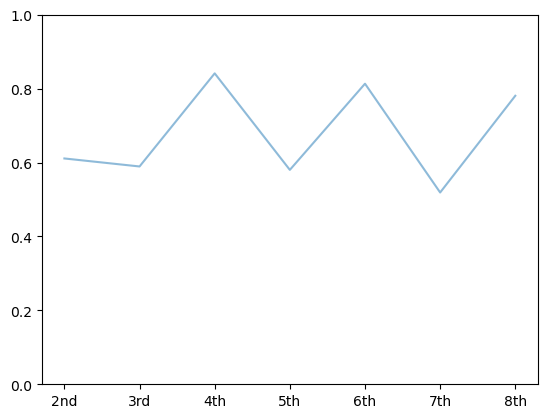

7 <class 'int'>


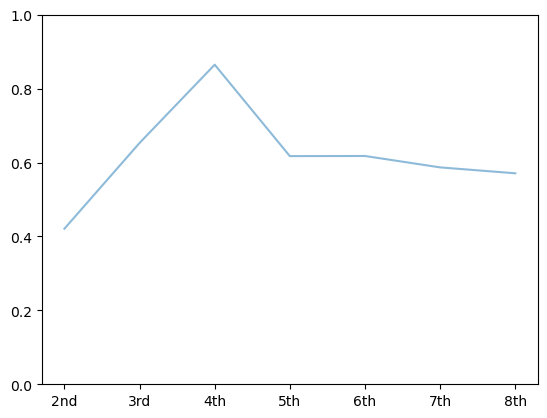

7 <class 'int'>


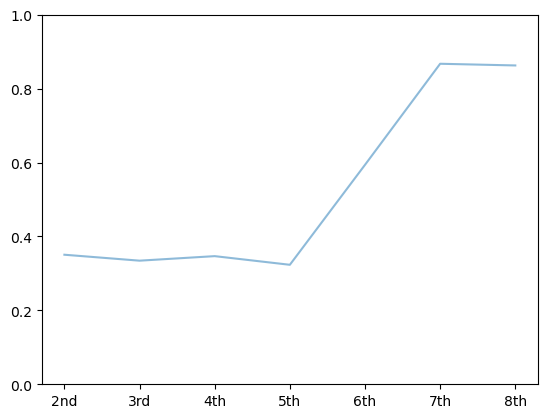

7 <class 'int'>


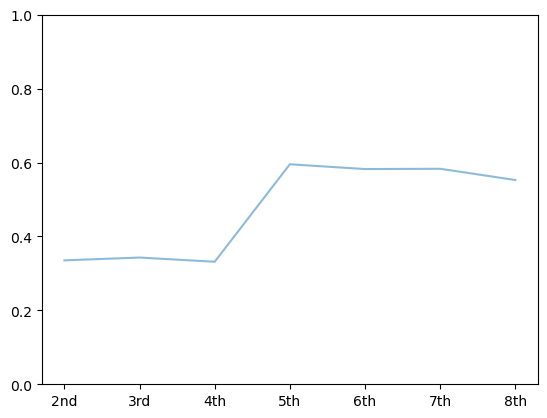

7 <class 'int'>


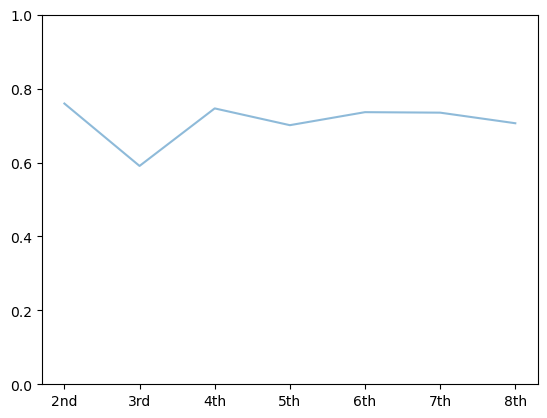

7 <class 'int'>


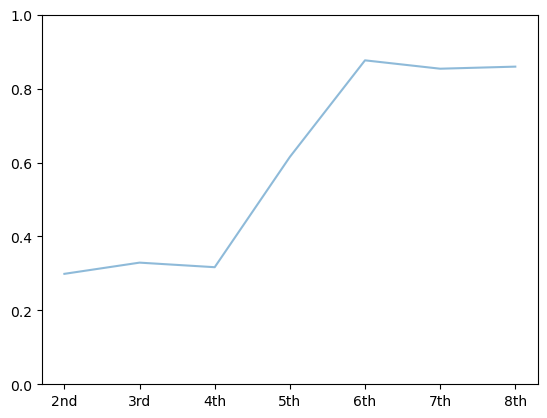

7 <class 'int'>


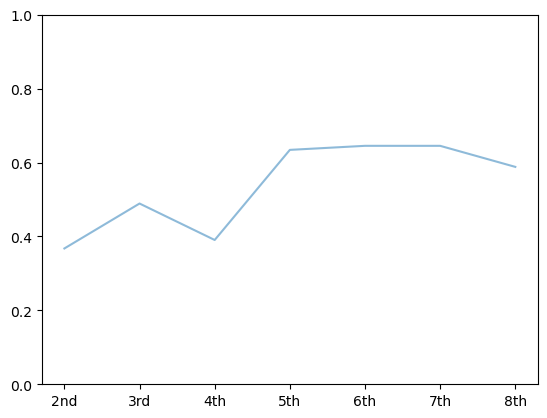

7 <class 'int'>


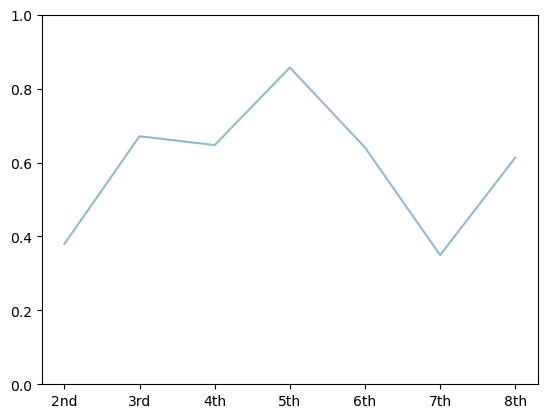

7 <class 'int'>


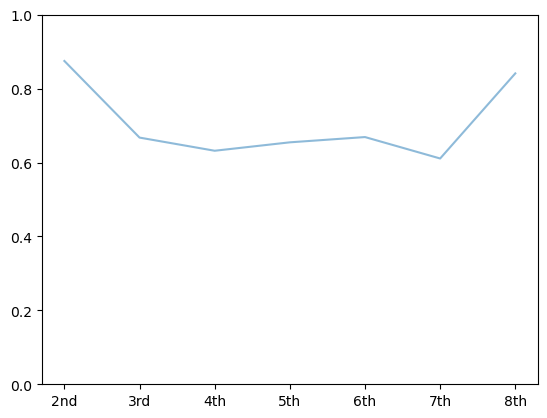

7 <class 'int'>


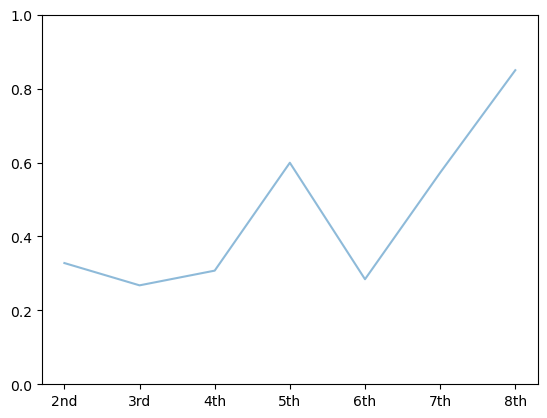

7 <class 'int'>


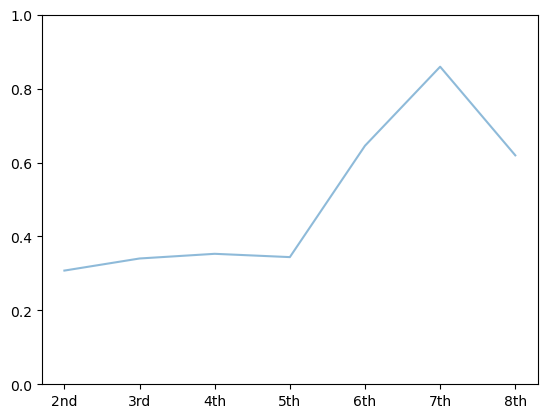

7 <class 'int'>


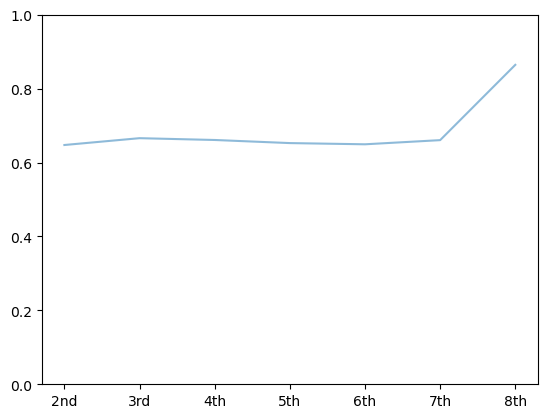

7 <class 'int'>


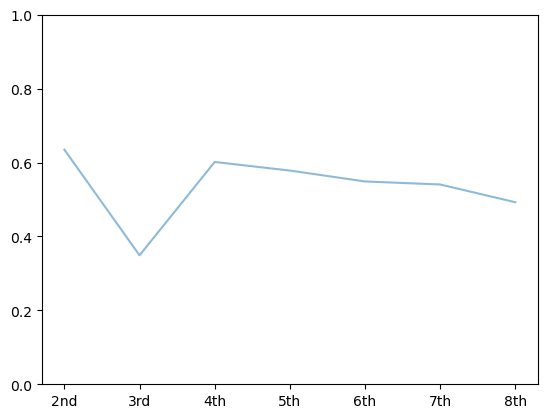

7 <class 'int'>


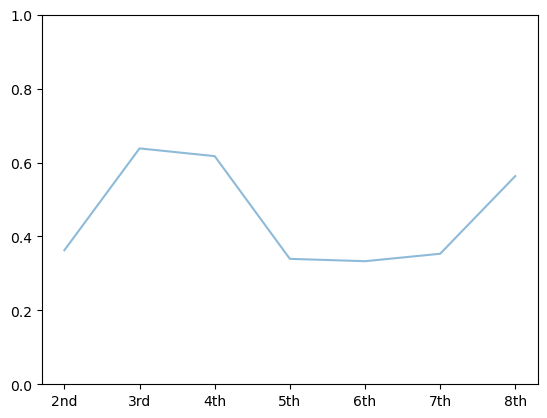

7 <class 'int'>


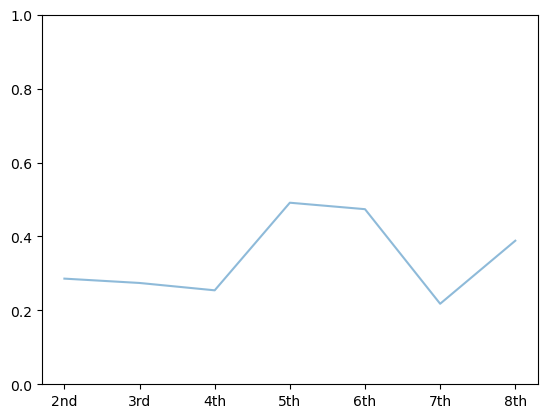

7 <class 'int'>


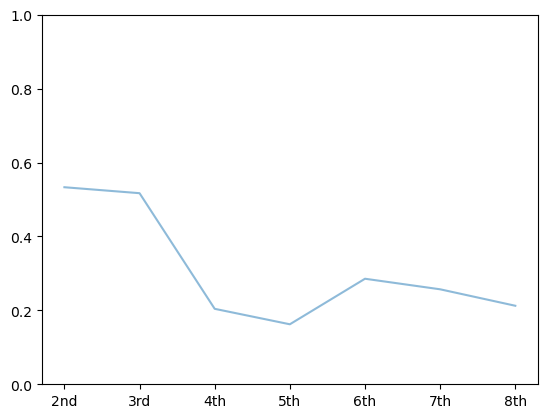

7 <class 'int'>


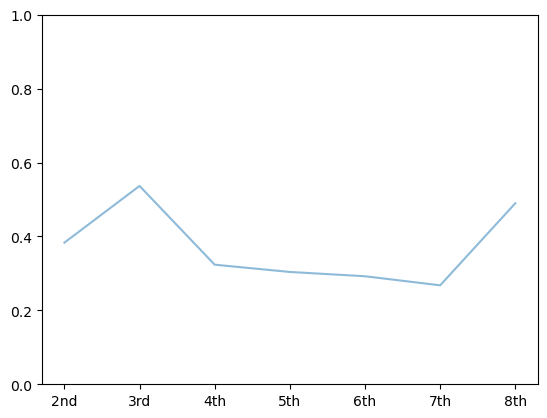

7 <class 'int'>


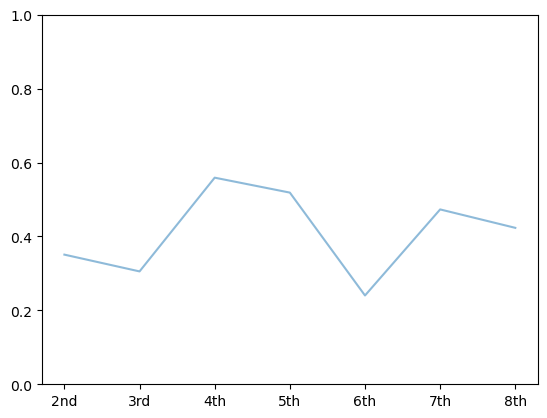

7 <class 'int'>


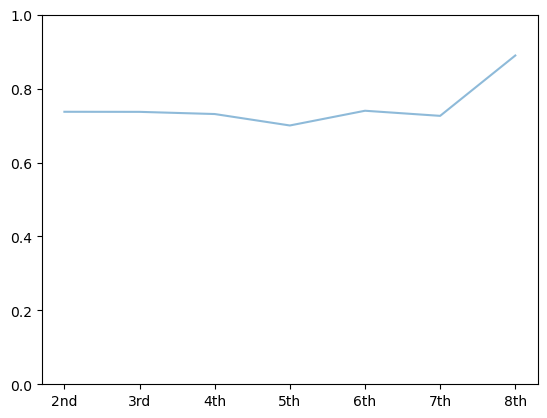

7 <class 'int'>


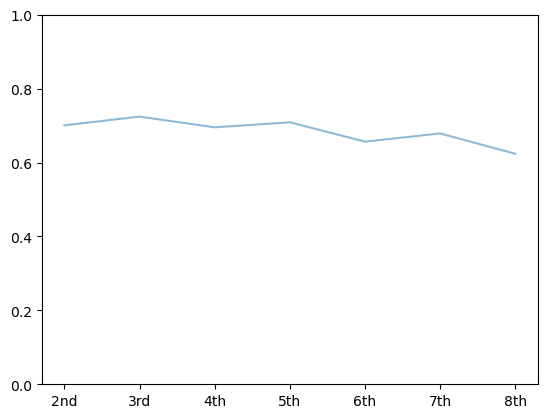

7 <class 'int'>


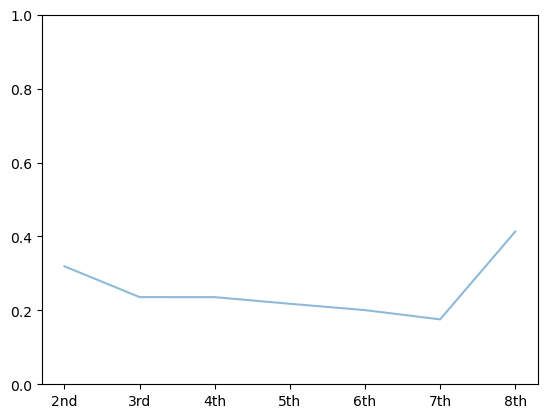

7 <class 'int'>


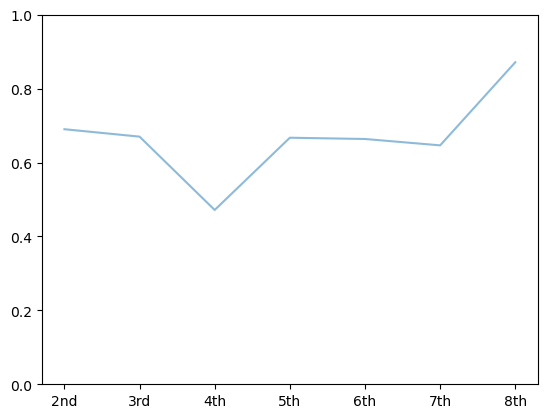

7 <class 'int'>


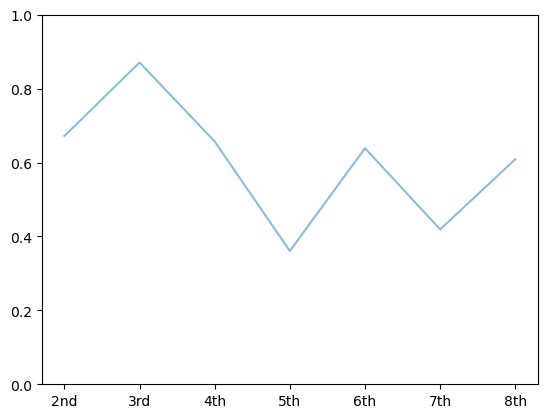

7 <class 'int'>


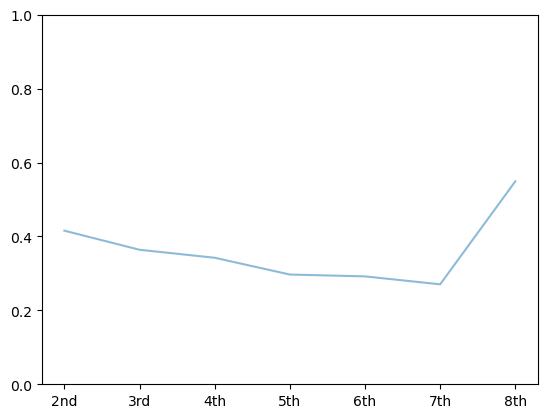

7 <class 'int'>


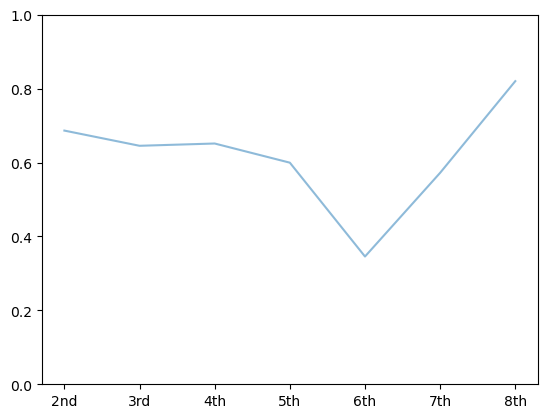

7 <class 'int'>


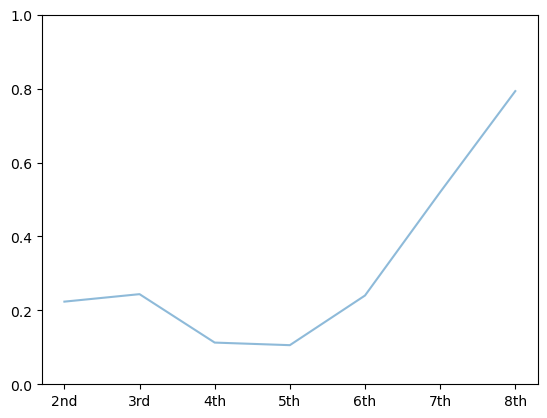

7 <class 'int'>


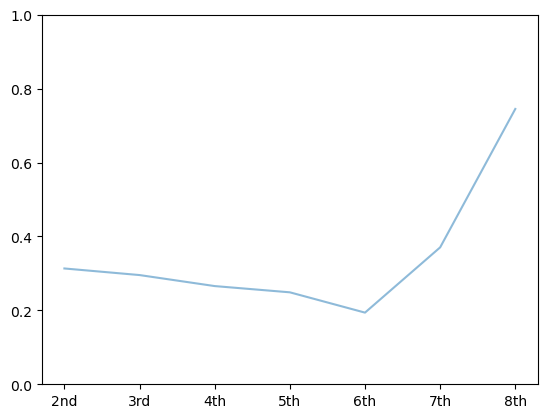

7 <class 'int'>


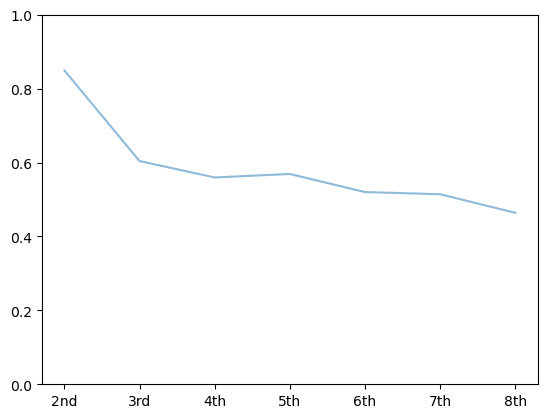

7 <class 'int'>


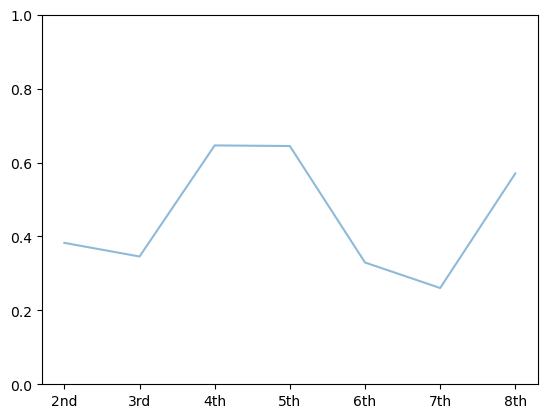

7 <class 'int'>


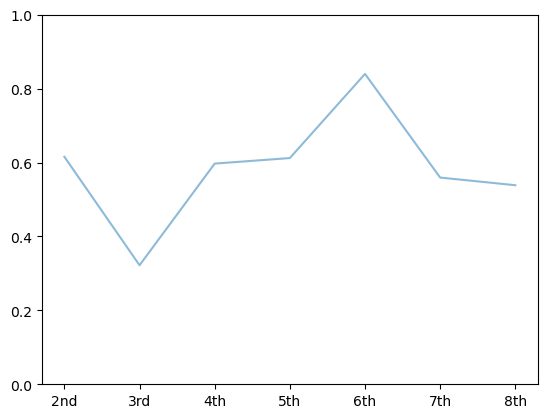

7 <class 'int'>


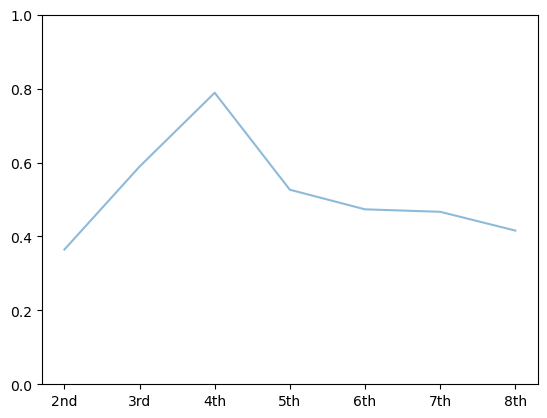

7 <class 'int'>


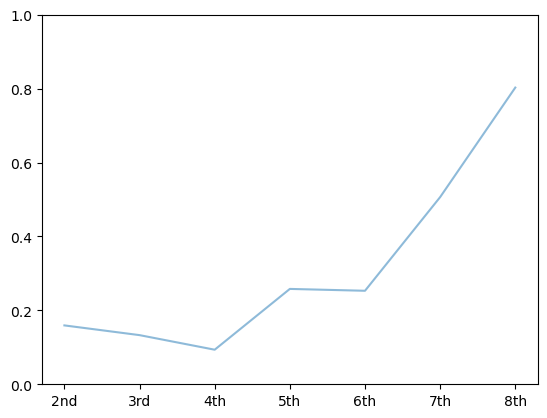

7 <class 'int'>


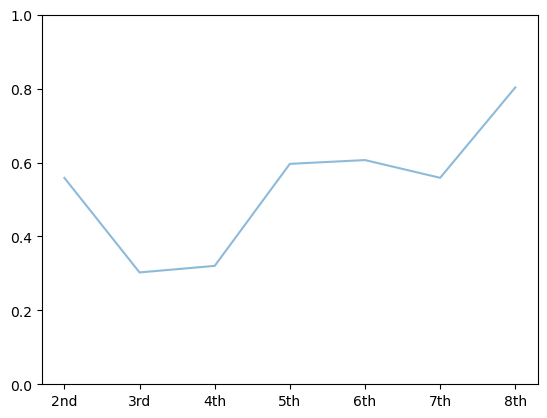

7 <class 'int'>


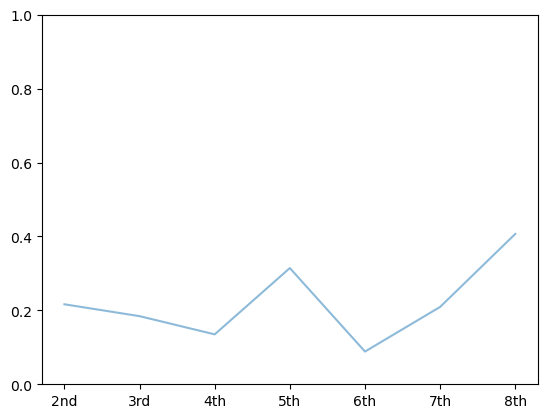

7 <class 'int'>


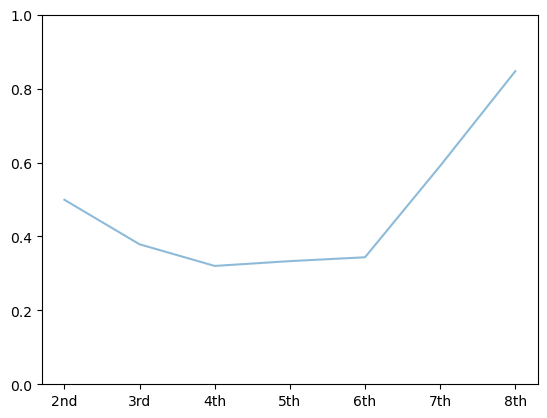

7 <class 'int'>


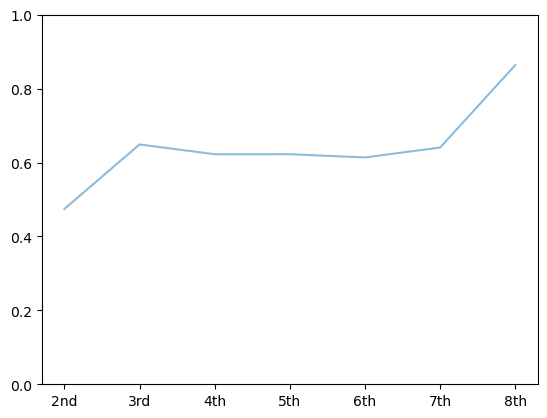

7 <class 'int'>


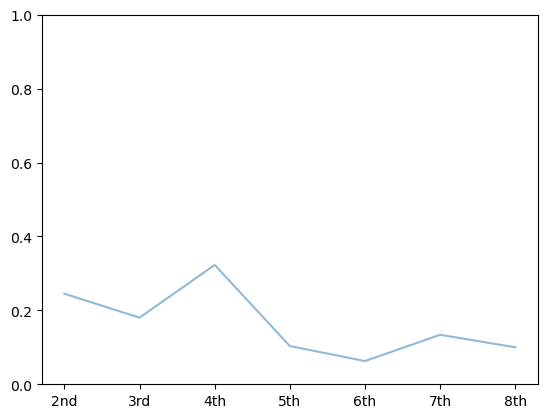

7 <class 'int'>


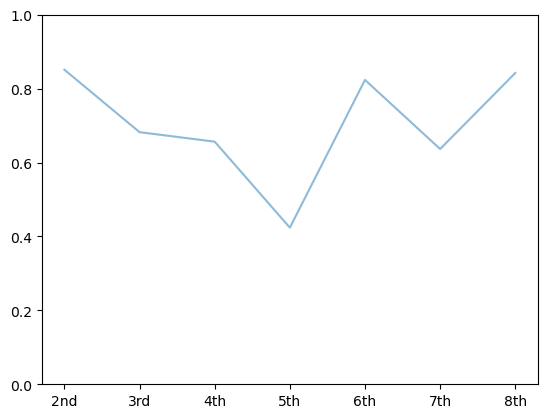

7 <class 'int'>


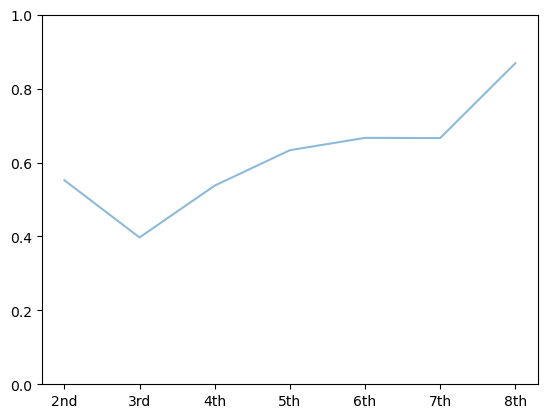

7 <class 'int'>


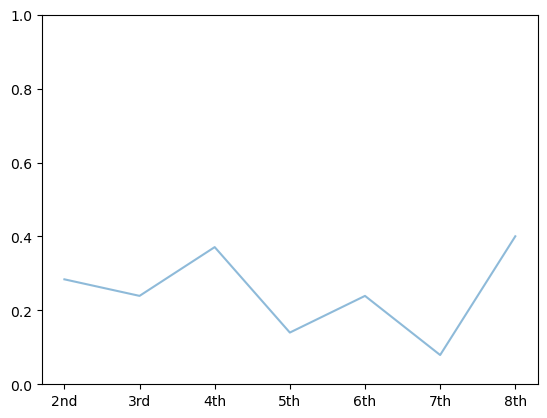

7 <class 'int'>


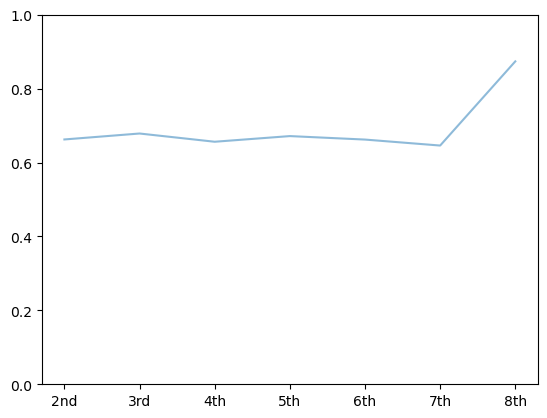

7 <class 'int'>


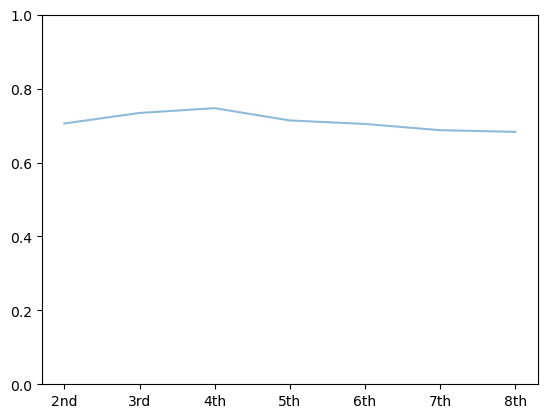

7 <class 'int'>


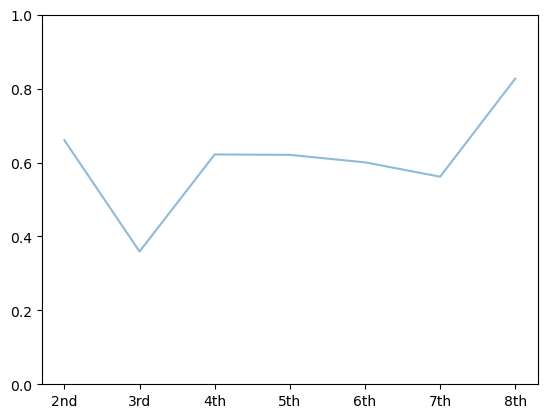

7 <class 'int'>


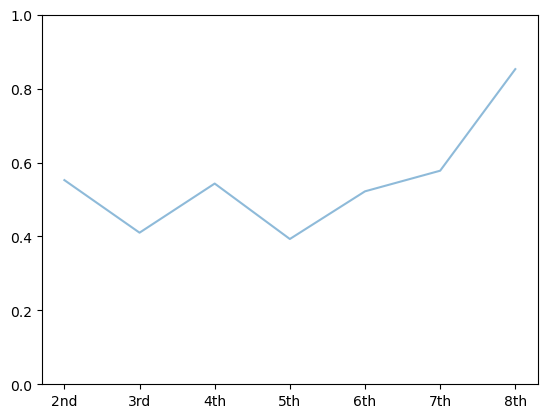

7 <class 'int'>


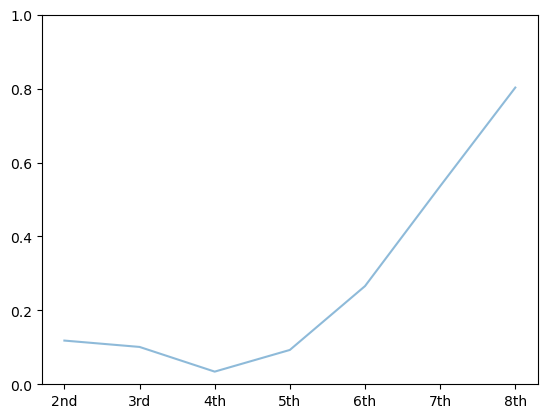

7 <class 'int'>


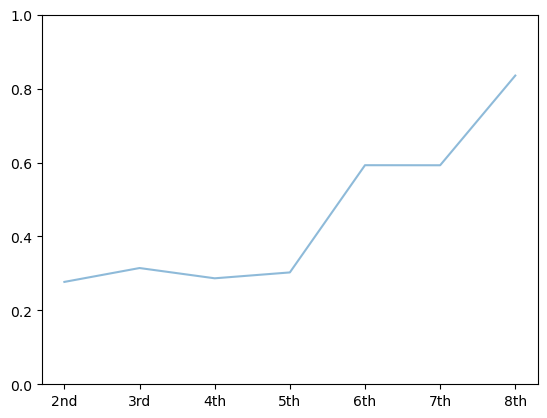

7 <class 'int'>


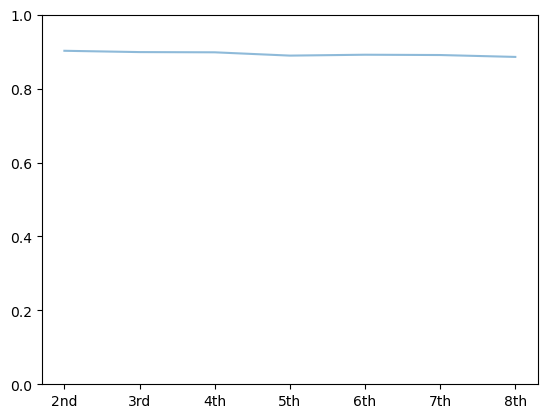

7 <class 'int'>


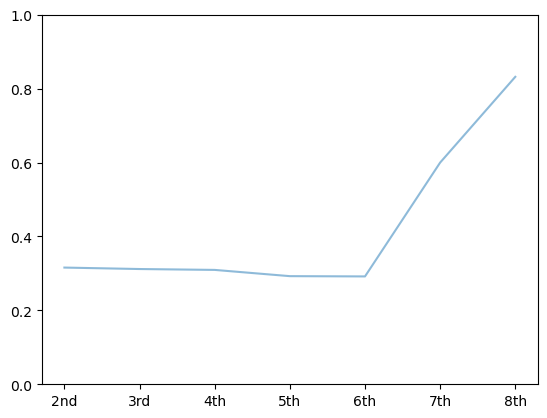

7 <class 'int'>


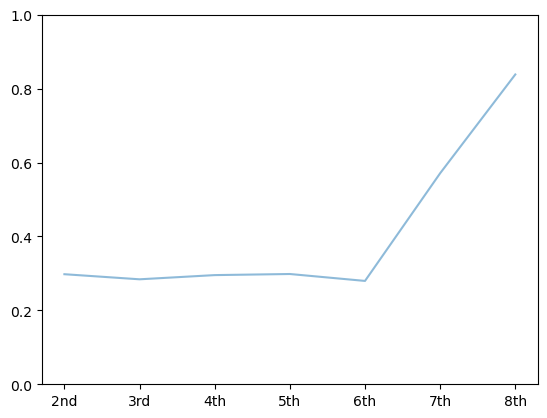

7 <class 'int'>


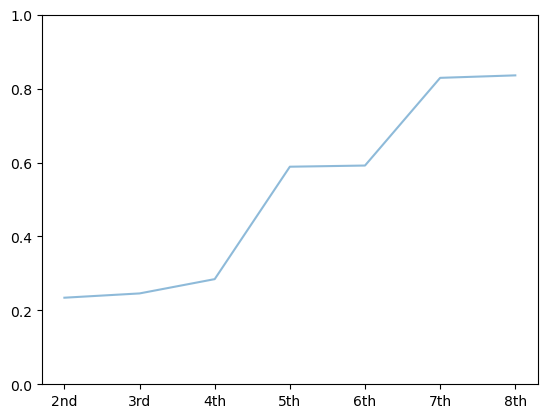

7 <class 'int'>


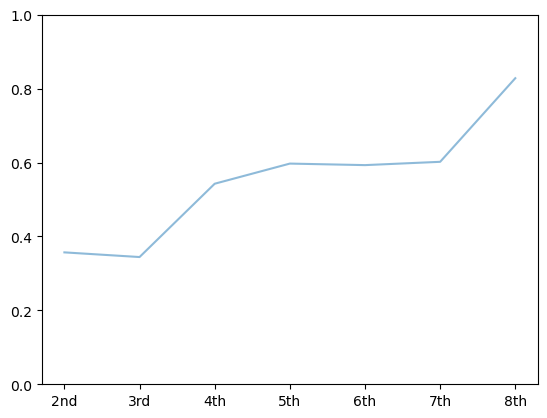

7 <class 'int'>


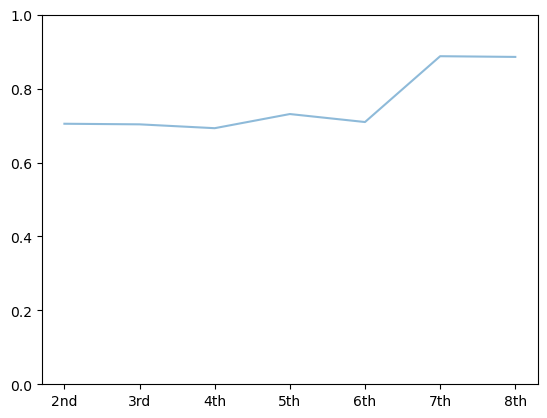

7 <class 'int'>


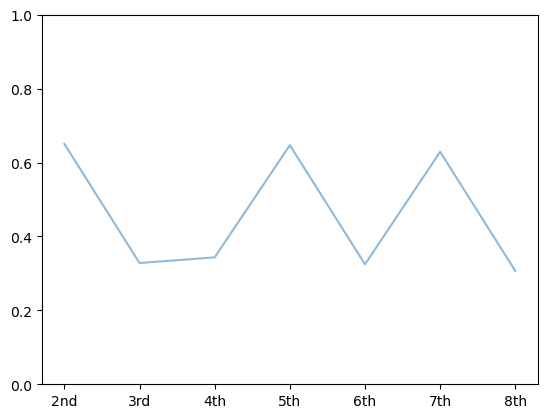

7 <class 'int'>


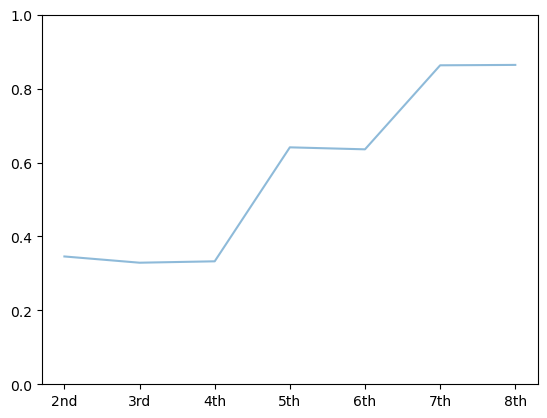

7 <class 'int'>


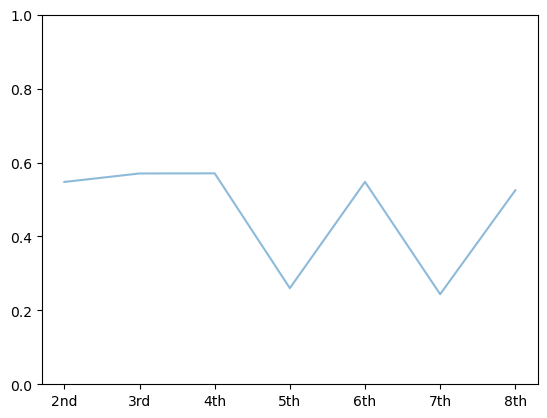

7 <class 'int'>


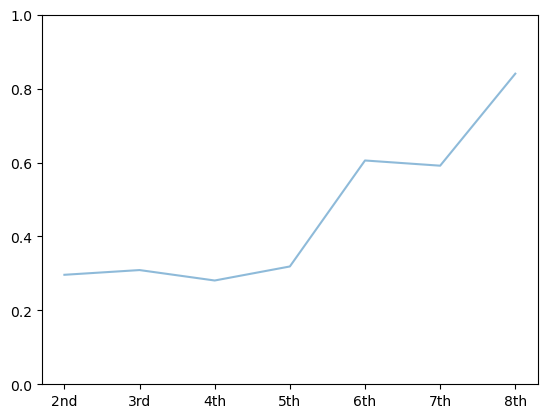

7 <class 'int'>


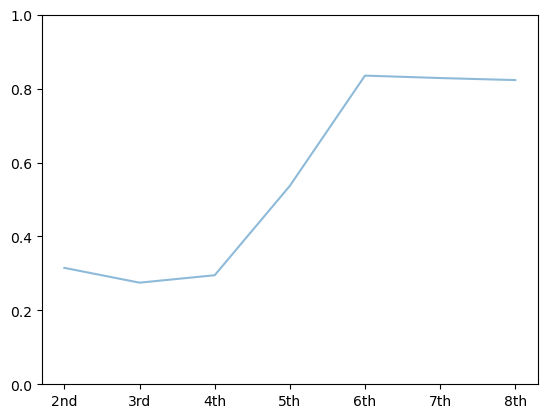

7 <class 'int'>


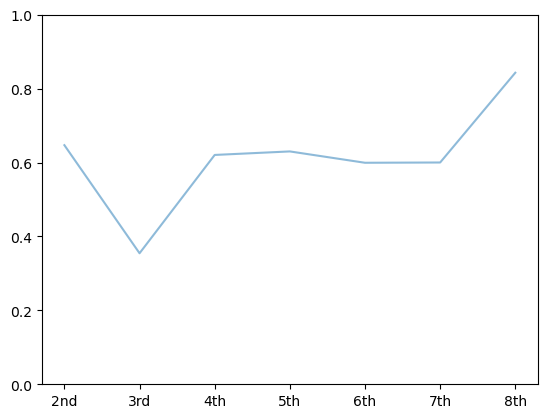

7 <class 'int'>


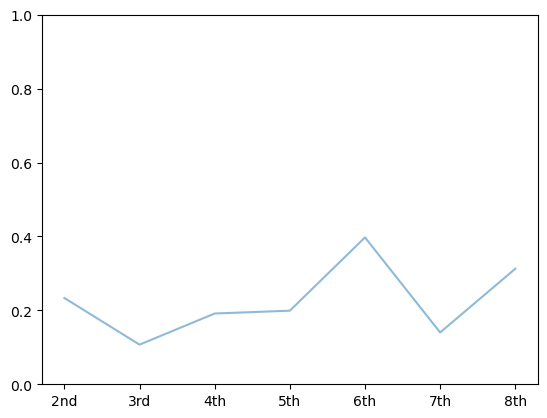

7 <class 'int'>


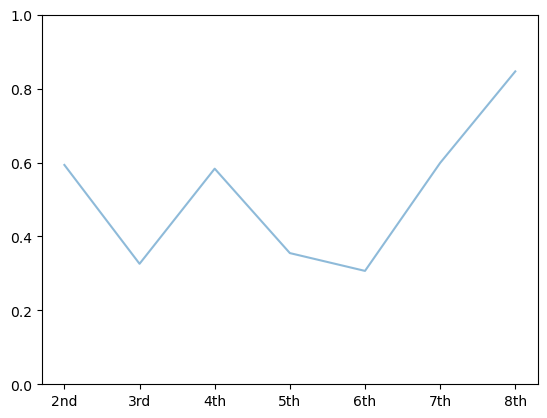

7 <class 'int'>


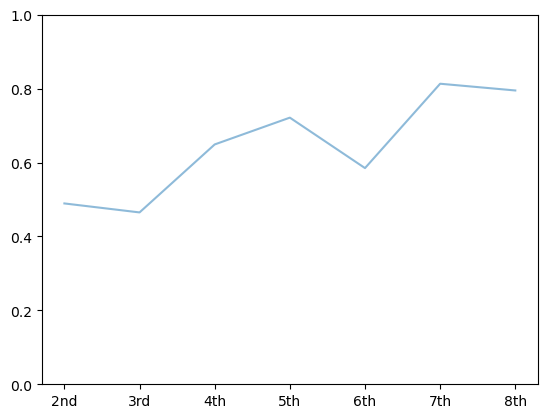

7 <class 'int'>


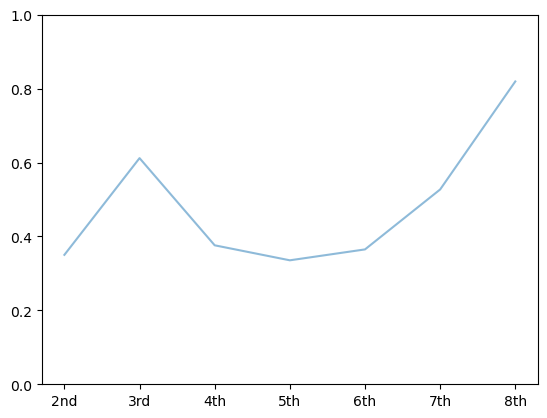

7 <class 'int'>


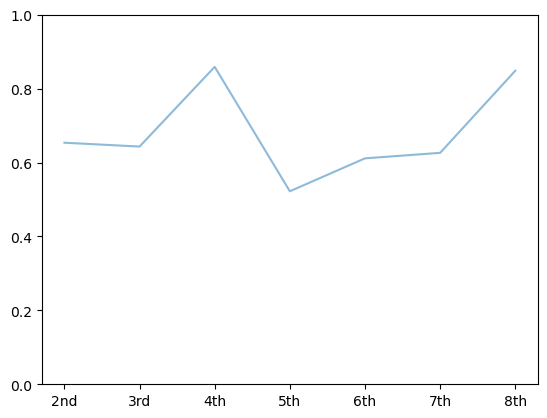

7 <class 'int'>


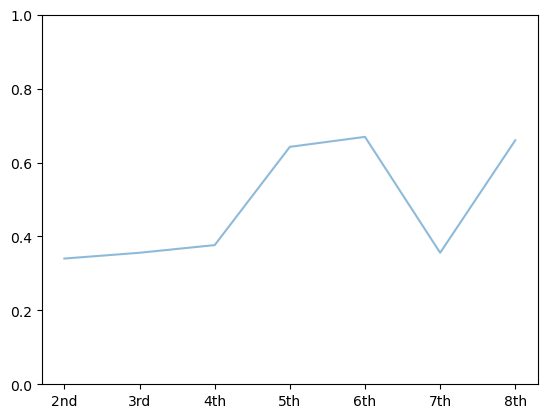

7 <class 'int'>


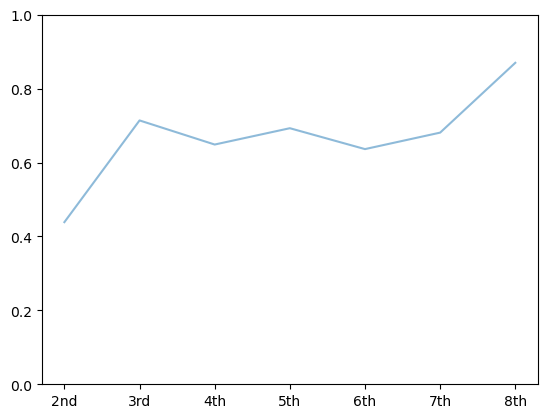

7 <class 'int'>


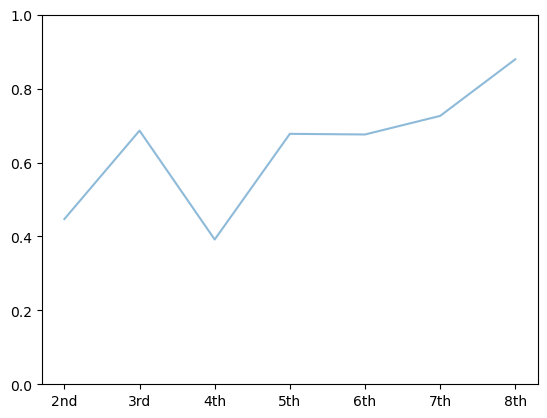

7 <class 'int'>


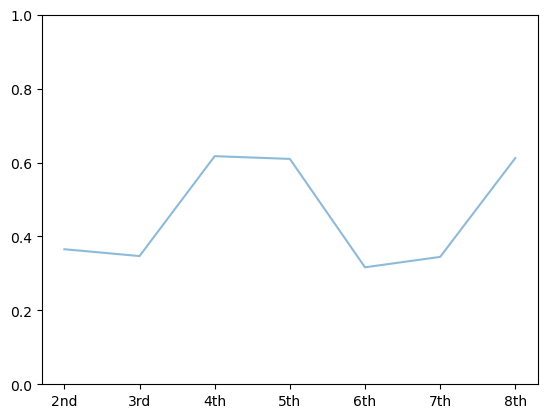

7 <class 'int'>


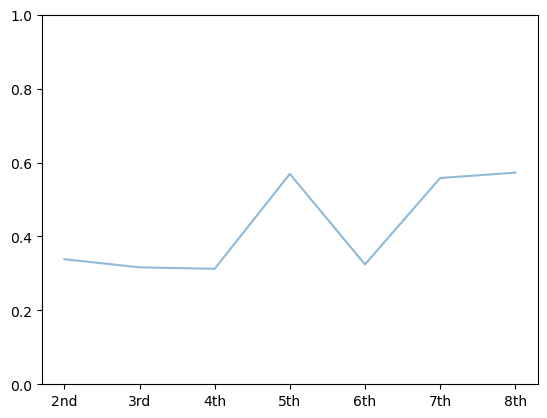

7 <class 'int'>


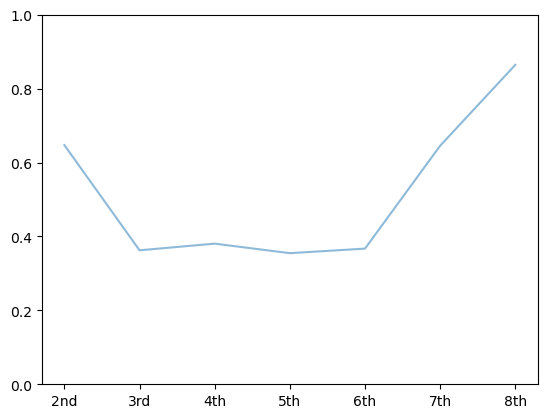

7 <class 'int'>


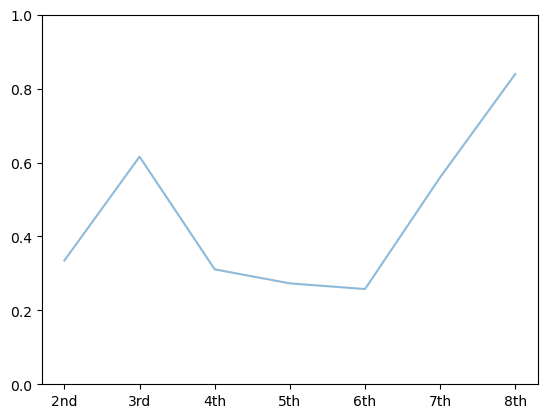

7 <class 'int'>


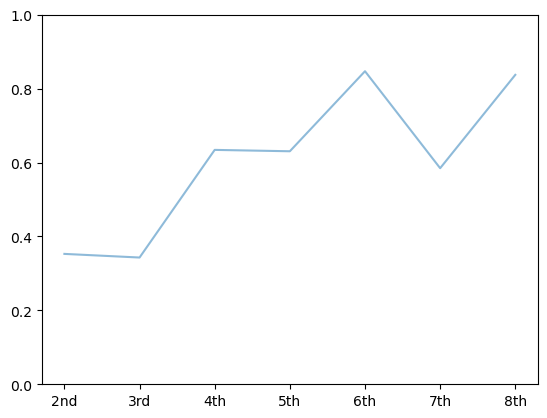

7 <class 'int'>


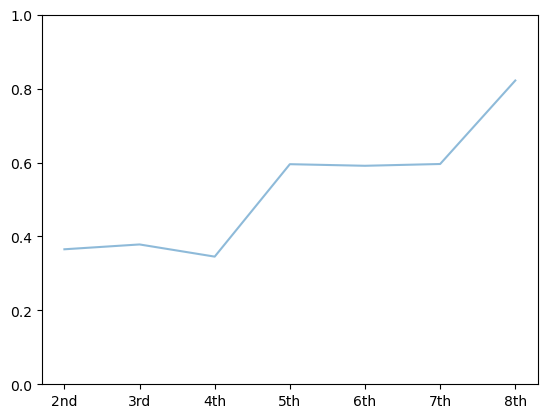

7 <class 'int'>


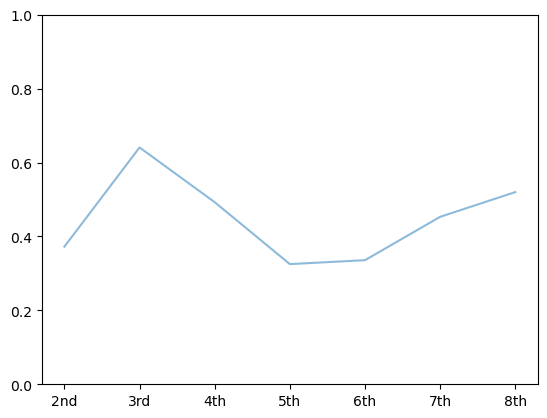

7 <class 'int'>


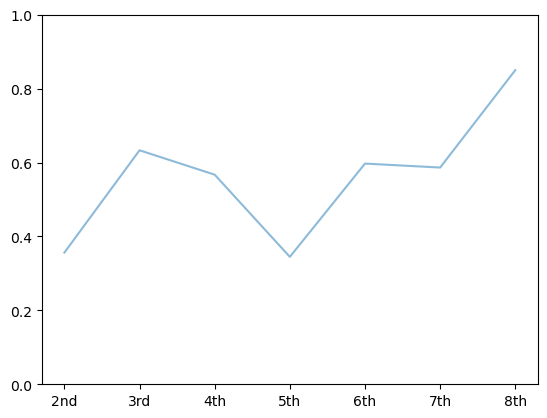

7 <class 'int'>


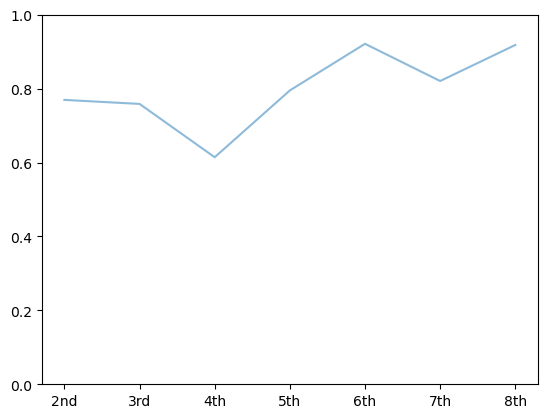

7 <class 'int'>


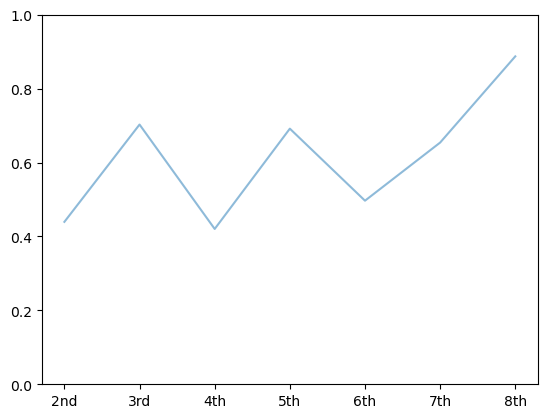

7 <class 'int'>


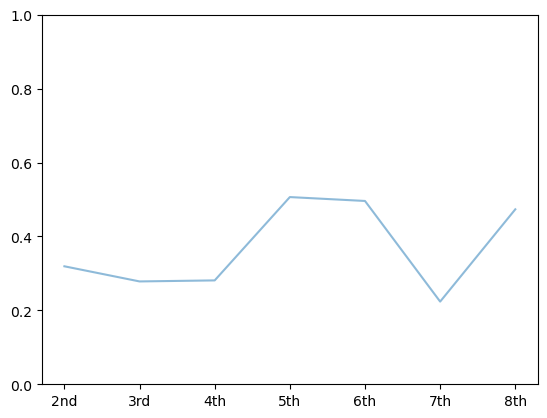

7 <class 'int'>


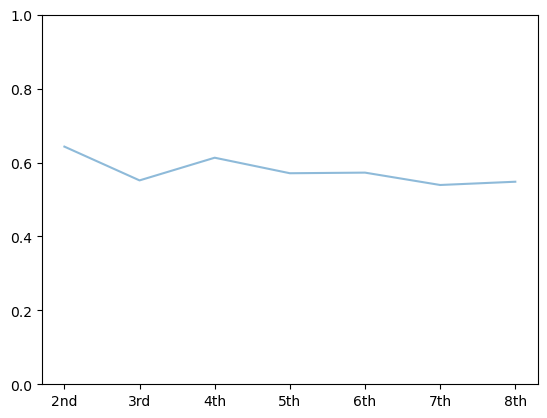

7 <class 'int'>


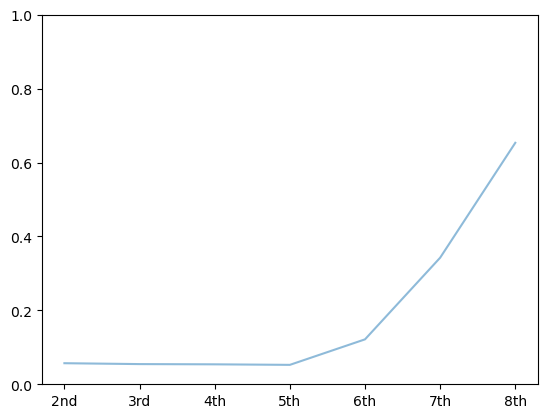

7 <class 'int'>


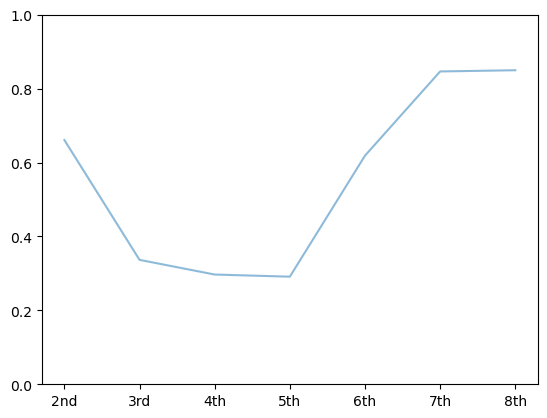

7 <class 'int'>


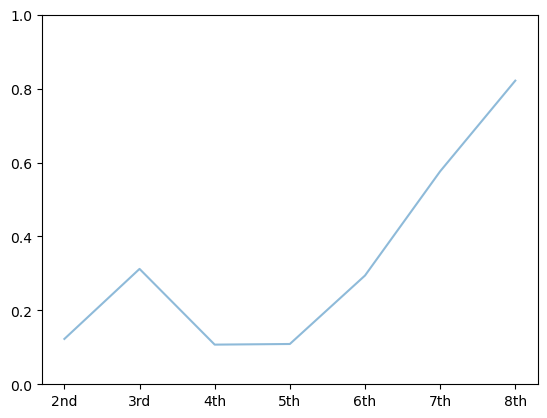

7 <class 'int'>


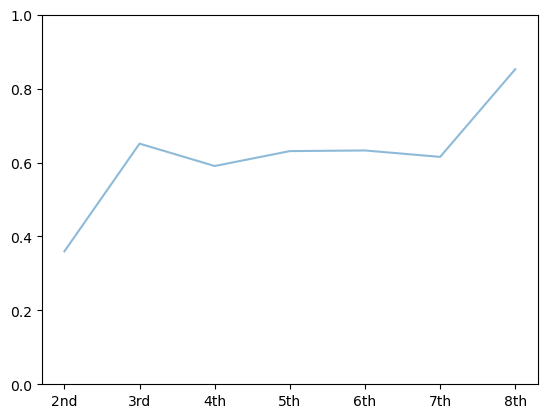

7 <class 'int'>


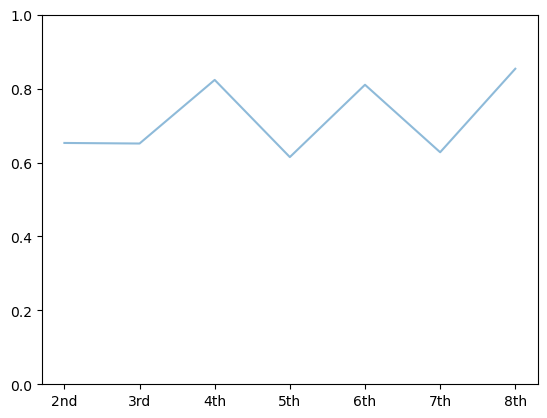

7 <class 'int'>


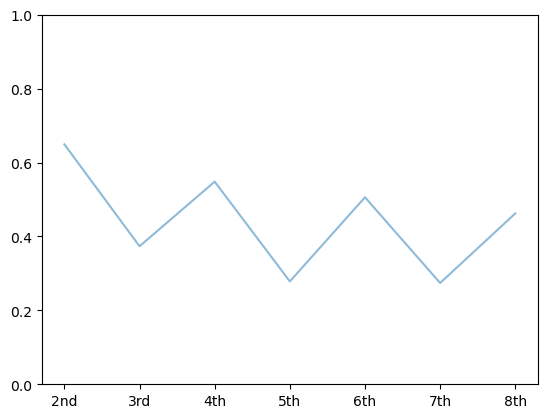

7 <class 'int'>


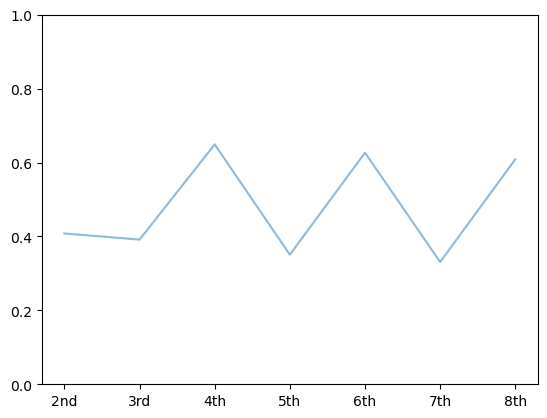

7 <class 'int'>


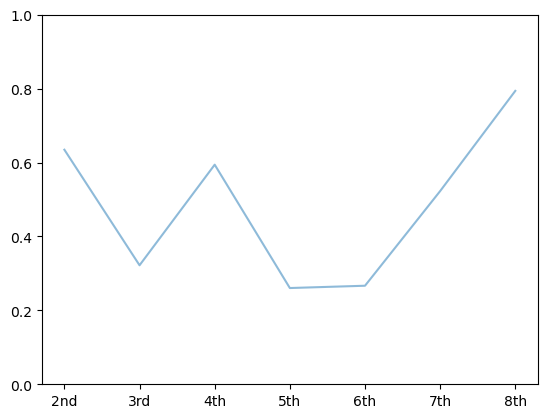

7 <class 'int'>


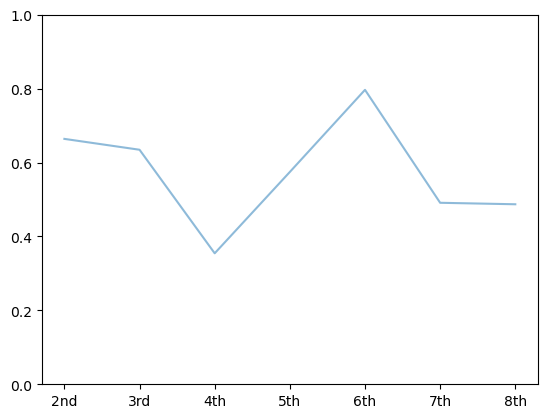

7 <class 'int'>


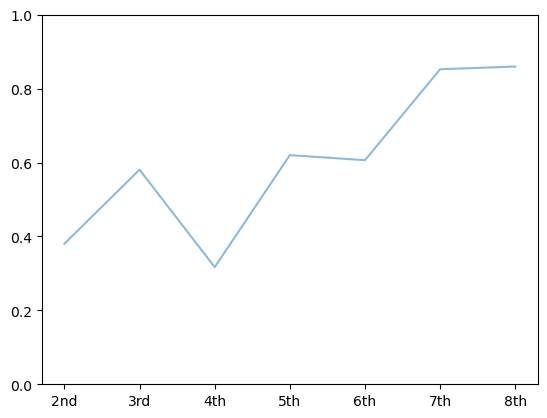

7 <class 'int'>


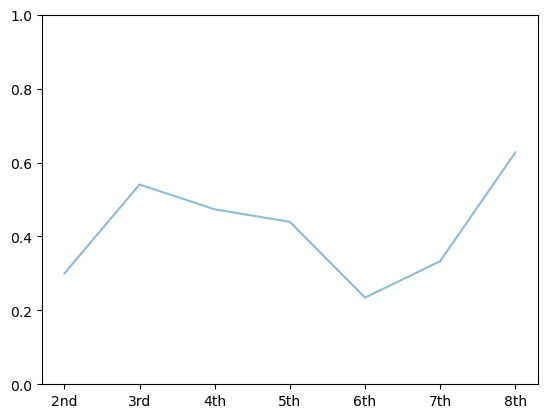

7 <class 'int'>


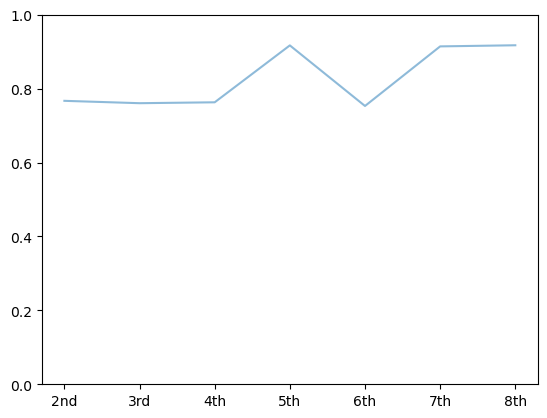

7 <class 'int'>


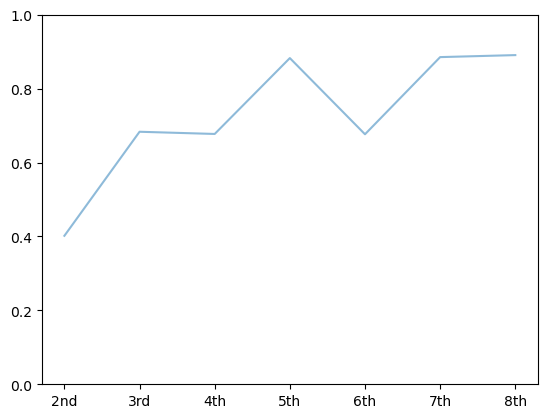

7 <class 'int'>


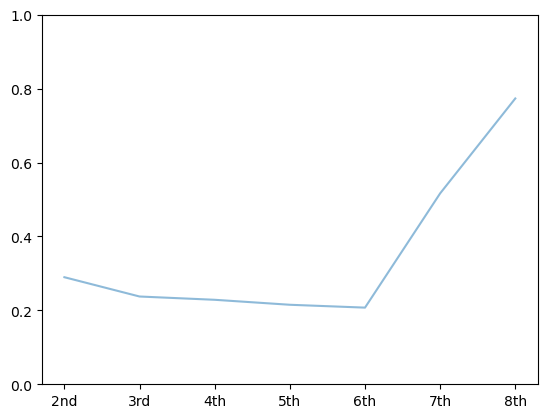

7 <class 'int'>


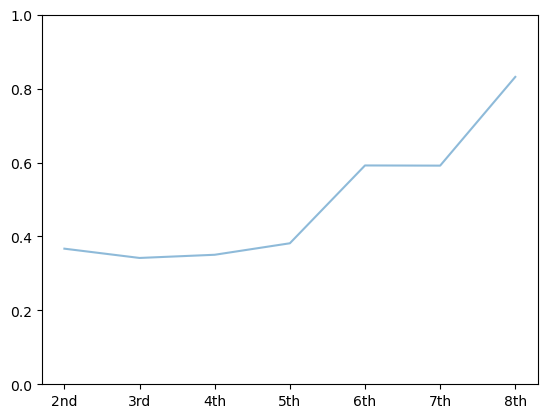

7 <class 'int'>


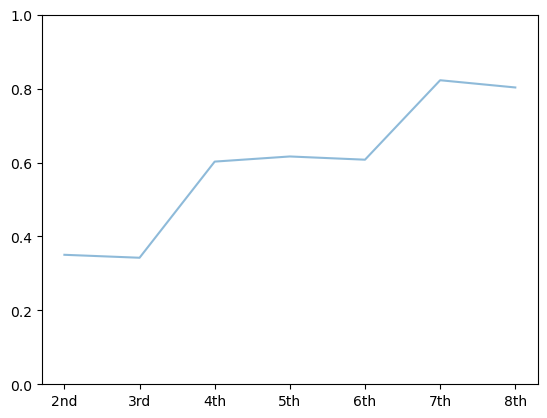

In [274]:
predict_and_print(true_games, false_games, 500, 0.5, model, graphs = True)